In [1]:
import numpy as np
import numpy.matlib
import pandas as pd
import sys
import os
import math
from time import time
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from argparse import Namespace

import torch
import torchvision

In [2]:
args = Namespace(
    # определение устройства на котором будут производиться рассчеты
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    # информация о данных и путях
    pathToFile_csv = 'itemData_2021-04-20_forecast_test.csv',
    vectorizer_file = "vectorizer.json",
    model_state_file = "model.pth",
    save_dir = "C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis",
    train_proportion = 0.80,
    val_proportion = 0.10,
    test_proportion = 0.10,
    # Гиперпараметры модели
    rnn_hidden_size = 180,
    # hidden_dim = ...
    # Гиперпараметры обучения
    seed = 1234,
    num_epochs = 2,
    learning_rate = 8e-5,
    num_layers = 2,
    batch_size = 1,
    logNormToNormData = lambda x : np.log(x + np.exp(1)),
    normToLogNormData = lambda x : np.exp(x) - np.exp(1),
)

idx = pd.IndexSlice

In [3]:
# -*- coding: utf-8 -*-
itemData= pd.read_csv(args.pathToFile_csv, header= None, sep= '\s+', encoding= 'cp1251')

In [4]:
# Подготовка данных preparation data

seasonality = {}
itemData= np.array(itemData)
listItem = itemData[:, 0]
listDelete = []      
for i, item in enumerate(listItem): 
    if item == "None":
        listDelete.append(i)
itemData = np.delete(itemData, listDelete, 0)
listItem = np.delete(listItem, listDelete, 0)   
print(itemData.shape)

small_sales_group = []
use_group = []
for item in range(itemData.shape[0]):
    sales = np.zeros(itemData[:, 1::3].shape[1], dtype=np.float32)
    remainder = np.zeros(16, dtype=np.float32)
    for i in range(itemData[:, 1::3].shape[1]):
        sales[i] = itemData[item, 3*i+1]
        if i < 16:
            remainder[i] = 0.4 * itemData[item, 3*i + 2] + 0.6 * itemData[item, 3*i +3]
    aver_sales = np.mean(sales[sales >= 0])
    if aver_sales < 0.4 or len(sales[sales >= 0]) < 10 or np.any(remainder <= 2.):
        small_sales_group.append(item)
        seasonality.setdefault(item, [1 for _ in range(itemData[:, 1::3].shape[1])])
    else:
        use_group.append(item)
        
print('quantity goods in small sales group - {} and use group - {}'.format(len(small_sales_group), len(use_group)))   

row = np.array(use_group)
col = np.array([i for i in range(itemData.shape[1])])
listItem = listItem[row]
itemData = itemData[row[:, np.newaxis], col]

fact_sale = itemData[:, 1:49]
items = itemData[:, 0]
items = items[:, np.newaxis]
inData = itemData[:, 49:]
itemData = np.hstack((items, inData))

fact_inRem = 0.4 * fact_sale[:, 1::3] + 0.6 * fact_sale[:, 2::3]
fact_sale = fact_sale[:, ::3] 
print(fact_sale.shape, fact_inRem.shape, itemData.shape)
for item in range(fact_sale.shape[0]):
    for i in range(fact_sale.shape[1]):
        fact_sale[item, i] = fact_sale[item, i] / np.log10(fact_inRem[item, i] + 1.)       
display(fact_sale)

inRemainderData = np.zeros((itemData.shape[0], itemData[:, 2::3].shape[1]), dtype=np.float32)
itemSalesData = np.zeros((itemData.shape[0], itemData[:, 1::3].shape[1]), dtype=np.float32)
print(itemData.shape, itemSalesData.shape, inRemainderData.shape)

for item in range(itemData.shape[0]):
    for i in range(itemSalesData.shape[1]):
        inRemainderData[item, i] = 0.4 * itemData[item, 3*i+2] + 0.6 * itemData[item, 3*i+3]
        itemSalesData[item, i] = itemData[item, 3*i+1] / np.log10(inRemainderData[item, i] + 1.) if \
        ((inRemainderData[item, i] > 2.2) or (inRemainderData[item, i] > 1.9 and itemData[item, 3*i+1] != 0))  else -1                                

# заполняем массив усредненными по годам недельными продажами
meanSaleByNumberWeekInYear = np.zeros(itemSalesData.shape, dtype=np.float32)
def remove_trend(data):
    """
        in data - (2-dim massive, row - article, col - sales by week)
        calculate trend use week 0 - 10 and 93 - 103
        out data - data without trend
    """
    col = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
    for row in range(data.shape[0]):        
        fp = np.polyfit(col, data[row][col], 1)
        for x in range(data.shape[1]):
            data[row, x] = data[row, x] - fp[0] * (x - 51)
    return data

itemSalesData_remove_trend = remove_trend(itemSalesData.copy())
numWeekForSeasonal = itemSalesData.shape[1] - 16
for index in range(itemSalesData.shape[0]):
    for iWeek in range(itemSalesData.shape[1]):
        counter = 0
        x = 0.
        if itemSalesData_remove_trend[index, iWeek % numWeekForSeasonal] >= 0.:
            x += itemSalesData_remove_trend[index, iWeek % numWeekForSeasonal]
            counter += 1           
        if itemSalesData_remove_trend[index, (iWeek + 52) % numWeekForSeasonal] >= 0.:
            x += itemSalesData_remove_trend[index, (iWeek + 52) % numWeekForSeasonal]
            counter += 1
        if itemSalesData_remove_trend[index, (iWeek + 104) % numWeekForSeasonal] >= 0.:
            x += itemSalesData_remove_trend[index, (iWeek + 104) % numWeekForSeasonal]
            counter += 1              
        if counter > 0:    
            meanSaleByNumberWeekInYear[index, iWeek] = x / counter
        else:
            meanSaleByNumberWeekInYear[index, iWeek] = -1
# ----------------------------------------------------------------        
# усреднение по трем точкам        
# tSmoothingStart = time()
for i in range(itemSalesData.shape[0]):
    tempData = itemSalesData[i, :]
    tempDataSales = np.empty_like(tempData)
    lenData = itemSalesData.shape[1]
    for iweek in range(lenData):
        nElem = 0
        sumElem = 0.
        if tempData[(iweek-1) % lenData] != -1:
            sumElem += tempData[(iweek-1) % lenData]
            nElem += 1
        if tempData[iweek % lenData] != -1:
            sumElem += tempData[iweek % lenData]
            nElem += 1 
        if tempData[(iweek+1) % lenData] != -1:
            sumElem += tempData[(iweek+1) % lenData]
            nElem += 1     
        tempDataSales[iweek] = sumElem / nElem if nElem != 0 else -1.
    itemSalesData[i, :] = tempDataSales[:]    
# tSmoothingFinish = time()
# -----------------------------------------------------------------
# дополнение данных с 104 до 120 (продажи дополняем -1, а средне недельные продажи - среднеми продажами соотв. недели)
print('дополнение данных')
itemSalesData_add = np.full((itemSalesData.shape[0], 16), -1., dtype = 'f4')
itemSalesData = np.hstack([itemSalesData_add, itemSalesData])
meanSaleByNumberWeekInYear_add = meanSaleByNumberWeekInYear[:, 36:52].copy()
meanSaleByNumberWeekInYear = np.hstack([meanSaleByNumberWeekInYear_add, meanSaleByNumberWeekInYear])
print('shape itemSalesData- ', itemSalesData.shape, 
      'shape meanSaleByNumberWeekInYear - ', meanSaleByNumberWeekInYear.shape)
# --------------------------------------------------------------------------------------------------------------------

# используем скользящую медиану с окном шириной 3 для представления входных данных
print('сглаживаем временной ряд скользящей медианой с окном шириной 3')
def skate_median(series, wide_window):
    skate_median_series = []
    for_first_median = np.sort([series[0], series[1], 3 * series[1] - 2 * series[2]])
    for_last_median = np.sort([series[-1], series[-2], 3 * series[-2] - 2 * series[-3]])
    skate_median_series.append(get_median(for_first_median))
    cur_series = [series[i] for i in range(wide_window)]
    cur_series = np.array(cur_series)
    cur_series = np.sort(cur_series)
    n = wide_window
    skate_median_series.append(get_median(cur_series))
    while n < len(series):
        temp = []
        data_bool = 0 
        for i, value in enumerate(cur_series):
            if value != series[n - wide_window]:
                temp.append(value)
            else:
                if data_bool:
                    temp.append(value)             
                else:
                    data_bool = 1
        place = get_place_insert(temp, series[n]) 
        cur_series[place] = series[n]
        for i, value in enumerate(temp):            
            if i < place:
                cur_series[i] = value
            else:
                cur_series[i+1] = value        
        skate_median_series.append(get_median(cur_series))                              
        n += 1    
    skate_median_series.append(get_median(for_last_median))                           
    return skate_median_series

def get_median(series):
    n = len(series)
    if n % 2 == 0:
        return series[n//2 - 1] + series[n//2]
    elif n % 2 == 1:
        return series[n//2]
    
def get_place_insert(series, value):
    left = -1
    right = len(series)
    while right > left + 1:
        middle = (right + left) // 2
        if series[middle] > value:
            right = middle                
        elif series[middle] <= value:
            left = middle
    return right 
# for i in range(itemSalesData.shape[0]):
#     itemSalesData[i, :] = skate_median(itemSalesData[i, :], 3)
#     meanSaleByNumberWeekInYear[i, :] = skate_median(meanSaleByNumberWeekInYear[i, :], 3)
# ------------------------------------------------------------------------

#   здесь переход от логнормального распределения к нормальному 
itemSalesData[itemSalesData > 0.] = args.logNormToNormData(itemSalesData[itemSalesData > 0.])
itemSalesData[itemSalesData <= 0.] = 1e-6
meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear > 0.] = \
    args.logNormToNormData(meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear > 0.])
meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear <= 0. ] = 1e-6
#   -----------------------------------------------------------

# Переверот данных (из будущего в прошлое --> из прошлого в будущее)
itemSalesData = np.flip(itemSalesData, axis=1)
meanSaleByNumberWeekInYear = np.flip(meanSaleByNumberWeekInYear, axis=1)  
# -------------------------------------------------------------------

# print('smoothing time = %f' %(tSmoothingFinish - tSmoothingStart)) 

itemSalesData = itemSalesData[:, np.newaxis, :]
meanSaleByNumberWeekInYear = meanSaleByNumberWeekInYear[:, np.newaxis, :]
itemSalesData = np.concatenate((meanSaleByNumberWeekInYear, itemSalesData), axis = 1)
torch_itemSalesData = torch.from_numpy(itemSalesData)
display(torch_itemSalesData)
print(torch_itemSalesData.shape)

(22848, 361)


d:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-4-895b6c9c9570>:24: RuntimeWarning: invalid value encountered in less
  if aver_sales < 0.4 or len(sales[sales >= 0]) < 10 or np.any(remainder <= 2.):


quantity goods in small sales group - 20444 and use group - 2404
(2404, 16) (2404, 16) (2404, 313)


array([[0.9602525677891274, 1.7954234350052463, 1.7450057390983118, ...,
        0.0, 0.8231510589669937, 0.8231510589669937],
       [0.7877036658464717, 0.7894516833031072, 0.7859745393765324, ...,
        0.7660772596606911, 0.0, 1.54241820866388],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [1.2620021300743383, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 1.8923179295382822, ..., 0.0, 3.234839842338688,
        2.3973248730437535],
       [0.0, 0.0, 0.0, ..., 0.0, 2.0552283984080786, 2.949755808465853]],
      dtype=object)

(2404, 313) (2404, 104) (2404, 104)
дополнение данных
shape itemSalesData-  (2404, 120) shape meanSaleByNumberWeekInYear -  (2404, 120)
сглаживаем временной ряд скользящей медианой с окном шириной 3


tensor([[[1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06,
          1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06,
          1.0000e-06, 1.0000e-06]],

        [[1.0059e+00, 1.0056e+00, 1.0052e+00,  ..., 1.0011e+00,
          1.3440e+00, 1.2364e+00],
         [1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06,
          1.0000e-06, 1.0000e-06]],

        [[1.5870e+00, 1.1638e+00, 1.1700e+00,  ..., 1.0000e-06,
          1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06,
          1.0000e-06, 1.0000e-06]],

        ...,

        [[1.3795e+00, 1.2620e+00, 1.0892e+00,  ..., 1.2035e+00,
          1.4815e+00, 1.4393e+00],
         [1.0000e-06, 1.0992e+00, 1.0992e+00,  ..., 1.0000e-06,
          1.0000e-06, 1.0000e-06]],

        [[1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.2556e+00,
          1.9037e+00, 1.2334e+00],
         [1.4591e+00, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06,
          1.0000e-06, 1

torch.Size([2404, 2, 120])


In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ConvRecNeuronNet(nn.Module):
    def __init__(self):
        super(ConvRecNeuronNet, self).__init__()
        self.conv1= nn.Conv1d(in_channels= 2, out_channels= 32, kernel_size= 3, stride= 3)
        self.conv1_bn= nn.BatchNorm1d(num_features= 32)
        self.conv2= nn.Conv1d(in_channels= 32, out_channels= 48, kernel_size= 5, stride= 3, padding= 2)
        self.conv2_bn= nn.BatchNorm1d(num_features= 48)
        self.birnn= nn.LSTM(input_size=48, hidden_size= args.rnn_hidden_size, num_layers= args.num_layers, \
                               bidirectional=True, batch_first=True, dropout = 0.9)
        self.fc1= nn.Linear(2 * 14 * args.rnn_hidden_size, 120)

    def forward(self, x):
        x= F.leaky_relu(self.conv1(x))
        x= self.conv1_bn(x)
        x= F.leaky_relu(self.conv2(x))
        x= self.conv2_bn(x)
        x= x.permute(0, 2, 1)
        x_birnn_out, (x_birnn_h, x_birnn_c) = self.birnn(x)
        batch_size, seq_size, feat_size = x_birnn_out.shape
        x_birnn= x_birnn_out.contiguous().view(batch_size, seq_size * feat_size).unsqueeze(1)
        x= F.leaky_relu(self.fc1(x_birnn))
        return x

In [6]:
net= ConvRecNeuronNet()

path = \
u'C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis\\develop_forecast\\CNN_RNN_forecast_in_combination_with_recovery_new_last_ver3.pt'
net.load_state_dict(torch.load(path))
net.eval()
with torch.no_grad():
    y_pred_forecast = net(torch_itemSalesData)
    
# path = \
# u'C:\\Users\\MKoga\\MyProgramms\\BusinessAnalysis\\develop_forecast\\CNN_RNN_forecast_in_combination_with_recovery_new_last_ver3.pt'
# net.load_state_dict(torch.load(path))
# net.eval()
# with torch.no_grad():
#     y_pred_forecast_model_2 = net(torch_itemSalesData)
      

In [7]:
y_pred_forecast = np.array(y_pred_forecast.float().squeeze(1))
#  здесь переход от нормального распределения к логнормальному
itemSalesData[itemSalesData != 1e-6] = args.normToLogNormData(itemSalesData[itemSalesData != 1e-6])
itemSalesData[itemSalesData == 1e-6] = -1
y_pred_forecast = args.normToLogNormData(y_pred_forecast_model_1)
y_pred_forecast[y_pred_forecast < 0.] = 0.

In [9]:
indexOfItem = set() 
for index in range(len(listItem)):
    if listItem[index] in ['38180', '4405', '9937', '4147', '736N', '126\\2', '812\\2', 'DE0497', 'DE0453', 'К81593', \
            'Н25019', 'ВВ2175', 'И58652', 'И58924', 'Н90309', 'ВВ2809', 'Н33641', '36311']:
        indexOfItem .add(index)
for ourIndex in indexOfItem:
    print('indexItem %s -> item %s' %(ourIndex, listItem[ourIndex]))        

indexItem 545 -> item 9937
indexItem 1191 -> item Н25019
indexItem 2379 -> item 4147
indexItem 2124 -> item И58652
indexItem 845 -> item 812\2
indexItem 560 -> item 36311
indexItem 1072 -> item 736N
indexItem 1776 -> item 4405
indexItem 2105 -> item DE0453
indexItem 602 -> item Н33641


(2404, 2, 120)


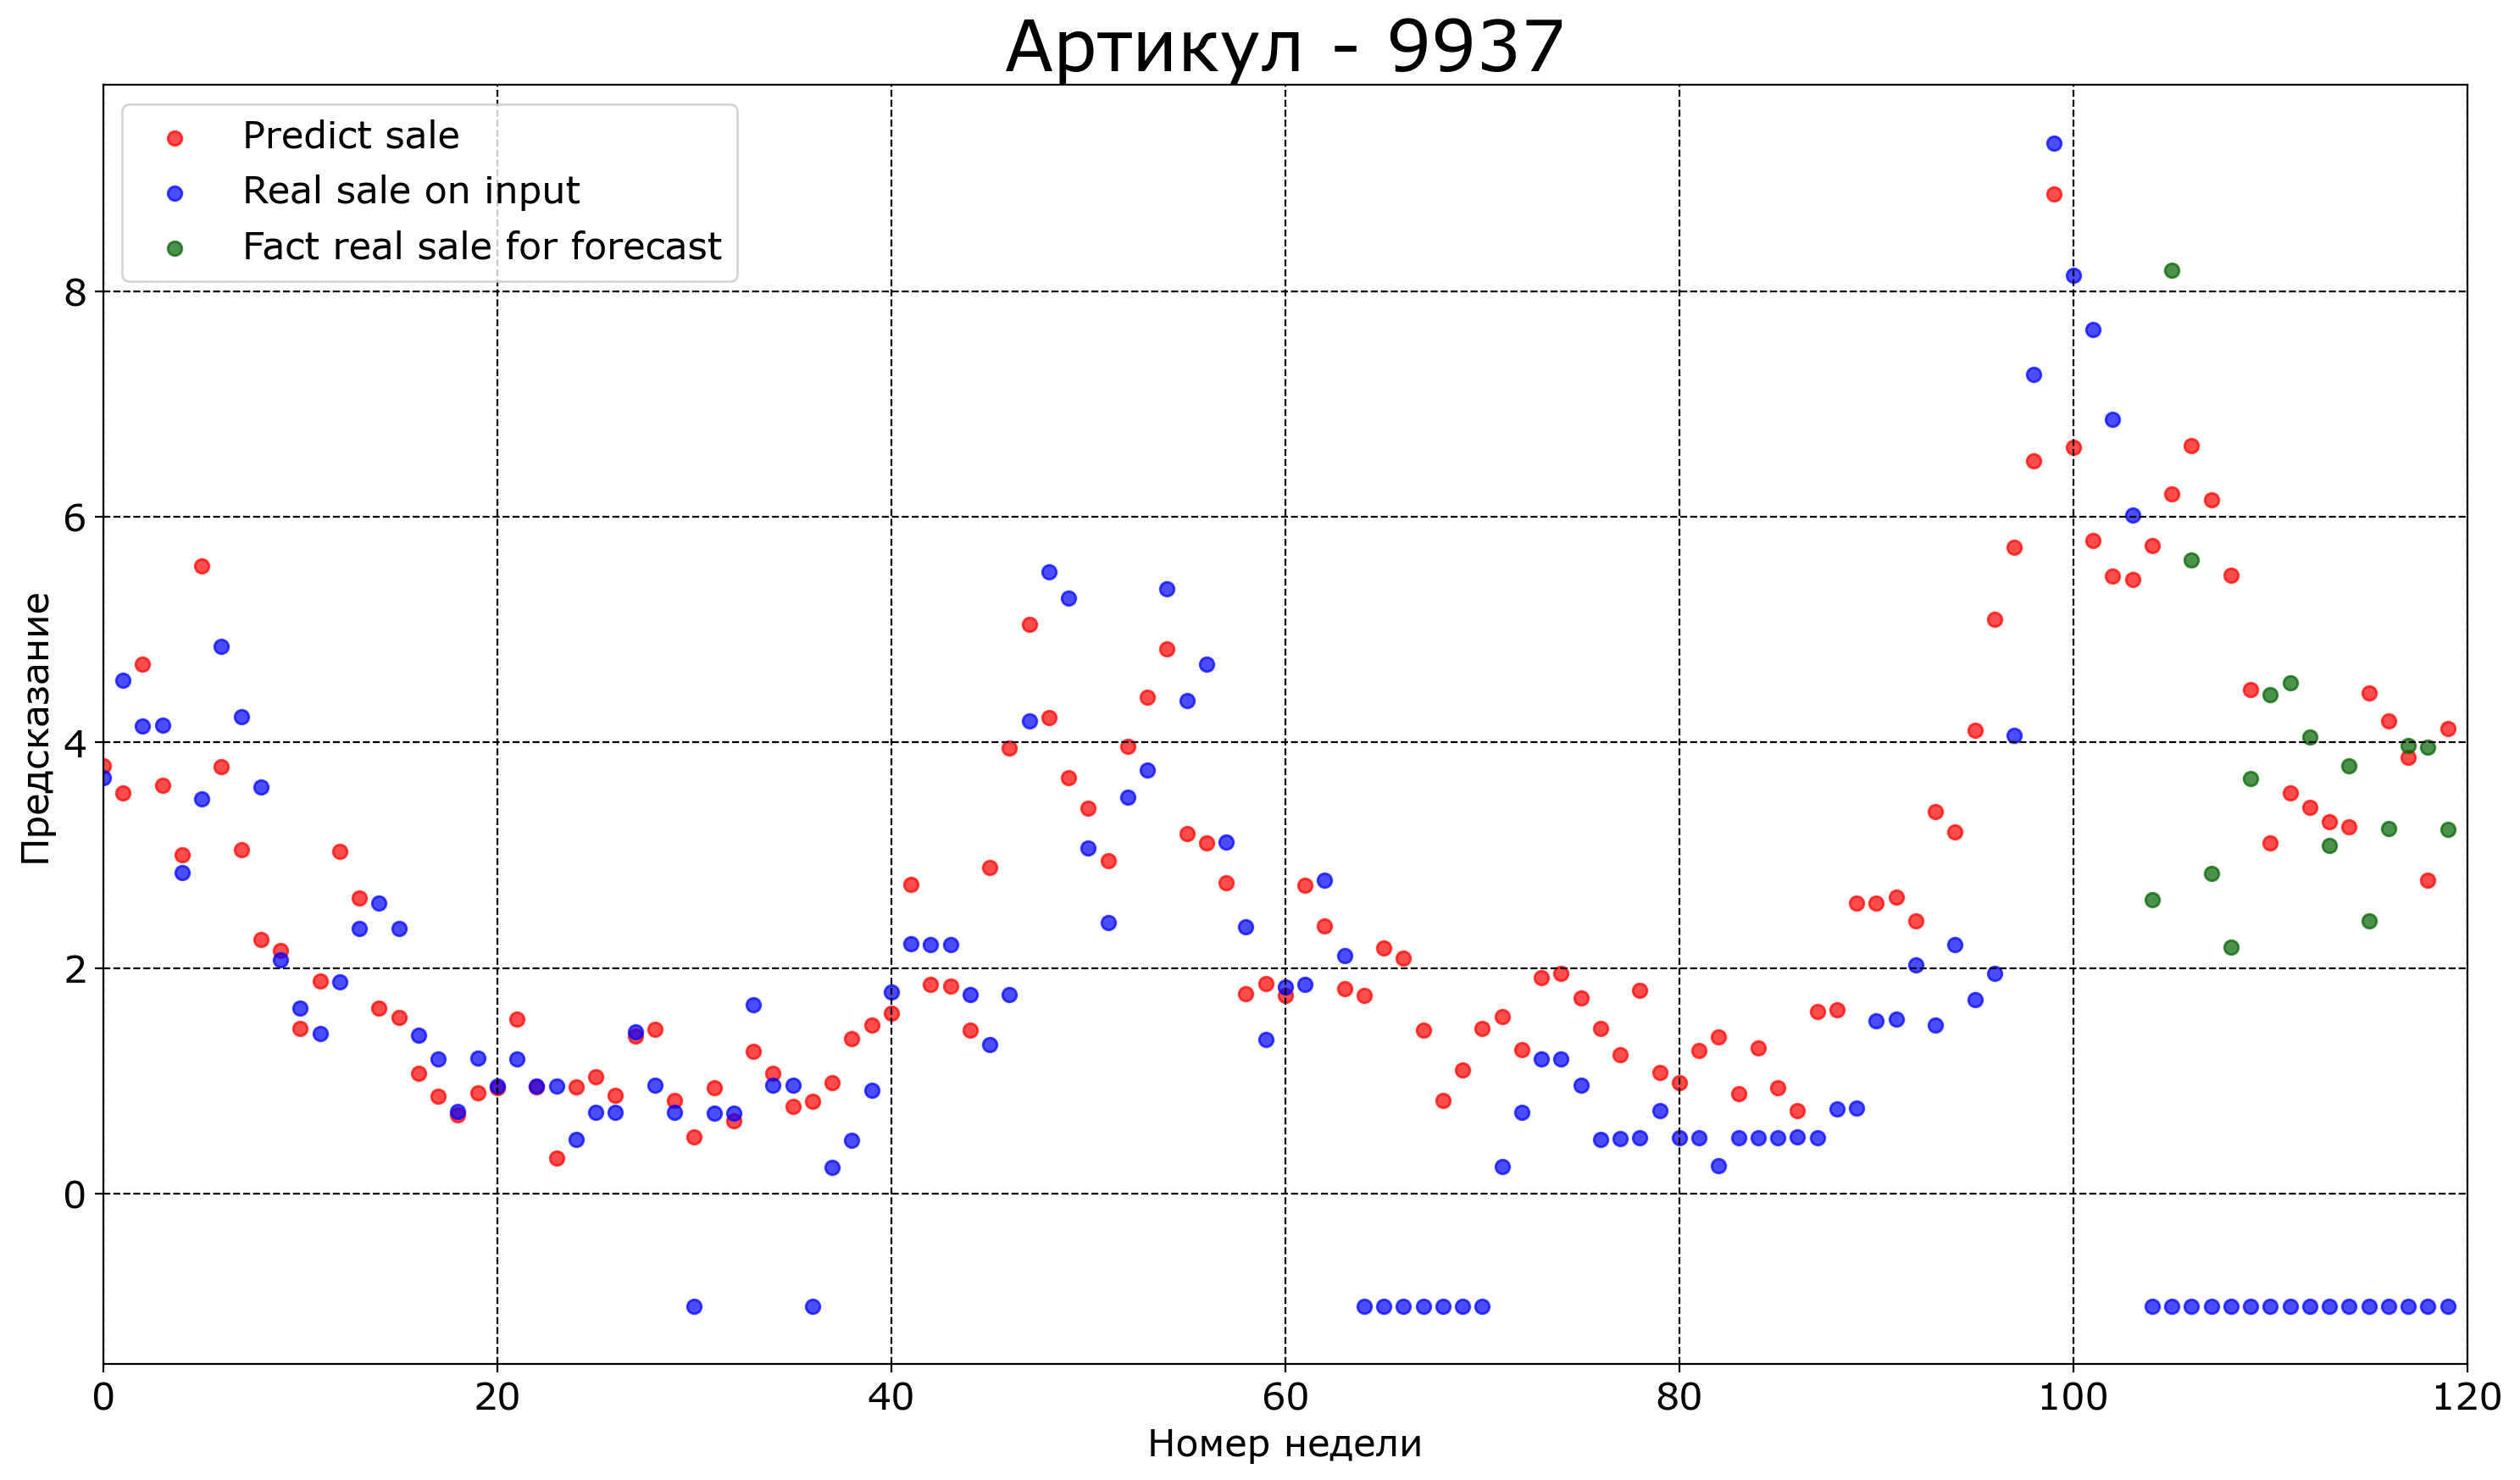

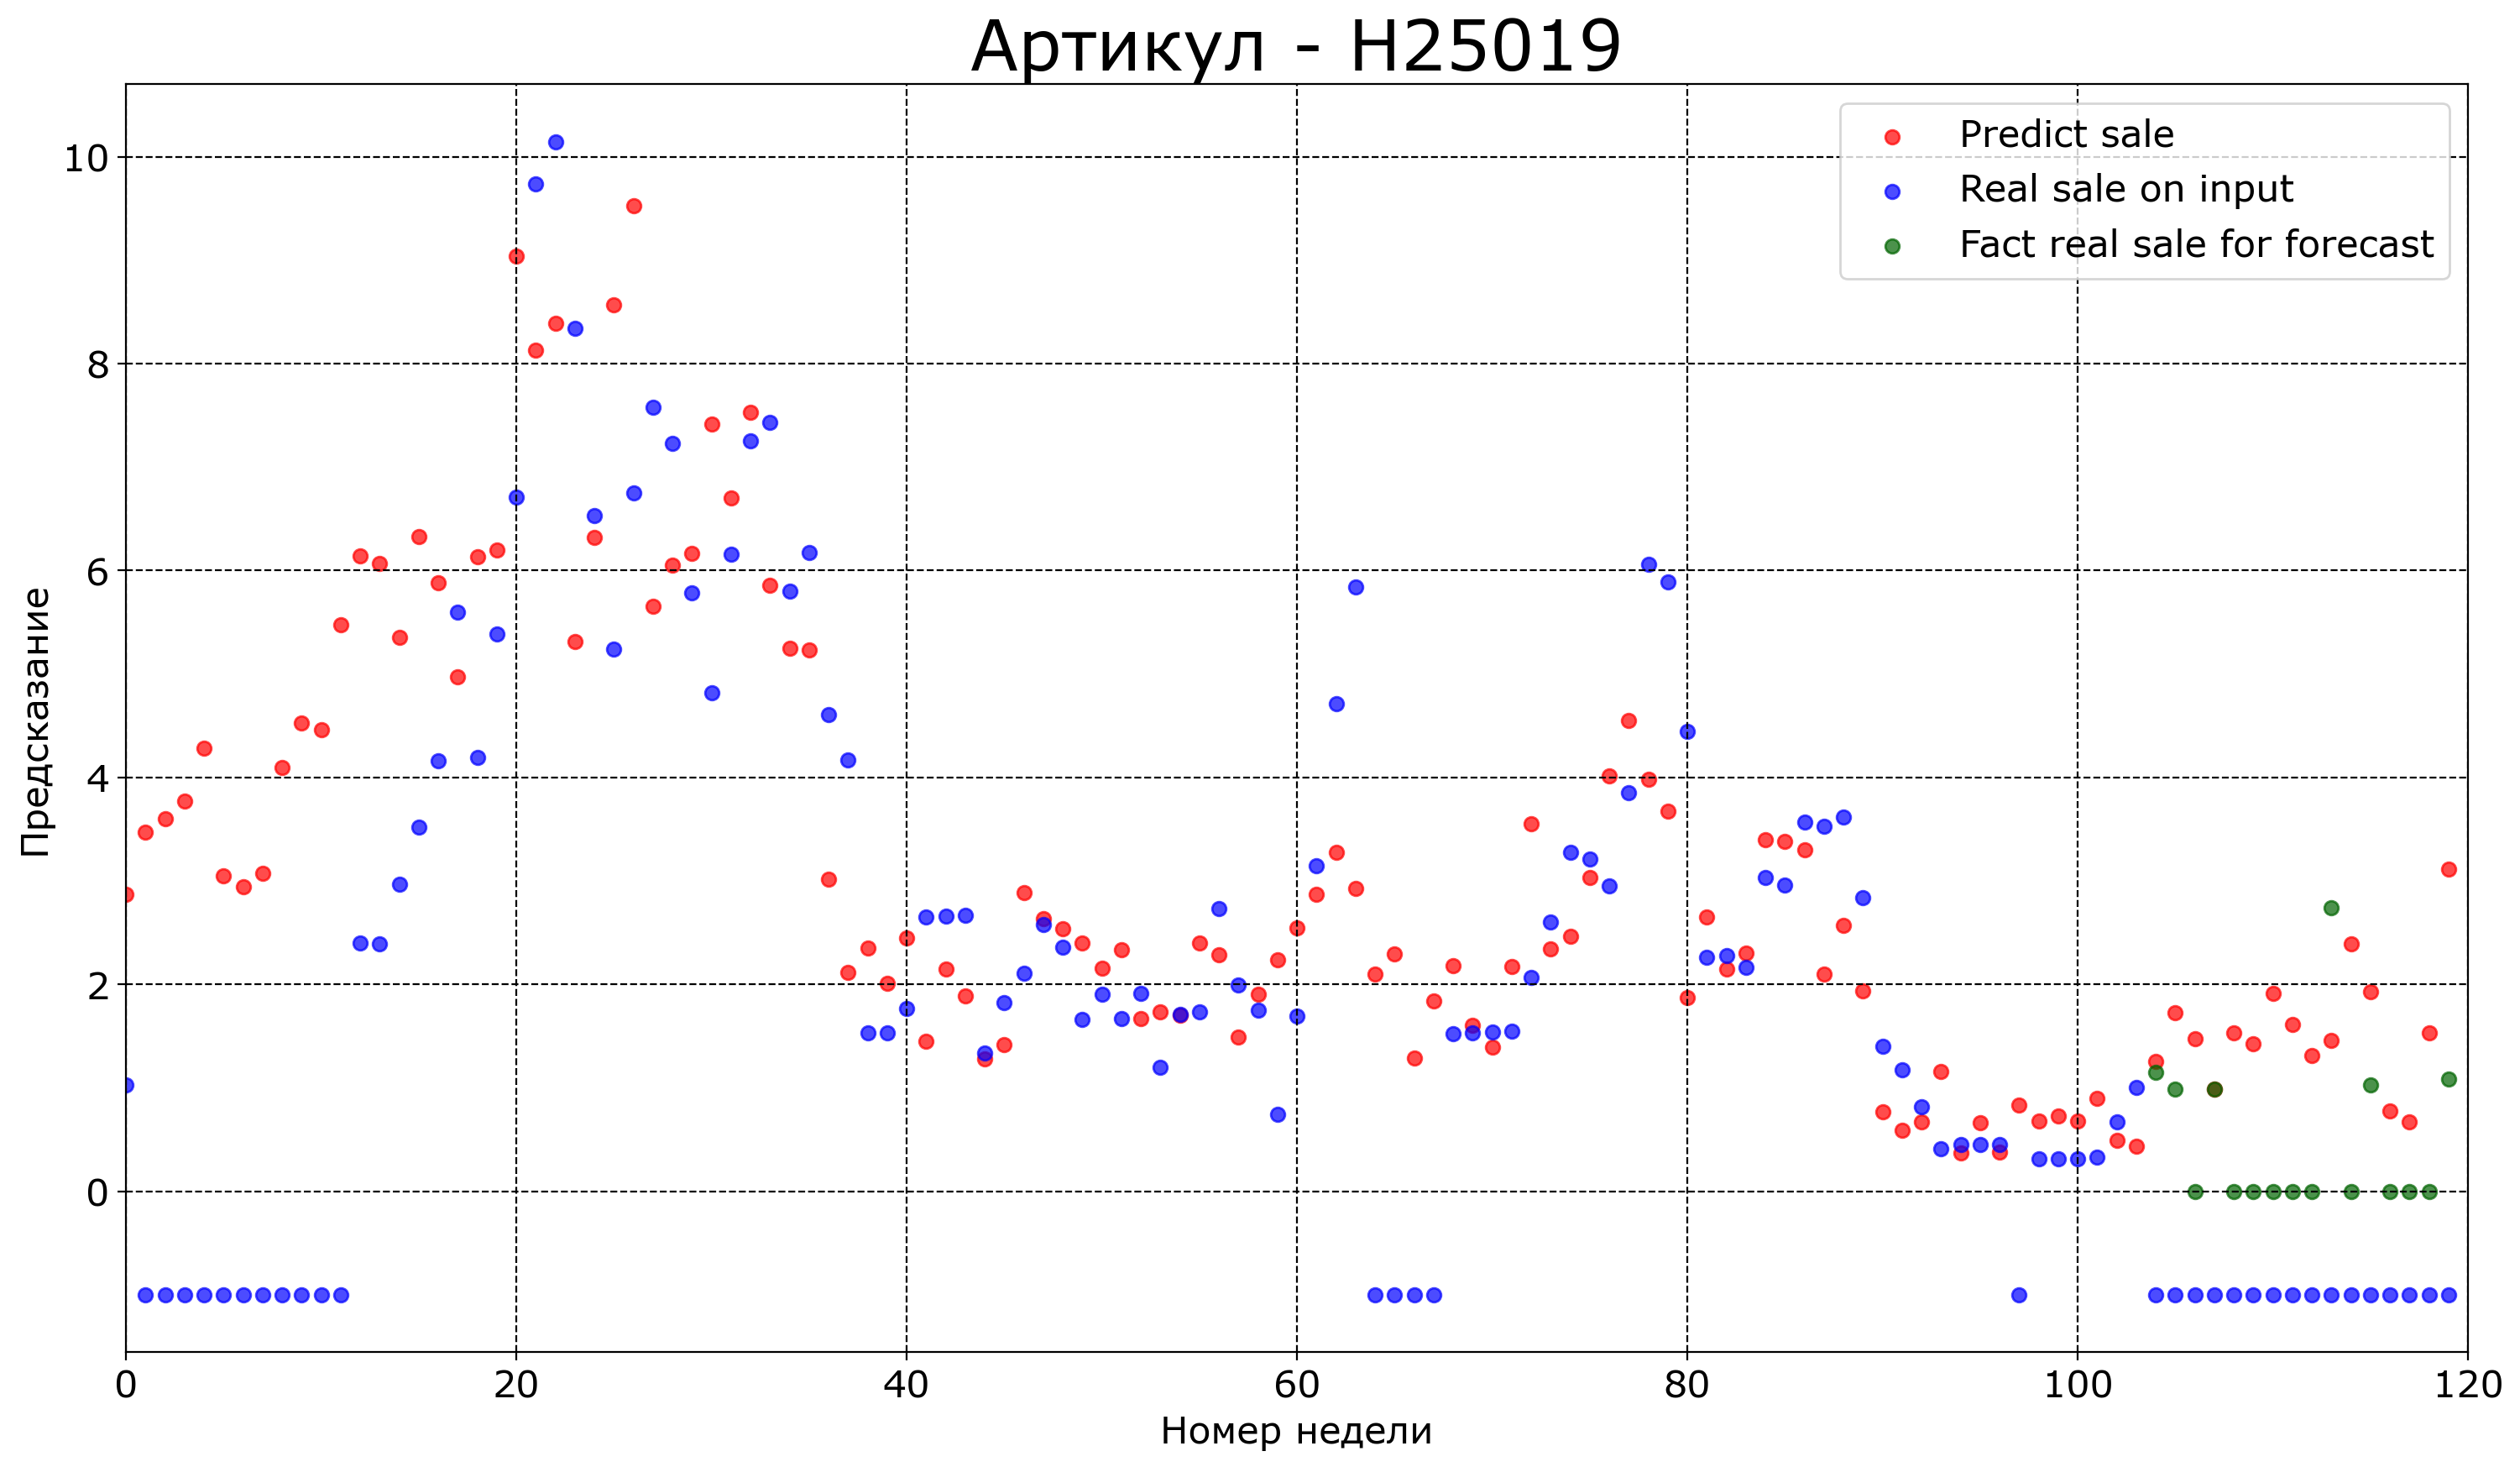

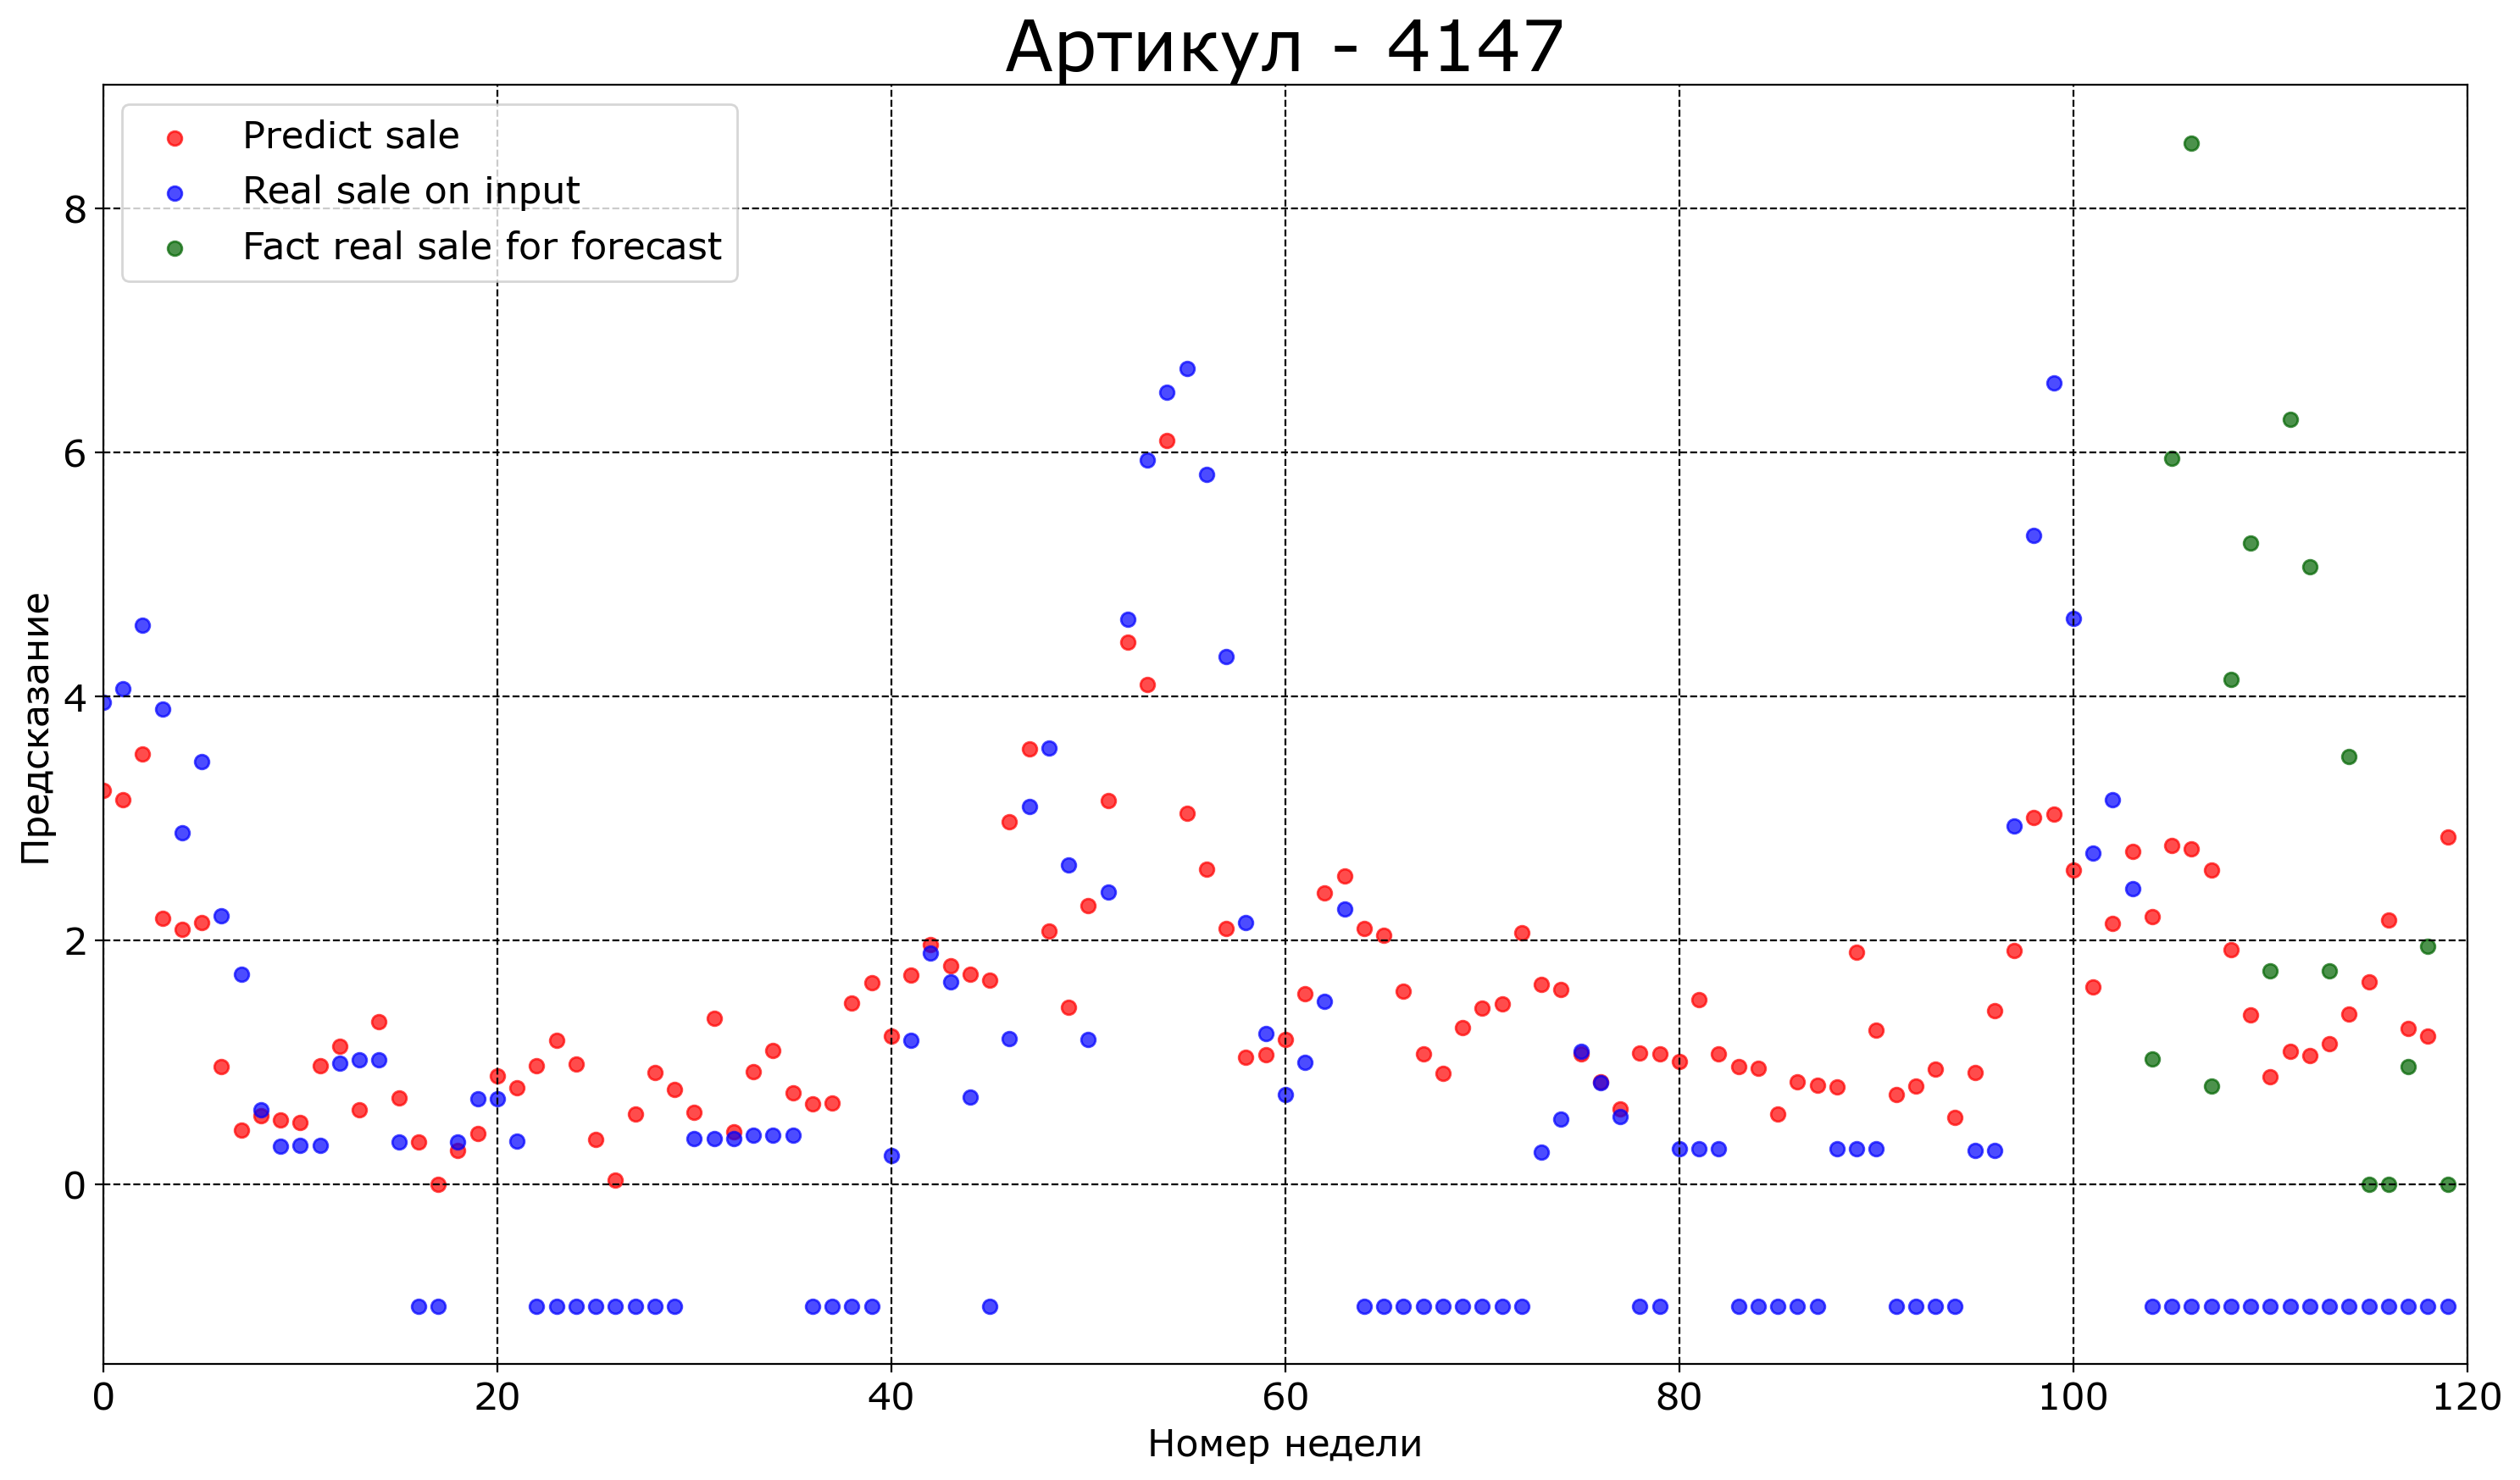

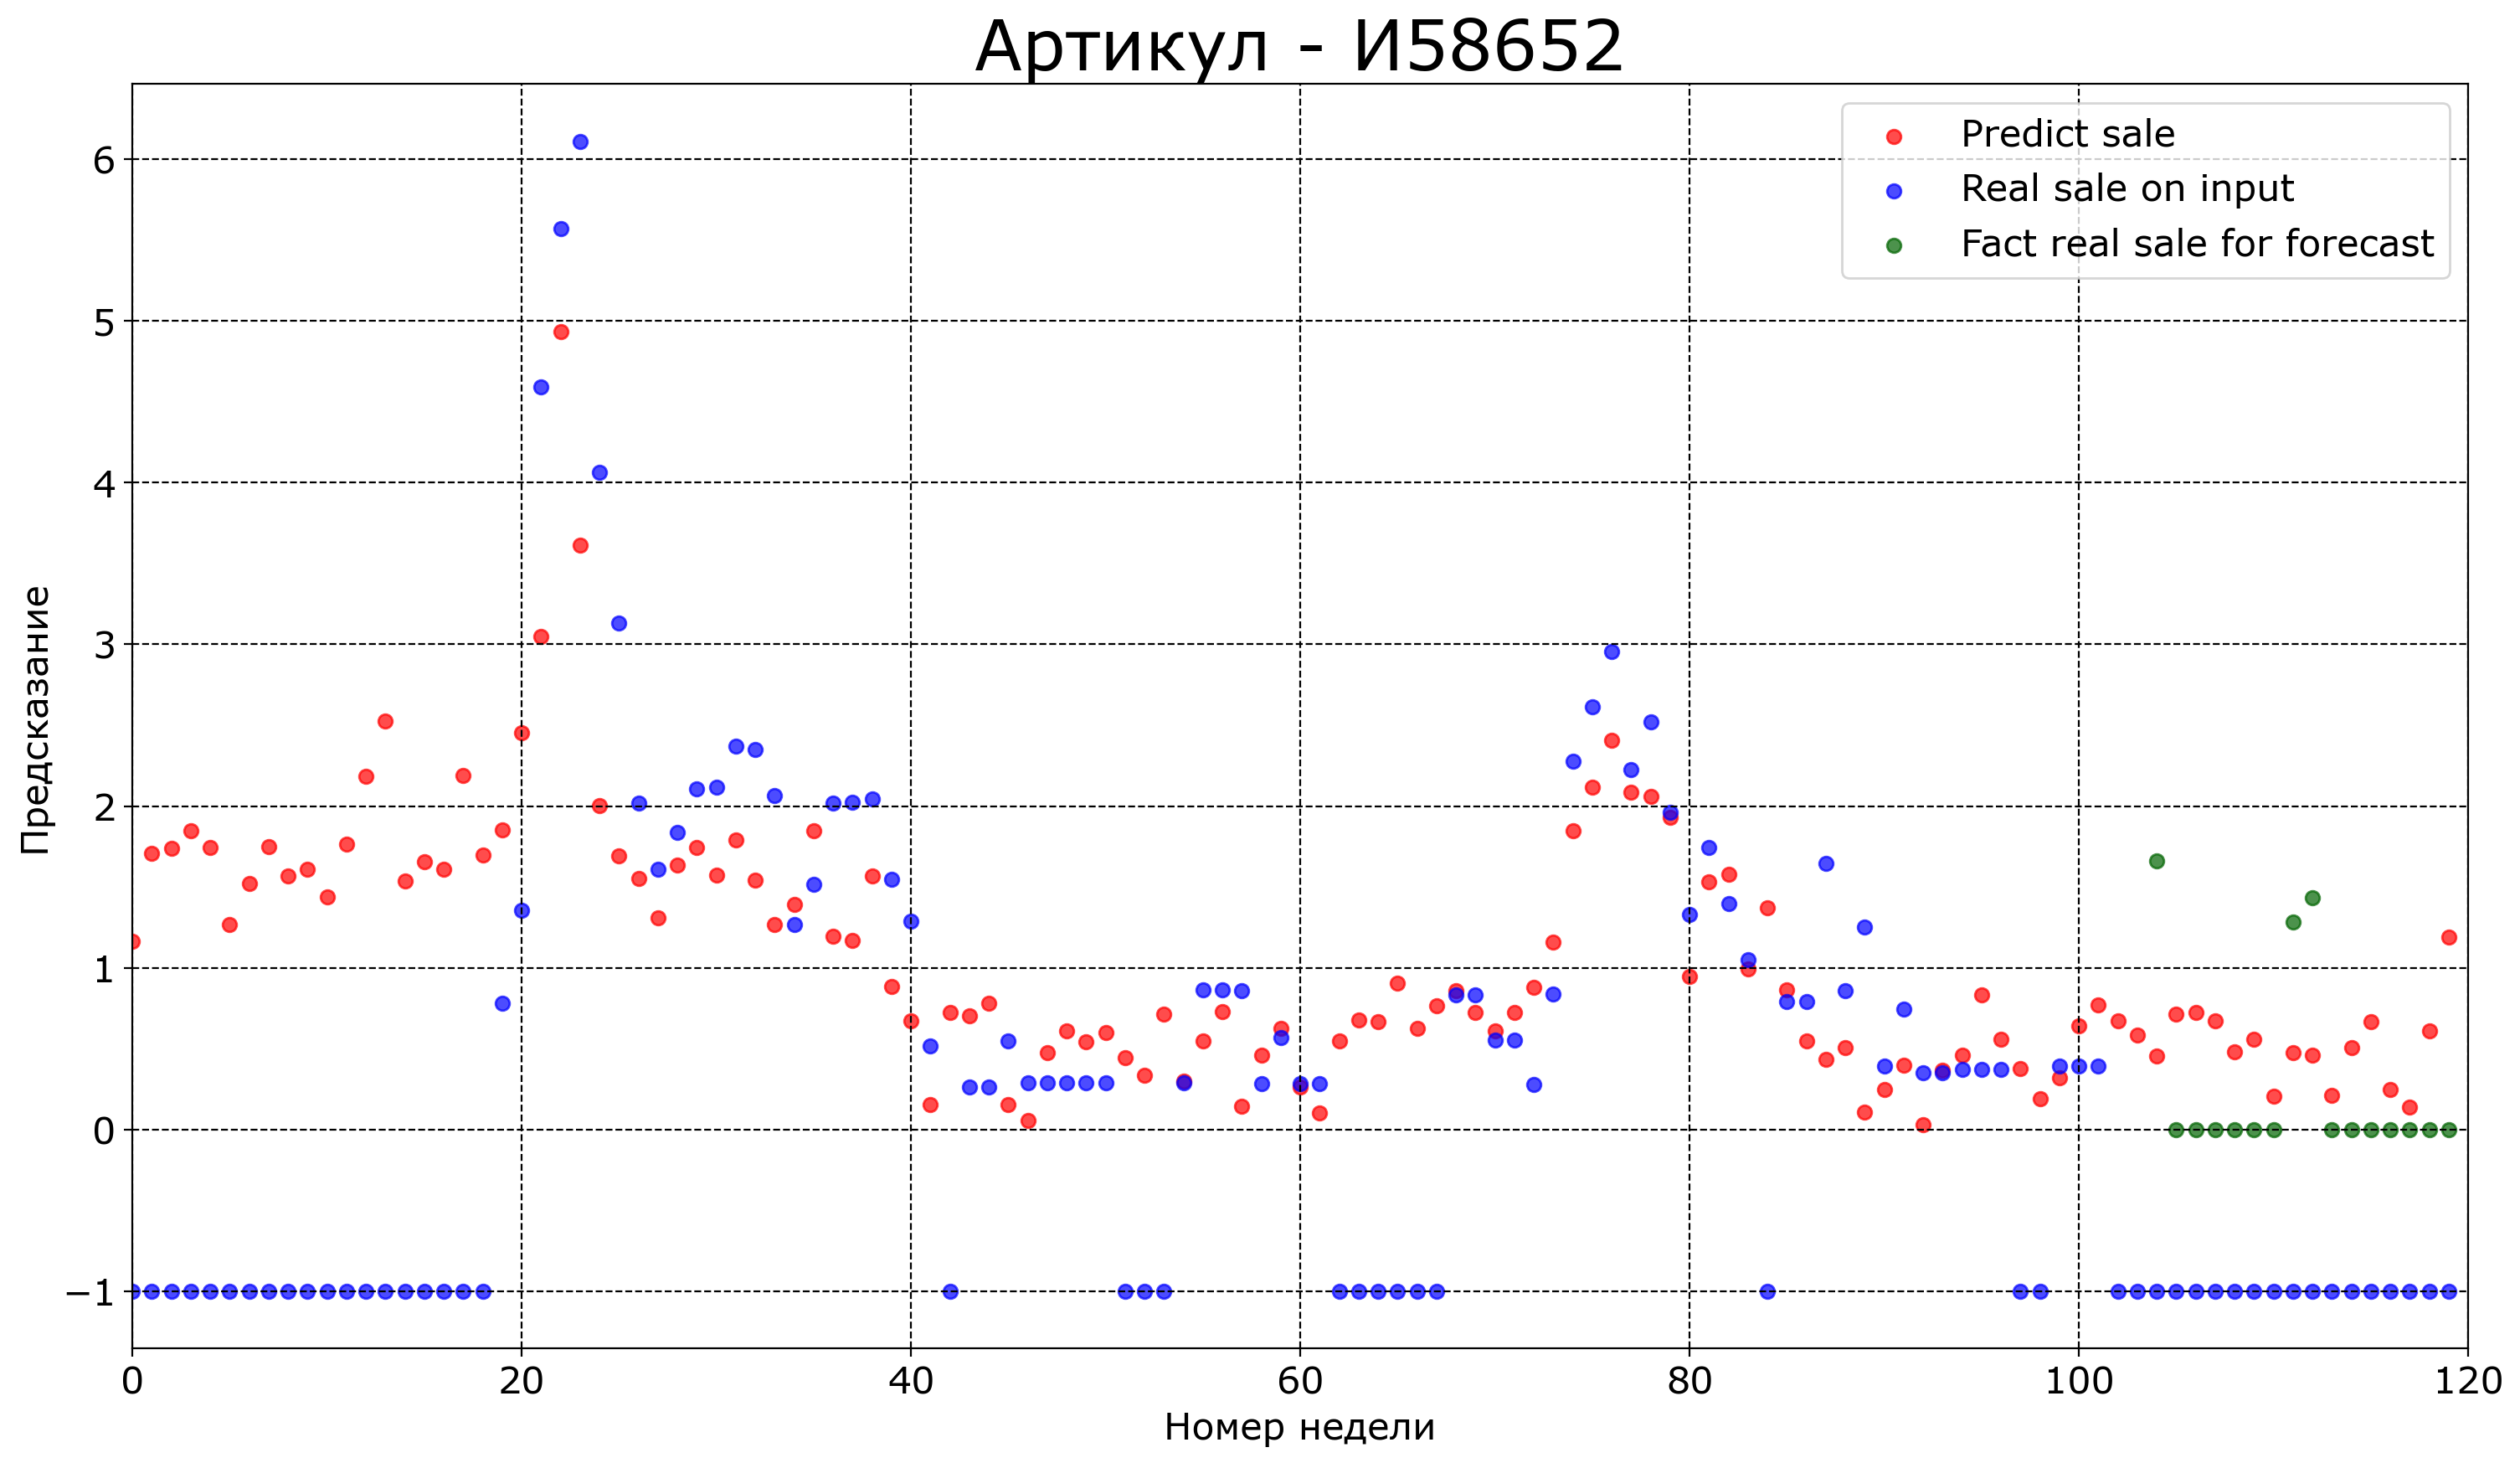

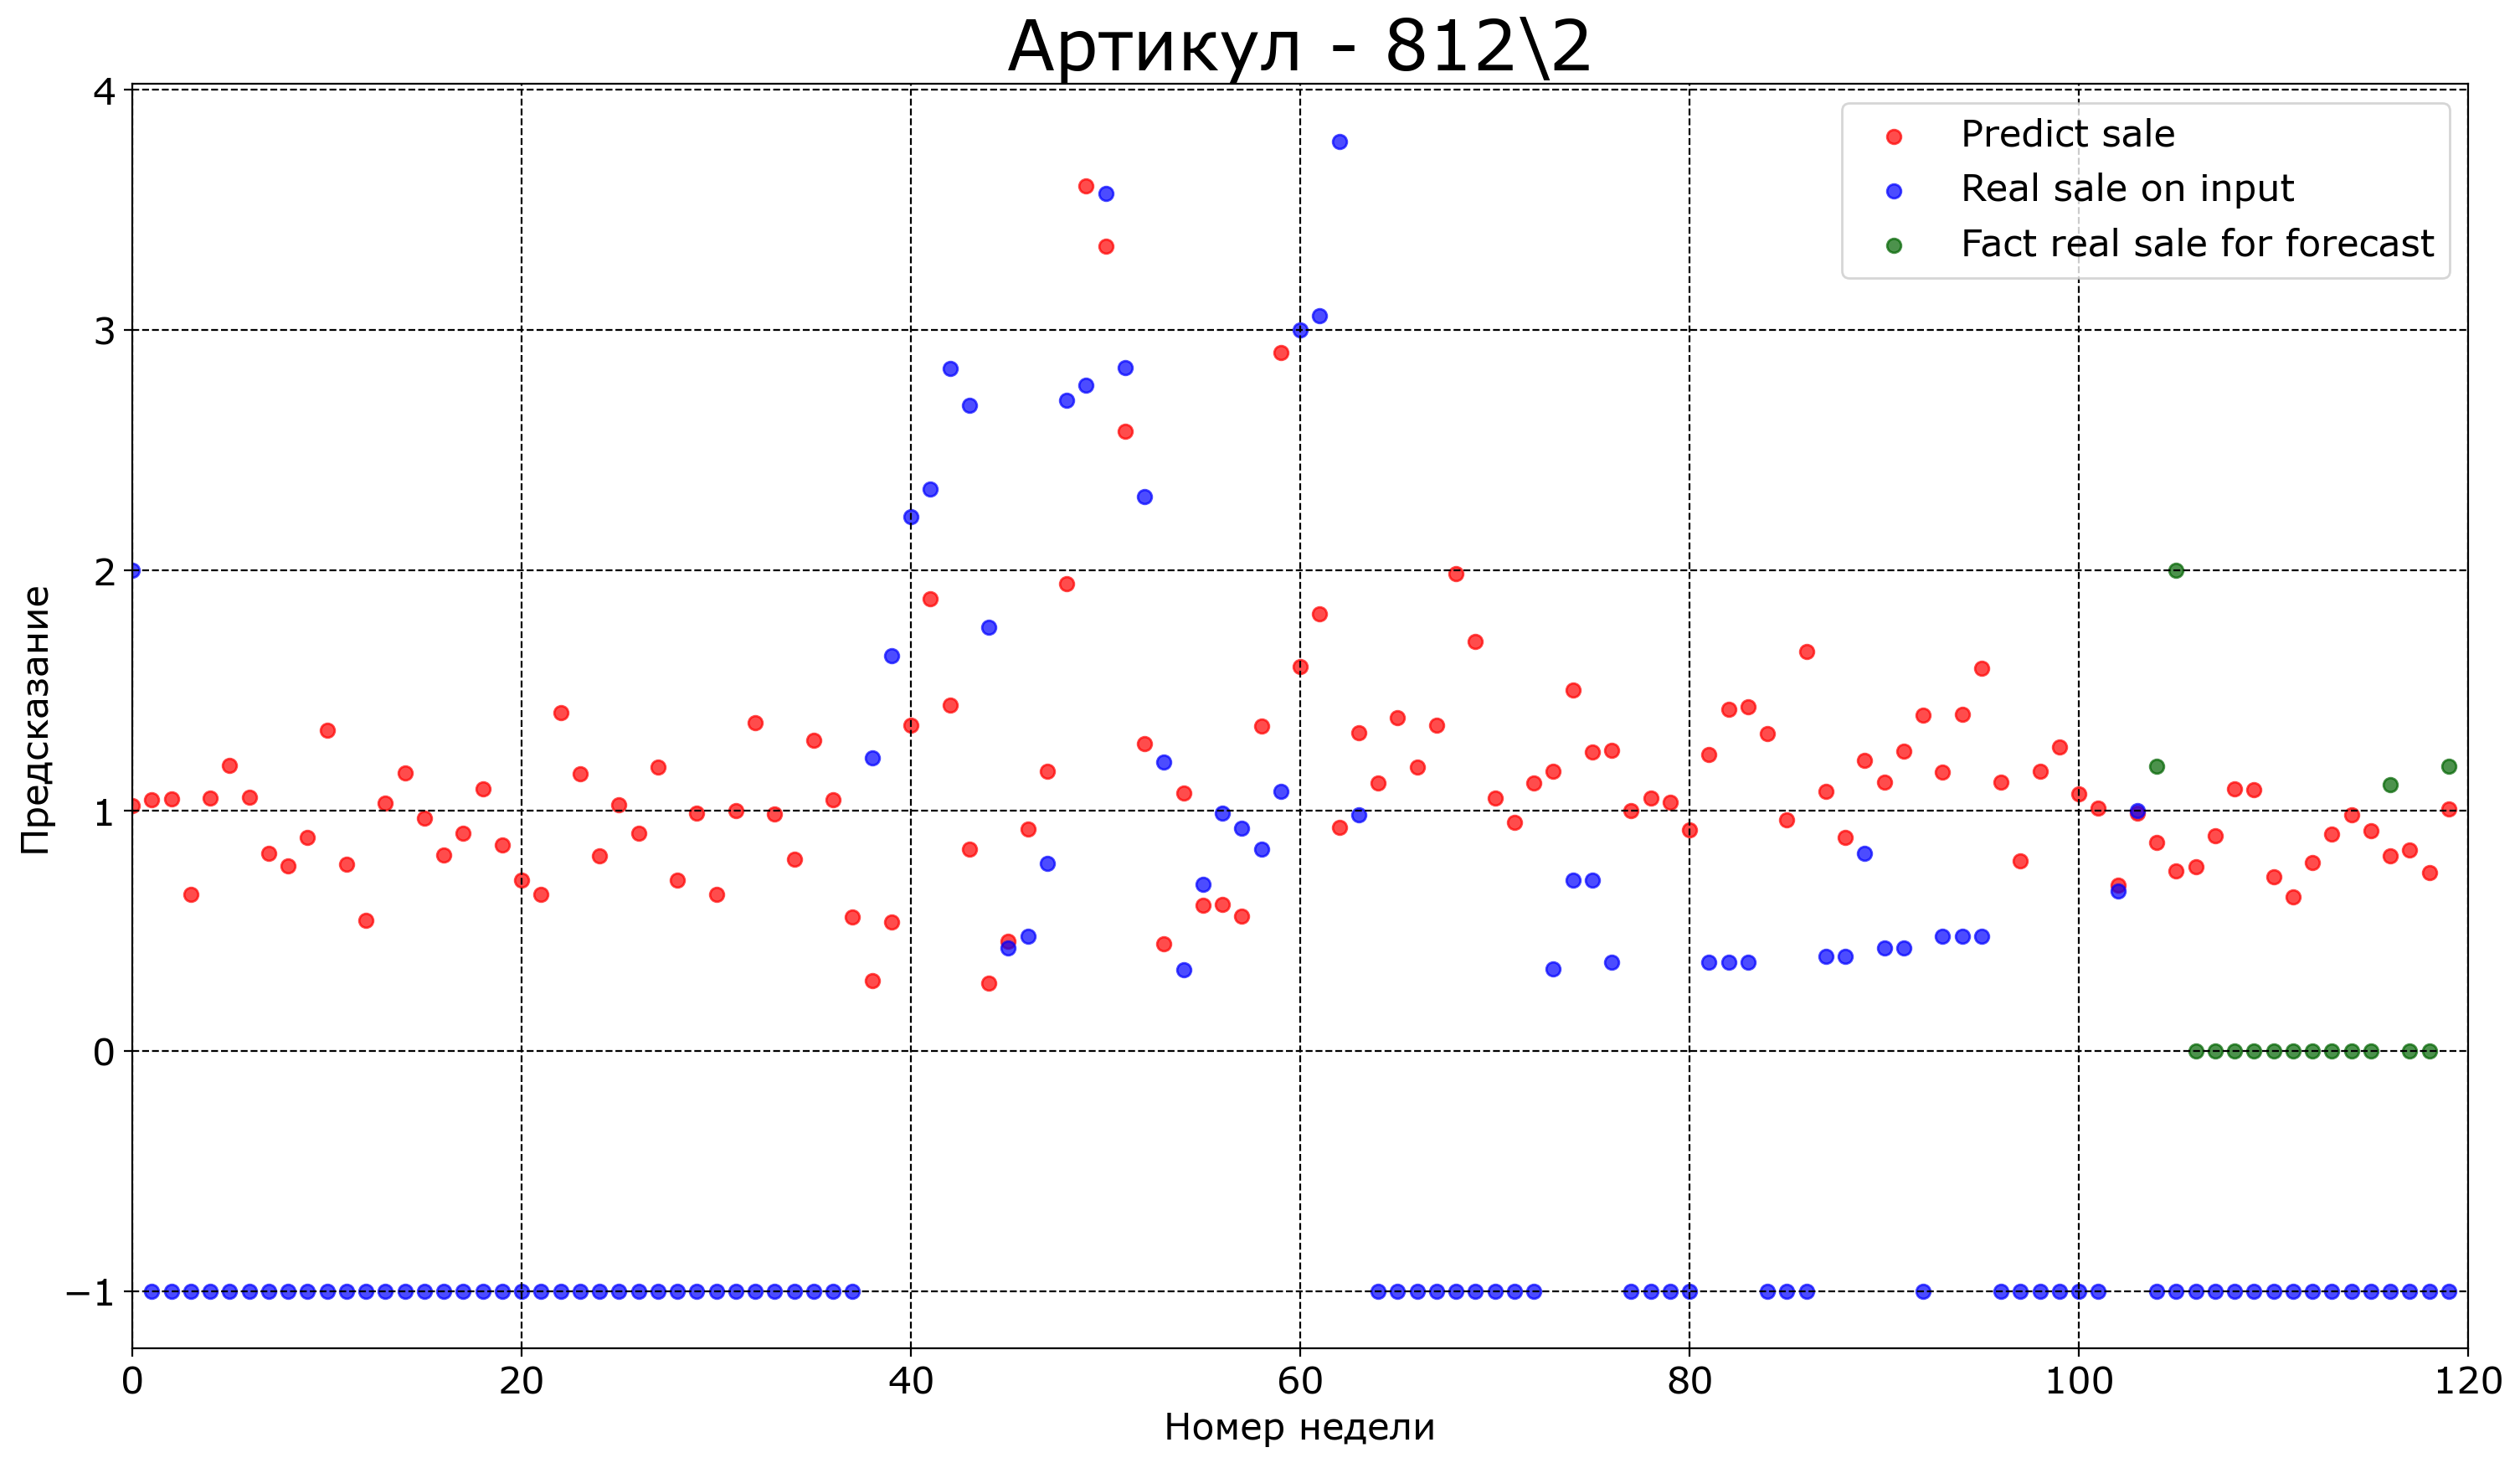

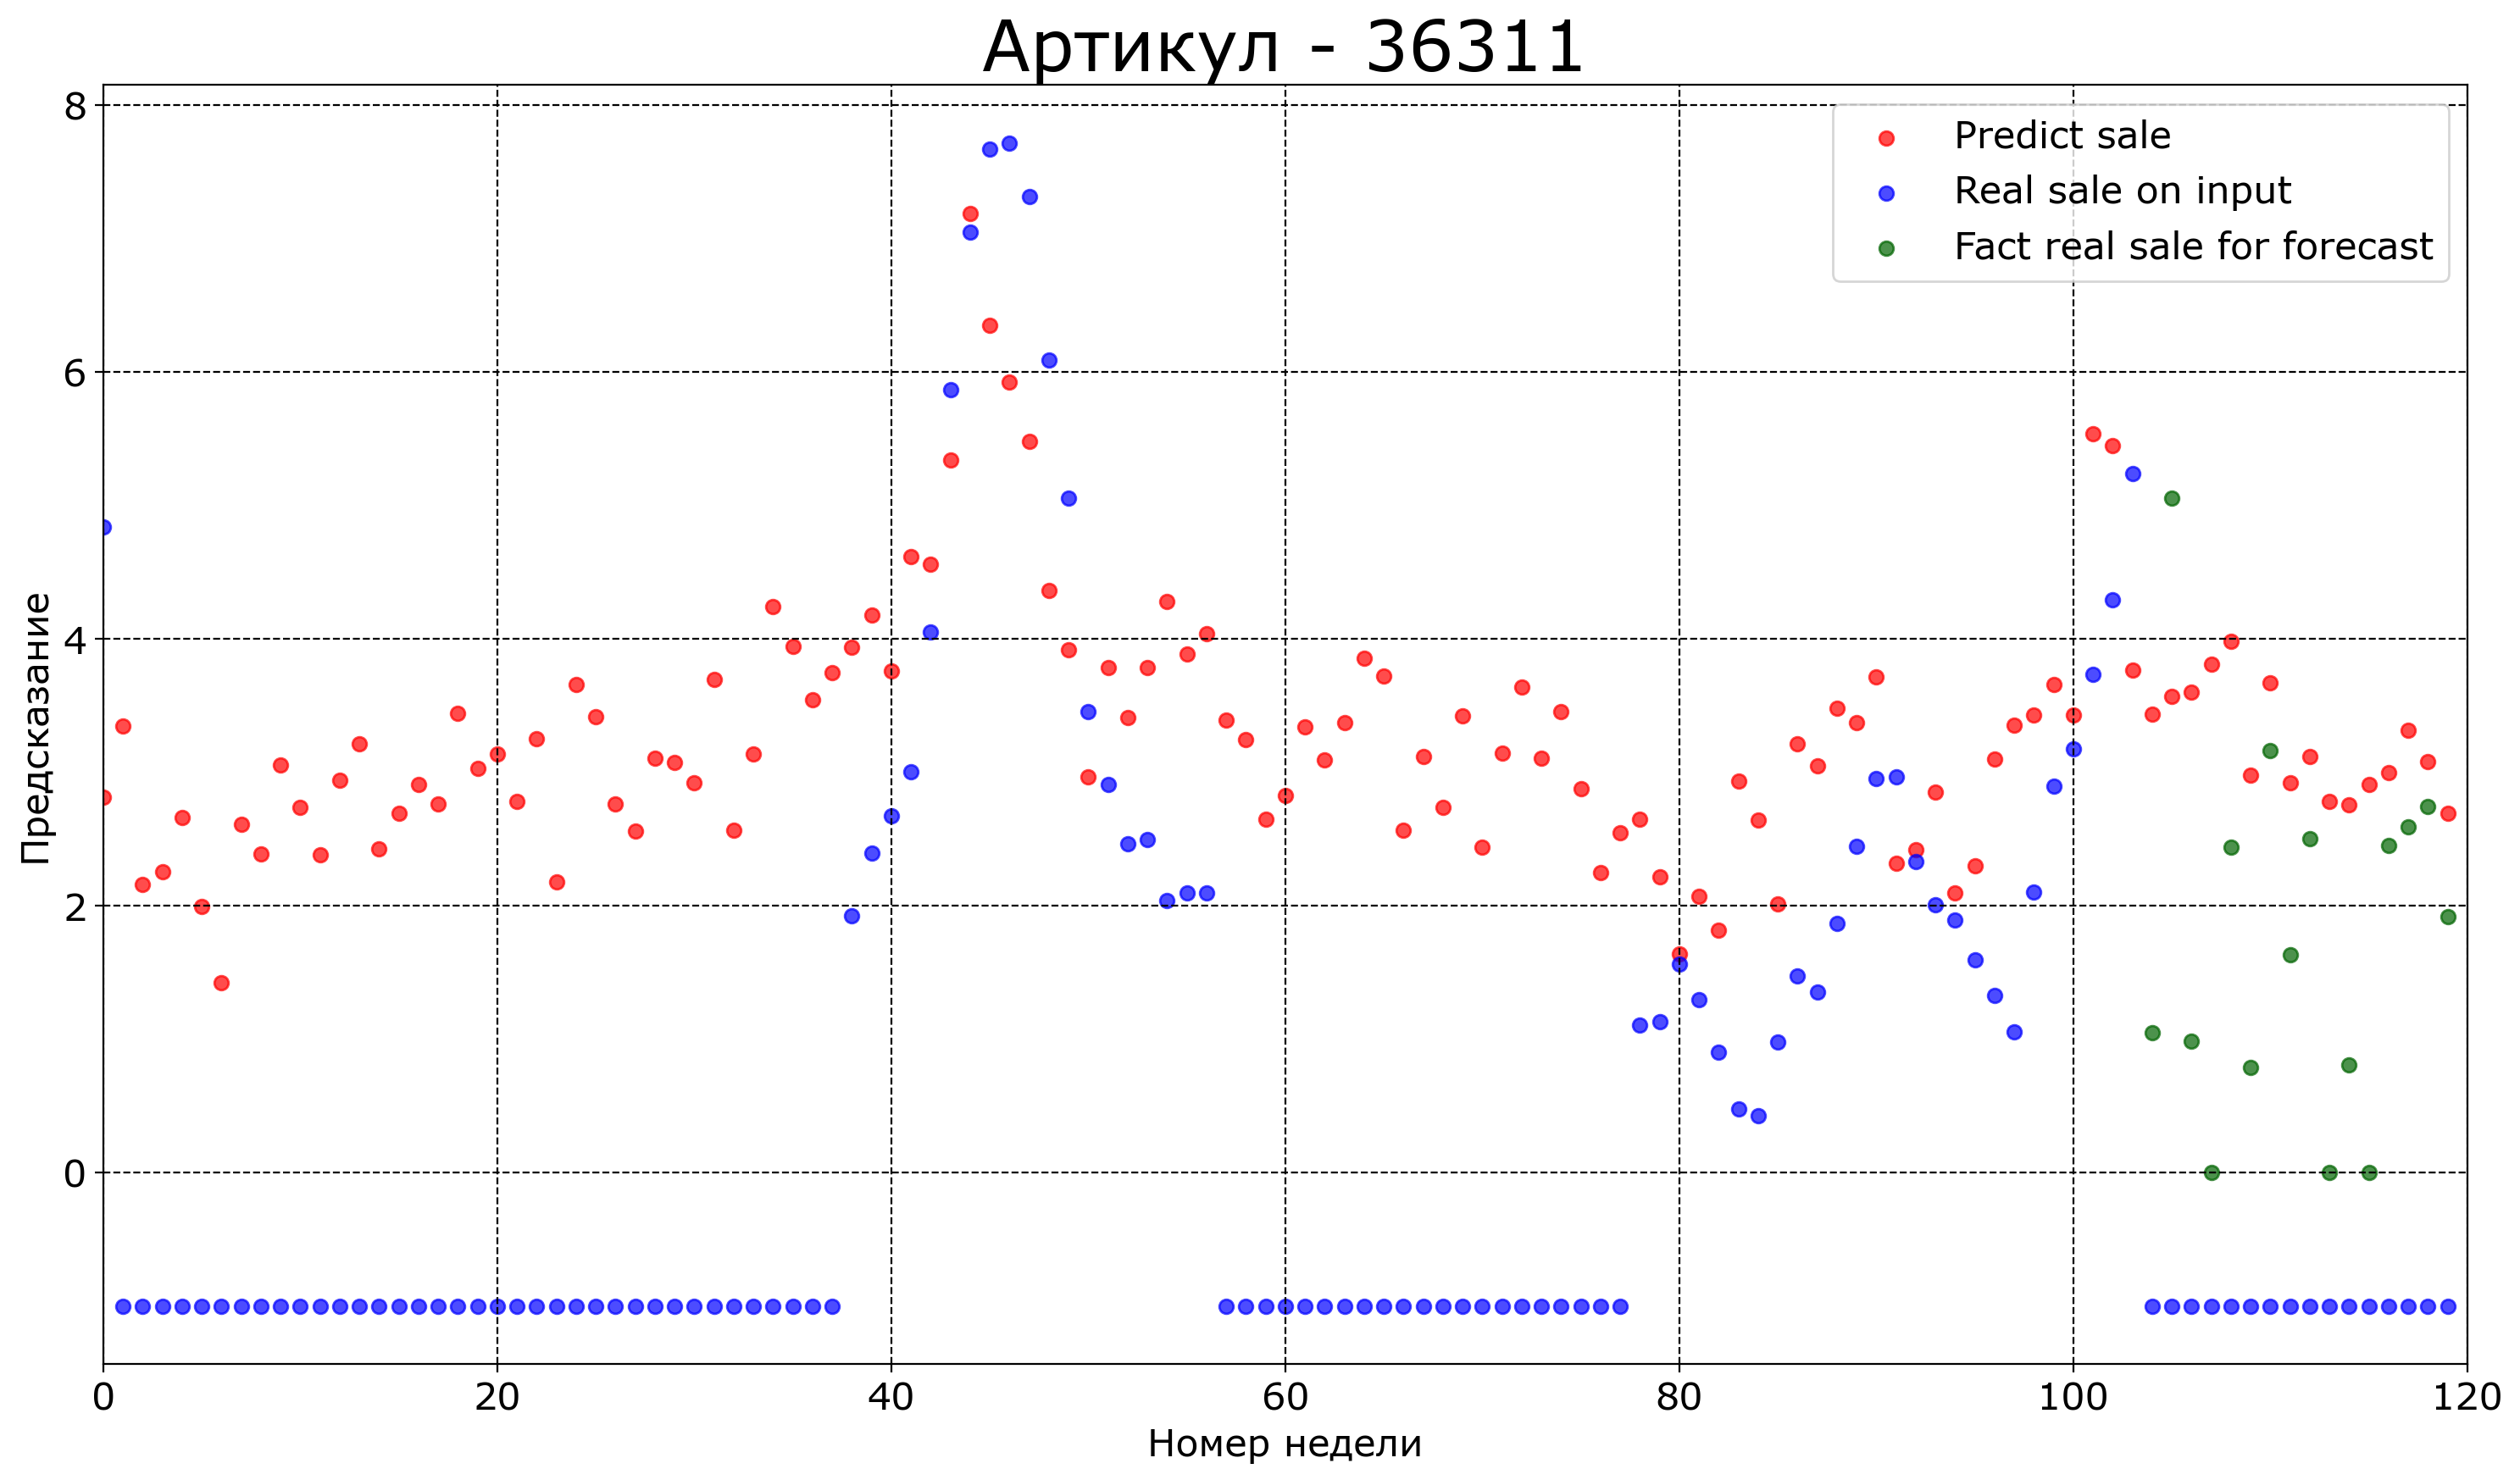

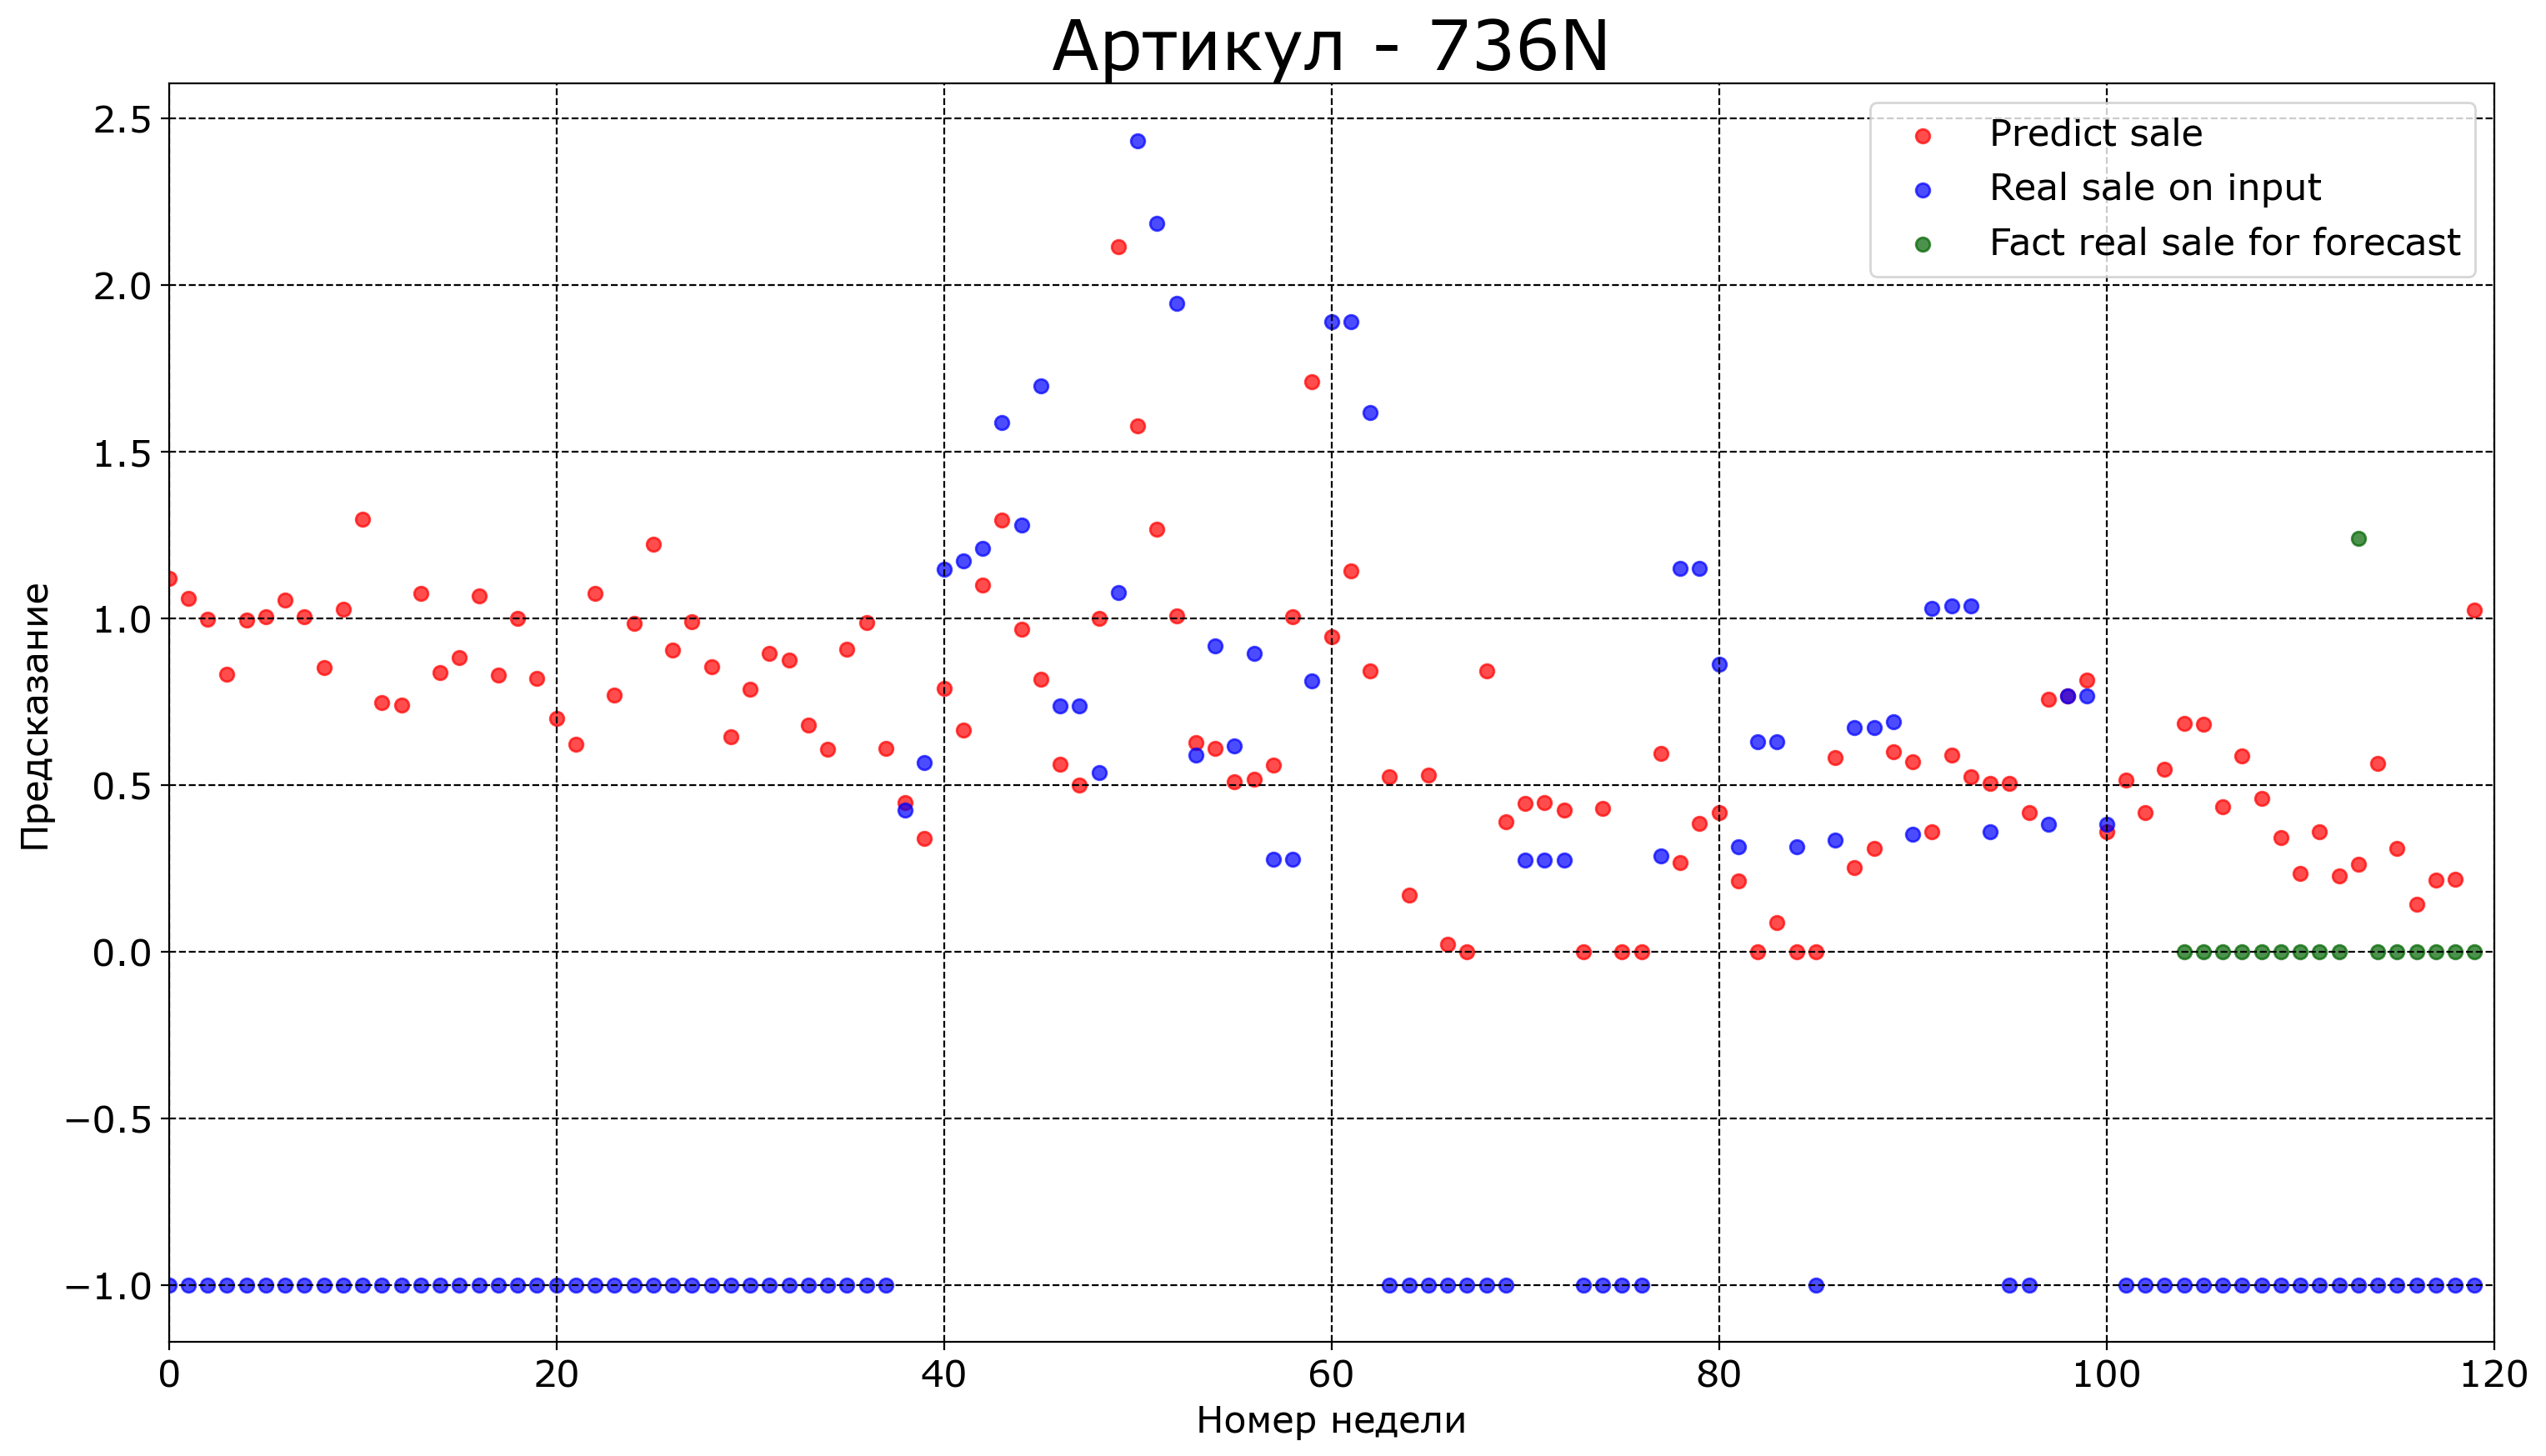

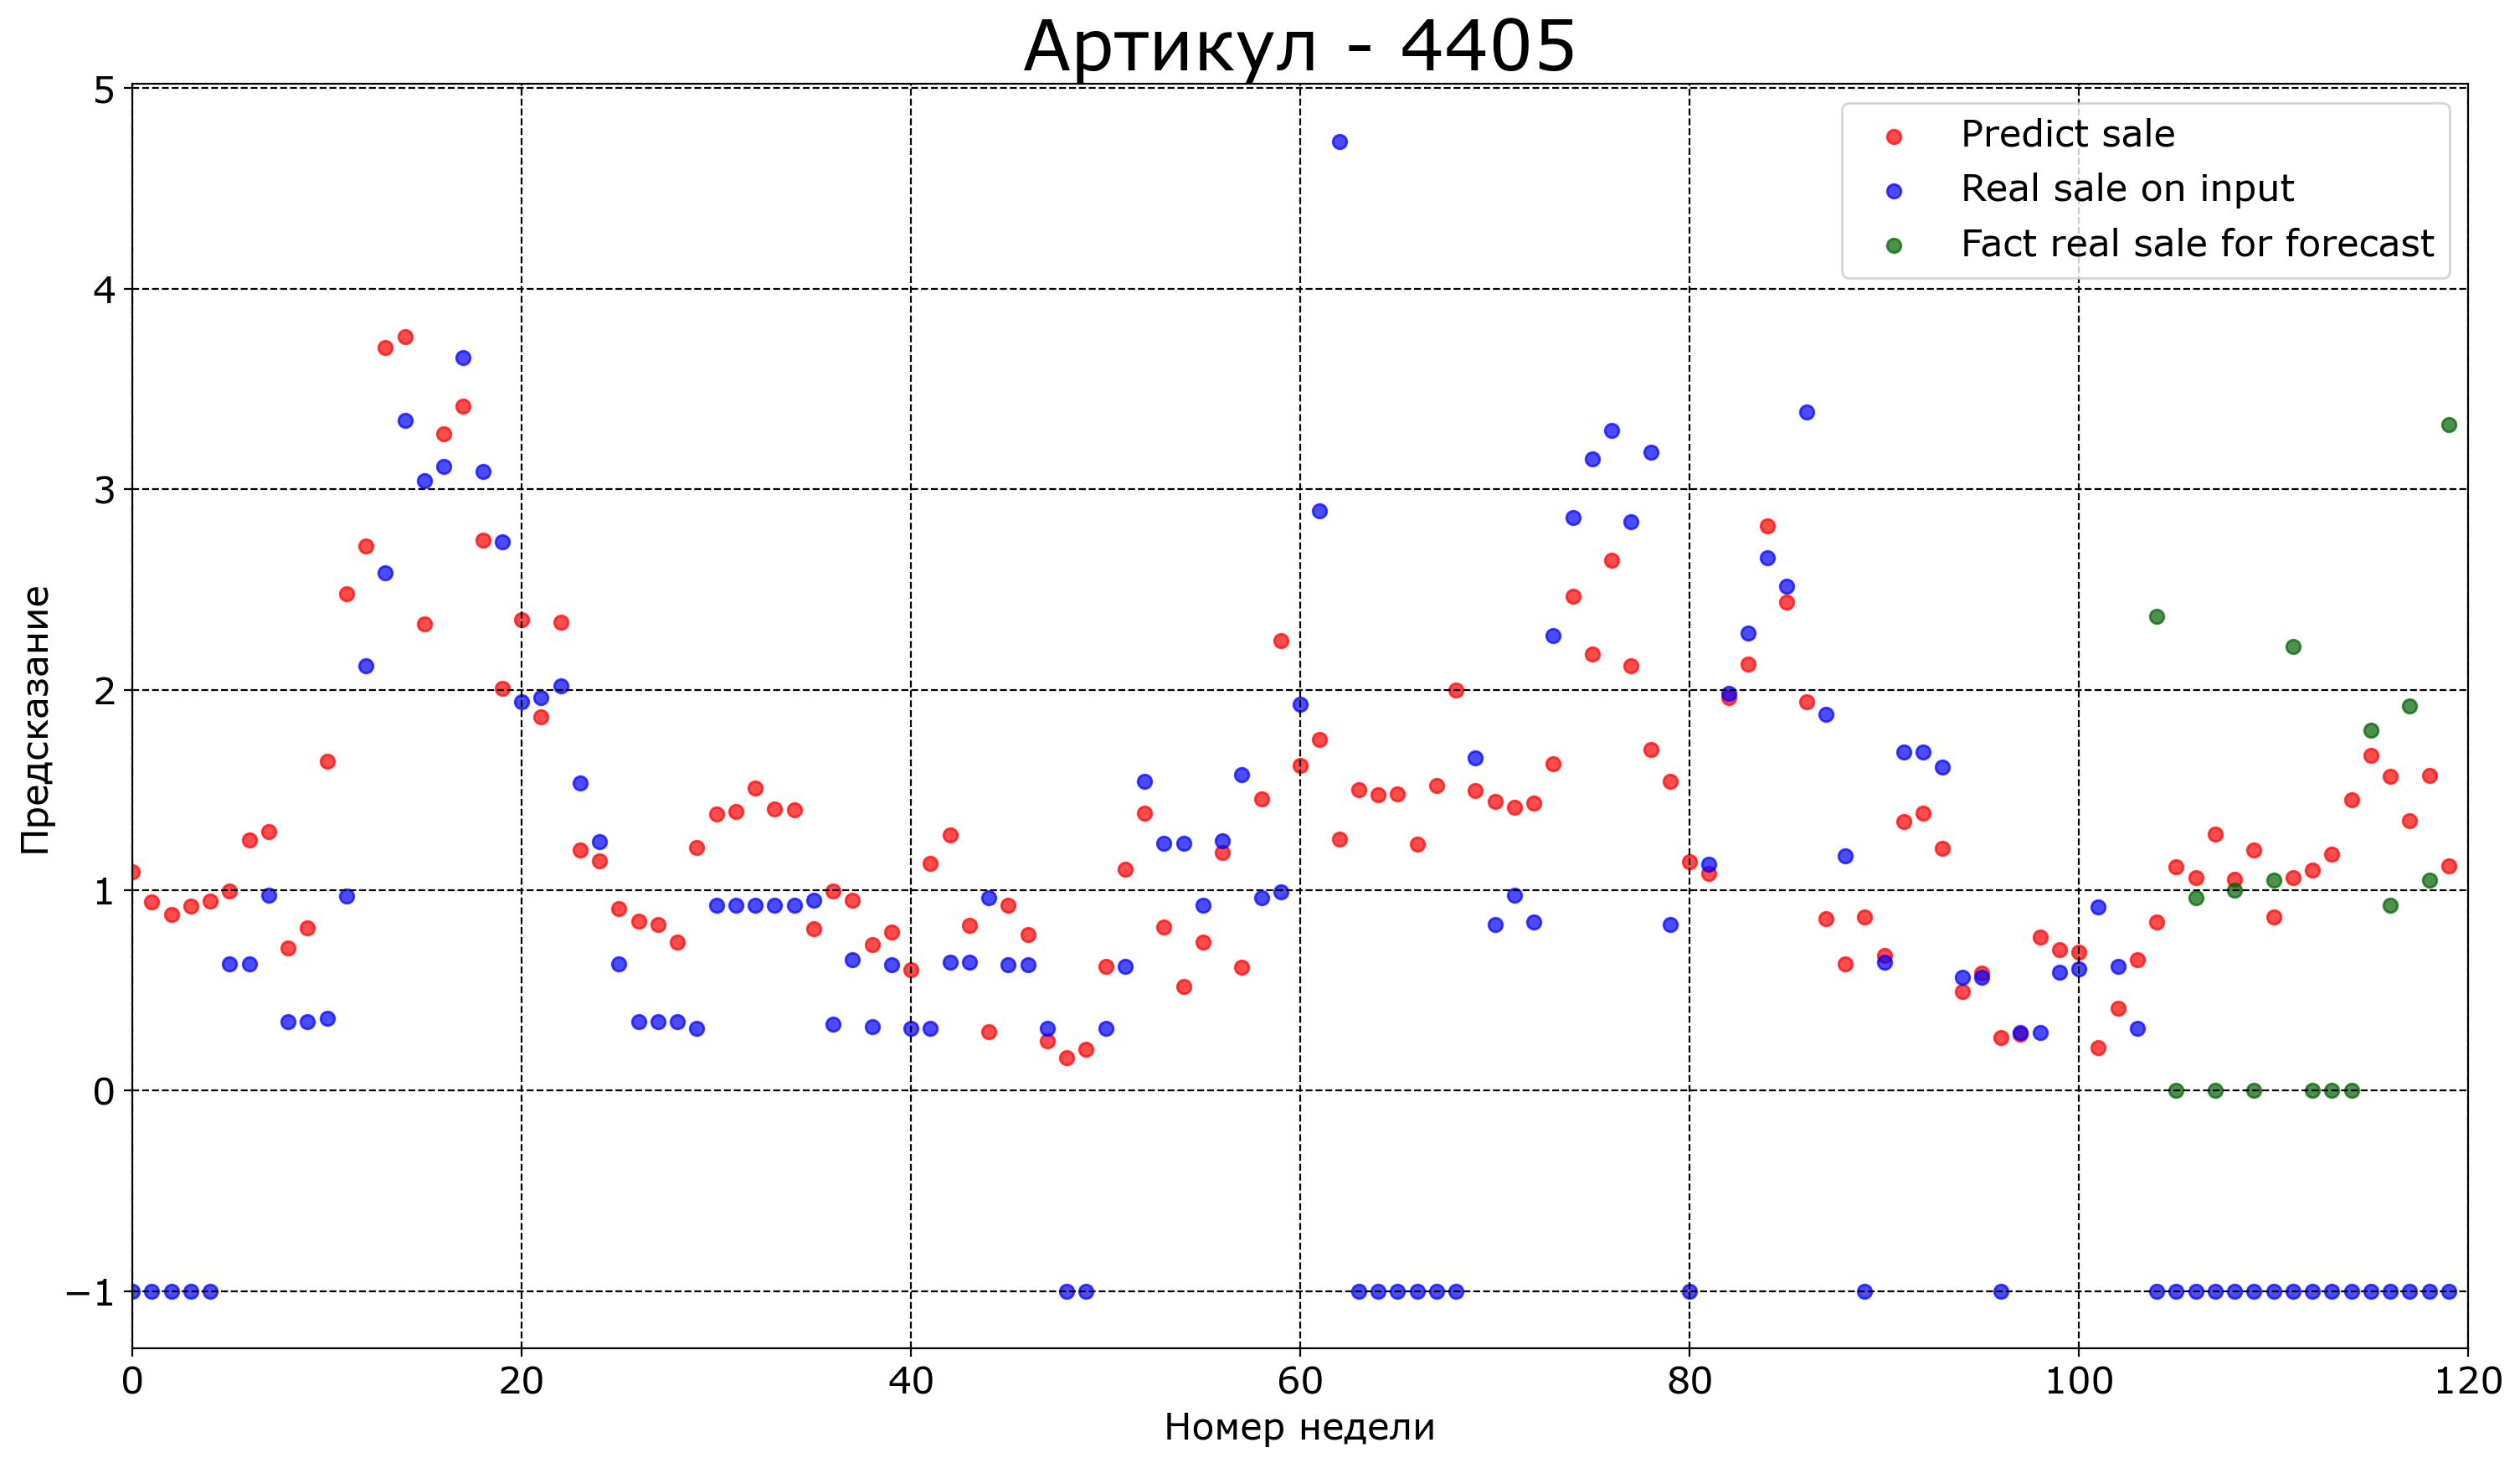

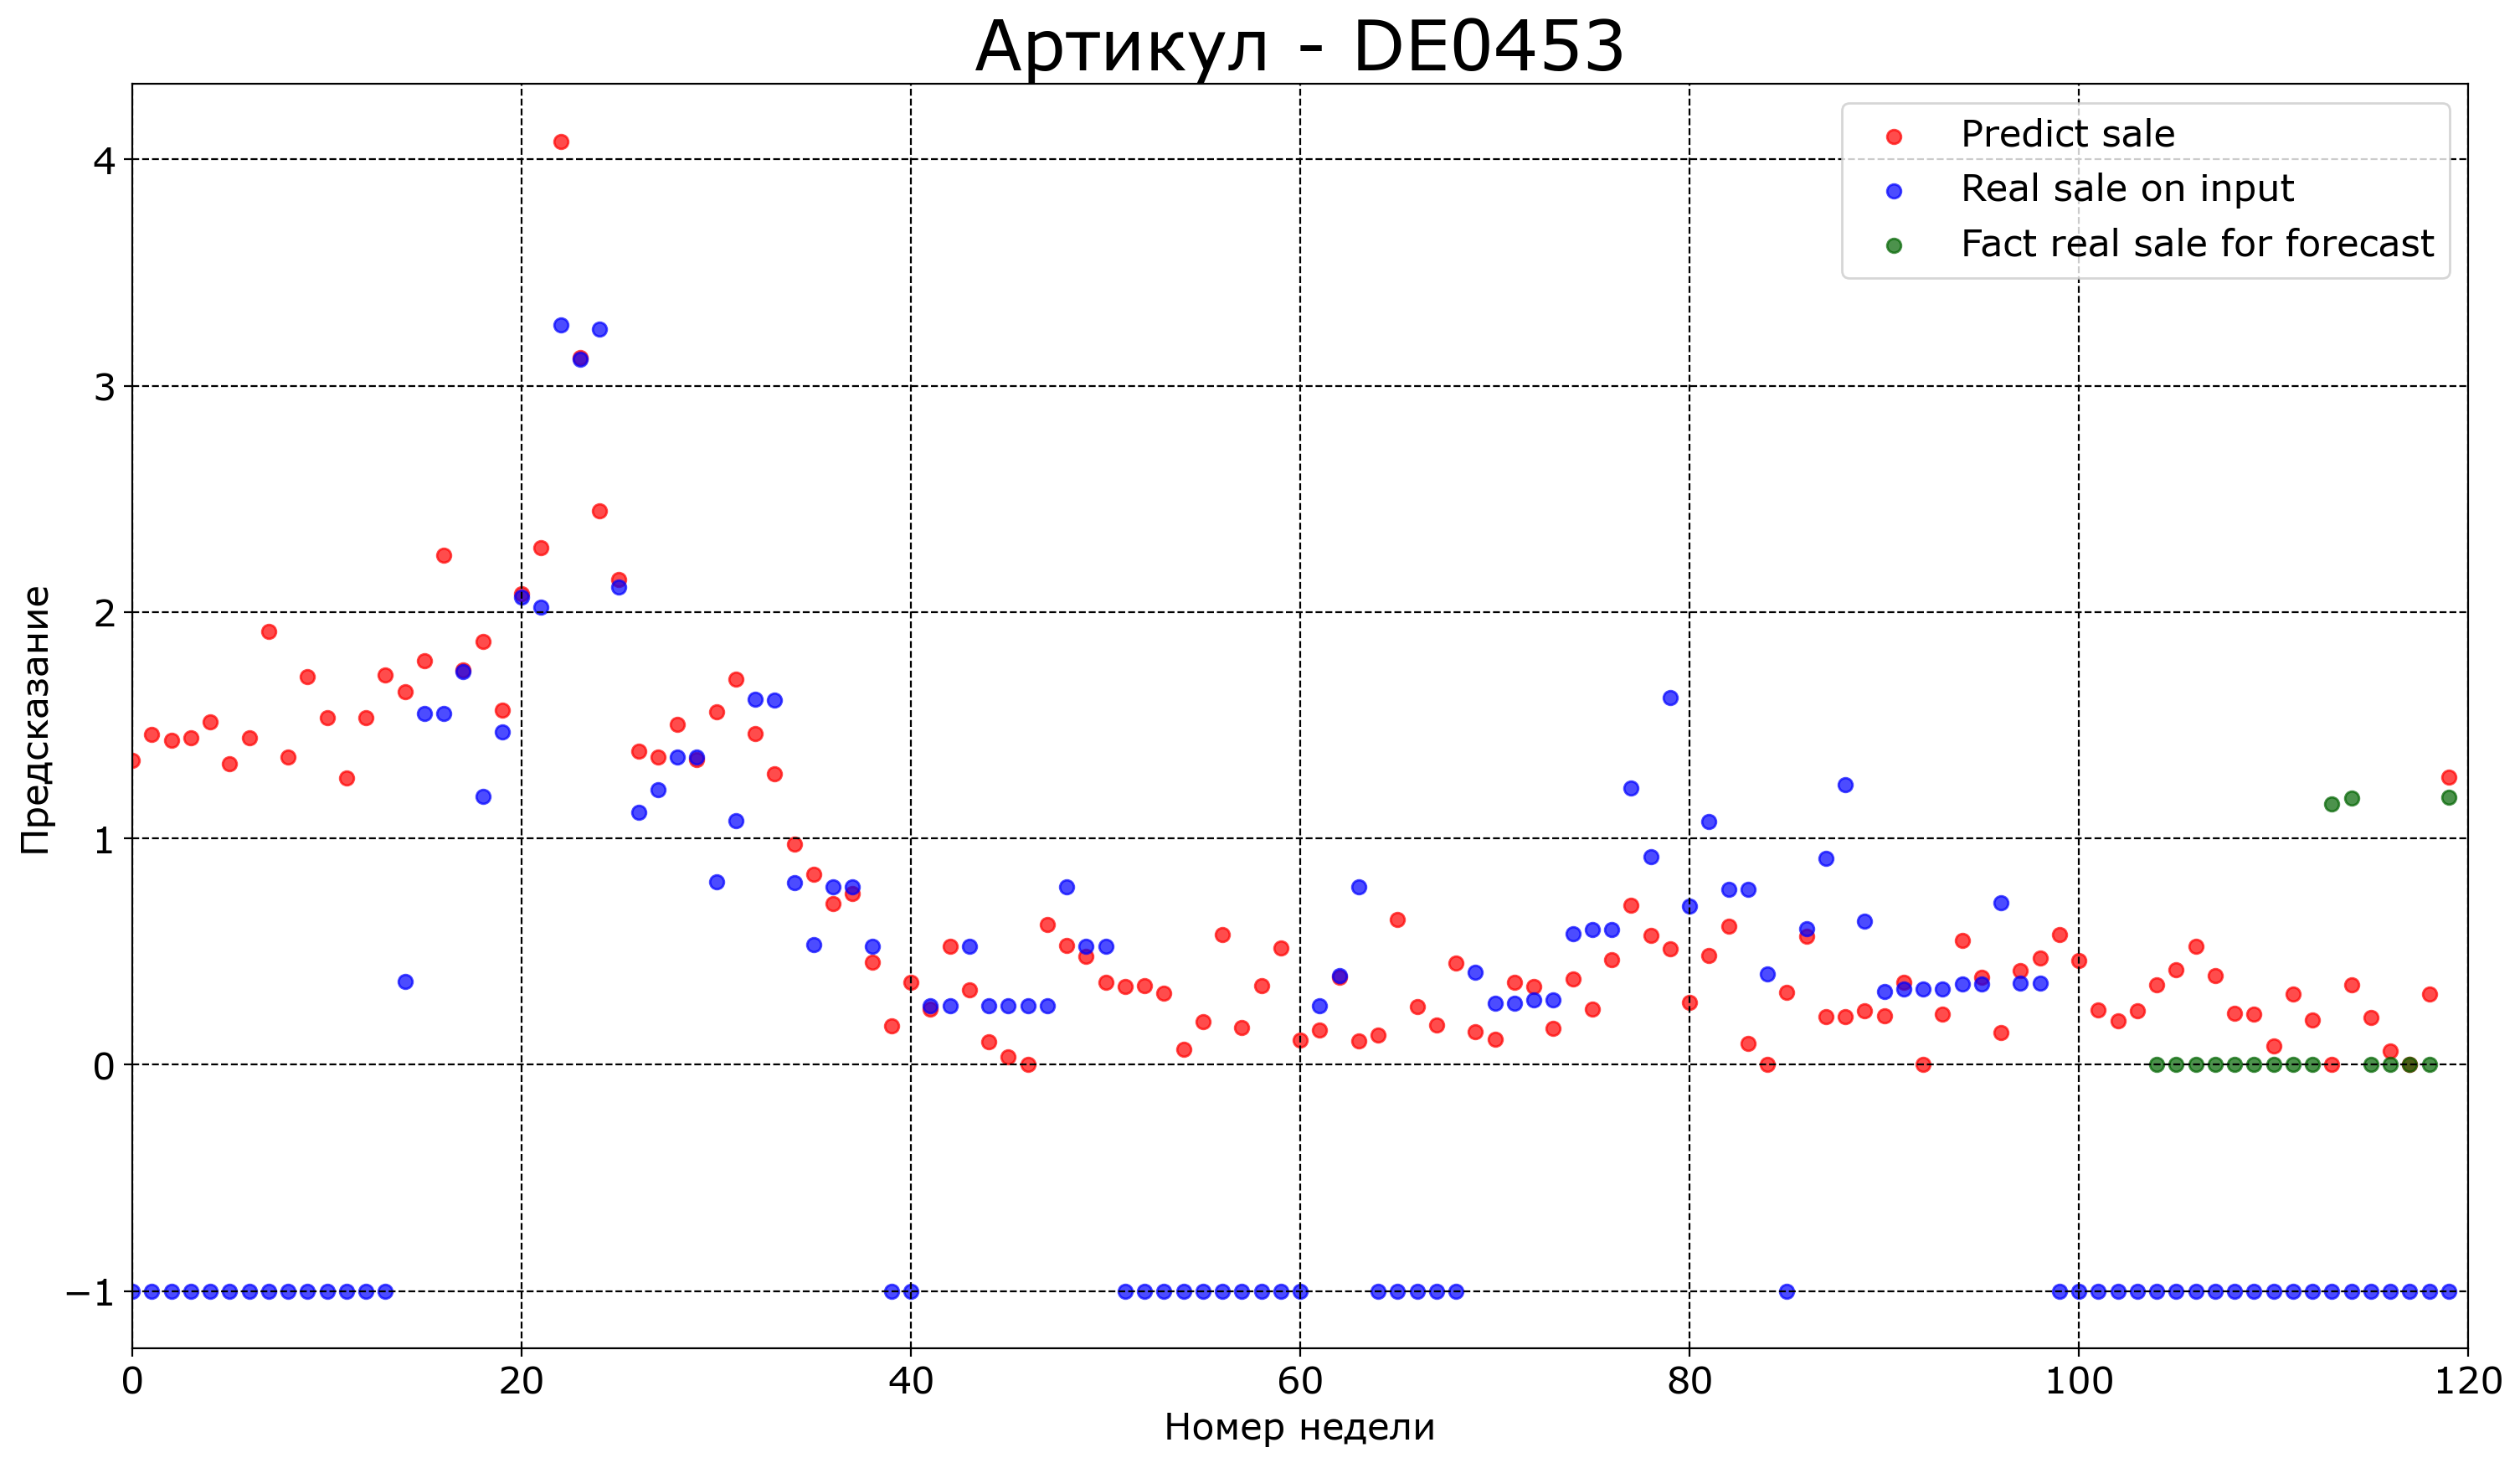

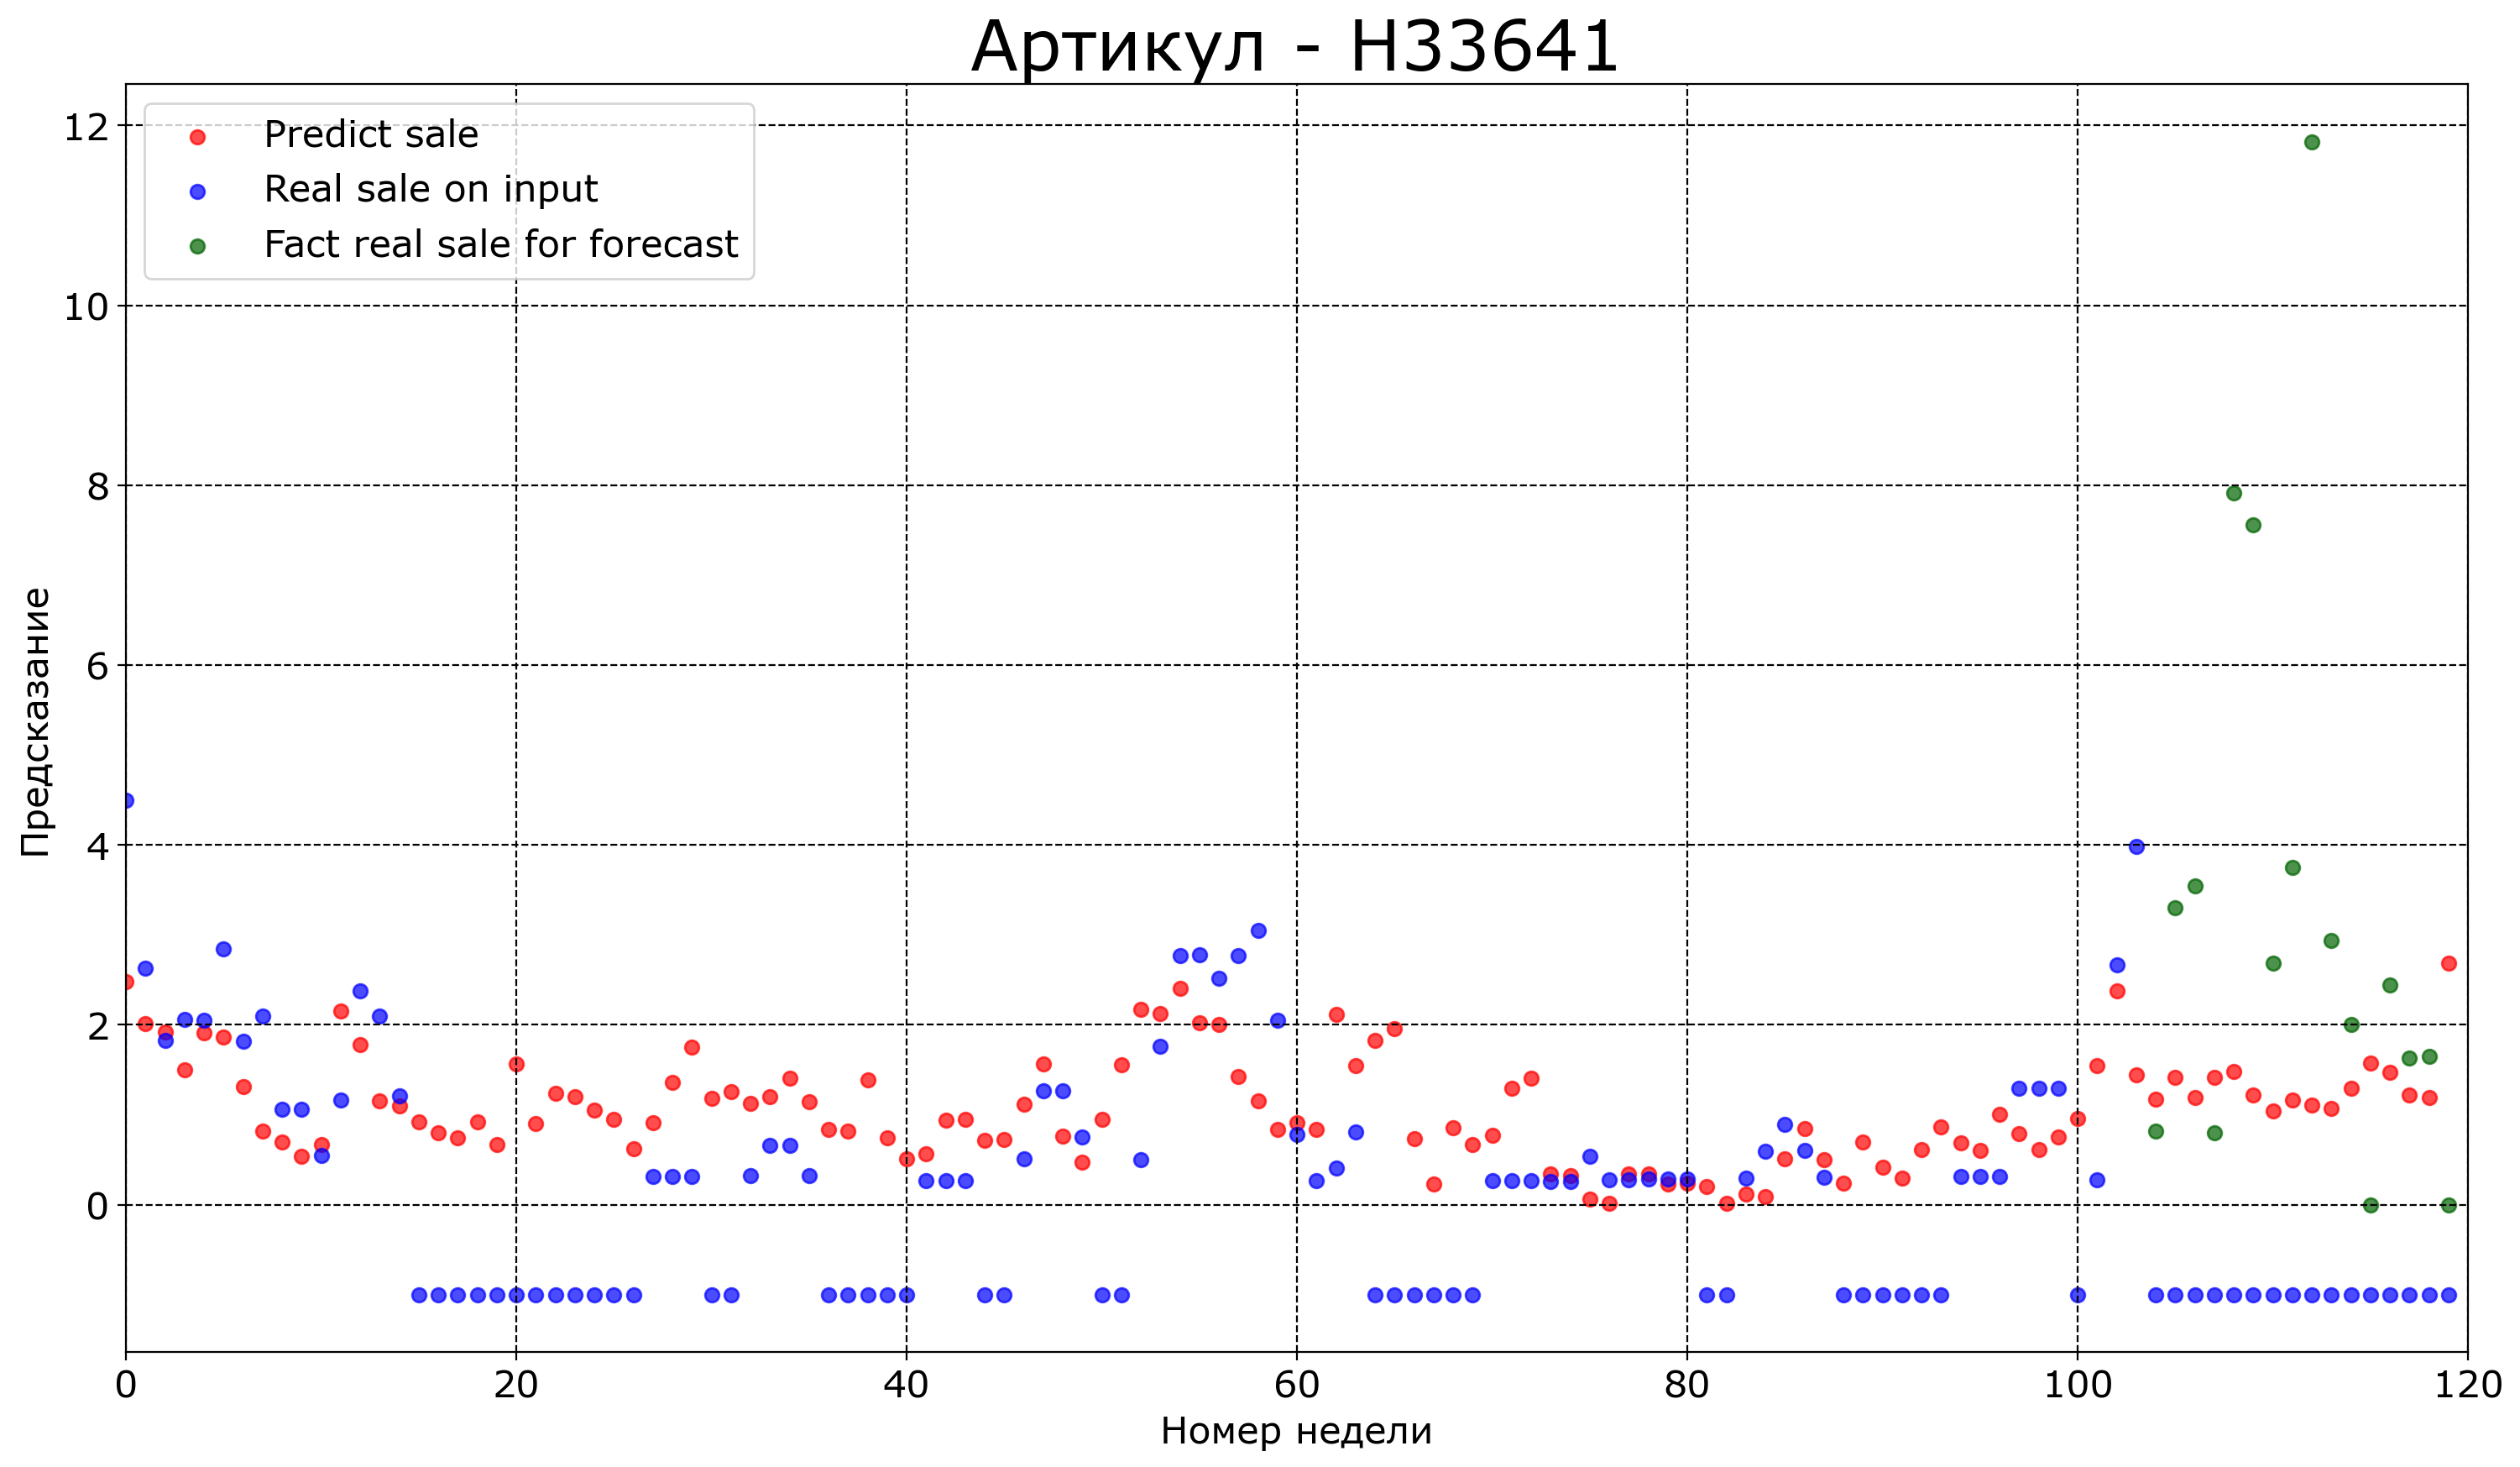

In [10]:
print(itemSalesData.shape)
# сглаживаем прогноз
# for i in range(y_pred_forecast.shape[0]):
#     y_pred_forecast[i, :] = skate_median(y_pred_forecast[i, :], 3)
# -------------------

for n, ourIndex in enumerate(indexOfItem):
    allWeek, forecastWeek, nWeek_for_average, stride = 120, 16, 1, 1
    allAvWeek= int((allWeek - nWeek_for_average) / stride + 1)
    forecastAvWeek= int((forecastWeek - nWeek_for_average) / stride + 1)
    yPred= np.zeros(allAvWeek, dtype= np.float32)
    yFact= np.zeros(forecastAvWeek, dtype= np.float32)
    x= np.zeros(allAvWeek, dtype= np.float32)
    for j in range(allAvWeek):
        x[j]= np.mean(itemSalesData[ourIndex,  1, j*stride : j*stride + nWeek_for_average])
        yPred[j-1]= np.mean(y_pred_forecast[ourIndex, j*stride : j*stride + nWeek_for_average])
    for j in range(forecastAvWeek):    
        yFact[j-1]= np.mean(fact_sale[ourIndex, j*stride : j*stride + nWeek_for_average])
    week = np.arange(0, allAvWeek)
    plt.rc('font', family='Verdana')
    plt.rcParams.update({'font.size': 16, 'figure.figsize' : (18, 10), 'figure.dpi' : 200})
    fig= plt.figure()
    ax= fig.add_subplot(111)
    lab1= u'Predict sale'
    lab2= u'Real sale on input'
    lab3= u'Fact real sale for forecast'
    ax.scatter(week, yPred, color='red', alpha=0.7)
    ax.scatter(week, x, color= 'blue', alpha=0.7)
    ax.scatter(week[-16:], np.flip(yFact), color='darkgreen', alpha=0.7)
    ax.legend((lab1, lab2, lab3), frameon=True, loc='best')
    ax.set_title('Артикул - ' + listItem[ourIndex], fontsize=30)
    ax.set_ylabel('Предсказание')
    ax.set_xlabel('Номер недели') 
    ax.grid(True, axis='y', color='black',  linestyle='dashed')
    ax.grid(True, axis='x', color='black',  linestyle='dashed')
    ax.set_xlim(0, len(week))

In [11]:
temp_bool = np.full_like(fact_sale, True)
temp_bool = np.where(temp_bool >= 0, True, False)
data_bool = np.all(temp_bool, axis = 1)

y_pred_forecast = y_pred_forecast[data_bool, :]
fact_sale = fact_sale[data_bool, :]
print(y_pred_forecast.shape, fact_sale.shape)

err_data_after = []
err_data_item = []
err_ma = []
err_mwa = []
err_ExpSmooth = []
MD_NN = np.zeros(4)
MSE_ma = 0.
MD_ma = np.zeros(4)
MSE_mwa = 0.
MD_mwa = np.zeros(4)
MSE_ExpSmooth = 0.
MD_ExpSmooth = np.zeros(4)

# Расчет ошибок прогноза
for item in range(fact_sale.shape[0]):
    for k in range(16):
        err_data_after.append(y_pred_forecast[item, k] - np.flip(fact_sale, axis = 1)[item, k])
    err_data_item.append((y_pred_forecast[item, 0:16] - np.flip(fact_sale, axis = 1)[item, 0:16]).sum()) 
# -----------------------------
delta = y_pred_forecast[:, 0:16] - np.flip(fact_sale, axis = 1)
delta_square = np.power(delta, 2).mean(axis=1)
MSE_NN = np.sqrt(delta_square.astype('f4')).mean()
MD_NN[0] = np.abs((y_pred_forecast[:, 0:16] - np.flip(fact_sale, axis = 1)[:, 0:16]).sum(axis=1)).mean()
MD_NN[1] = np.abs((y_pred_forecast[:, 0:12] - np.flip(fact_sale, axis = 1)[:, 0:12]).sum(axis=1)).mean()
MD_NN[2] = np.abs((y_pred_forecast[:, 0:8] - np.flip(fact_sale, axis = 1)[:, 0:8]).sum(axis=1)).mean()
MD_NN[3] = np.abs((y_pred_forecast[:, 0:4] - np.flip(fact_sale, axis = 1)[:, 0:4]).sum(axis=1)).mean()

# оценка временного ряда - скользящая средняя
cur_series = itemSalesData[:, 0, -5:].copy()
rolling_mean_sale = np.mean(cur_series, axis=1)
rolling_mean_sale = rolling_mean_sale[:, np.newaxis]
# print(cur_series.shape, rolling_mean_sale.shape)
for i in range(15):
    if i != 0:
#         print(cur_series.shape, rolling_mean_sale.shape)
        cur_series = np.hstack((cur_series[:, 1:], rolling_mean_sale[:, -1:]))
        temp_mean = np.mean(cur_series, axis=1)
        temp_mean = temp_mean[:, np.newaxis]
        rolling_mean_sale = np.hstack((rolling_mean_sale, temp_mean))
    else:
        cur_series = np.hstack((cur_series[:, 1:], rolling_mean_sale[:]))
        temp_mean = np.mean(cur_series, axis=1)
        temp_mean = temp_mean[:, np.newaxis]
        rolling_mean_sale = np.hstack((rolling_mean_sale, temp_mean))
delta = rolling_mean_sale - np.flip(fact_sale, axis = 1)
delta_square = np.power(delta, 2).mean(axis=1)
MSE_ma = np.sqrt(delta_square.astype('f4')).mean()        
MD_ma[0] = np.abs((rolling_mean_sale - np.flip(fact_sale, axis = 1)[:, 0:16]).sum(axis=1)).mean()
MD_ma[1] = np.abs((rolling_mean_sale[:, 0:12] - np.flip(fact_sale, axis = 1)[:, 0:12]).sum(axis=1)).mean()
MD_ma[2] = np.abs((rolling_mean_sale[:, 0:8] - np.flip(fact_sale, axis = 1)[:, 0:8]).sum(axis=1)).mean()
MD_ma[3] = np.abs((rolling_mean_sale[:, 0:4] - np.flip(fact_sale, axis = 1)[:, 0:4]).sum(axis=1)).mean()
for item in range(fact_sale.shape[0]):
    for k in range(16):
        err_ma.append(rolling_mean_sale[item, k] - np.flip(fact_sale, axis = 1)[item, k])  
# --------------------------------------------

# оценка временного ряда - взвешенная средняя    
weights = np.array([0.06, 0.12, 0.19, 0.27, 0.36])
cur_series = itemSalesData[:, 0, -5:].copy()
rolling_weights_mean_sale = np.mean(cur_series * weights, axis=1)
rolling_weights_mean_sale = rolling_weights_mean_sale[:, np.newaxis]
for _ in range(15):
    if i != 0:
        cur_series = np.hstack((cur_series[:, 1:], rolling_weights_mean_sale[:, -1:]))
        temp_mean = np.mean(cur_series * weights, axis=1)
        temp_mean = temp_mean[:, np.newaxis]
        rolling_weights_mean_sale = np.hstack((rolling_weights_mean_sale, temp_mean))
    else:
        cur_series = np.hstack((cur_series[:, 1:], rolling_weights_mean_sale[:]))
        temp_mean = np.mean(cur_series * weights, axis=1)
        temp_mean = temp_mean[:, np.newaxis]
        rolling_weights_mean_sale = np.hstack((rolling_weights_mean_sale, temp_mean)) 
delta = rolling_weights_mean_sale - np.flip(fact_sale, axis = 1)
delta_square = np.power(delta, 2).mean(axis=1)
MSE_mwa = np.sqrt(delta_square.astype('f4')).mean()        
MD_mwa[0] = np.abs((rolling_weights_mean_sale - np.flip(fact_sale, axis = 1)[:, 0:16]).sum(axis=1)).mean()
MD_mwa[1] = np.abs((rolling_weights_mean_sale[:, 0:12] - np.flip(fact_sale, axis = 1)[:, 0:12]).sum(axis=1)).mean()
MD_mwa[2] = np.abs((rolling_weights_mean_sale[:, 0:8] - np.flip(fact_sale, axis = 1)[:, 0:8]).sum(axis=1)).mean()
MD_mwa[3] = np.abs((rolling_weights_mean_sale[:, 0:4] - np.flip(fact_sale, axis = 1)[:, 0:4]).sum(axis=1)).mean()
for item in range(fact_sale.shape[0]):
    for k in range(16):
        err_mwa.append(rolling_weights_mean_sale[item, k] - np.flip(fact_sale, axis = 1)[item, k])       
# -------------------------------------------

# оценка временного ряда - экспоненциальное сглаживание
def exponential_smoothing(series, alpha):
    result = np.zeros_like(series)
    result[:, 0] = series[:, 0]
    for n in range(1, series.shape[1]):
        result[:, n] = alpha * series[:, n] + (1 - alpha) * result[:, n-1]
    return result[:, -1:]
cur_series = itemSalesData[:, 0, :].copy()
alpha = 0.13
exp_smooth_forecast_sale = exponential_smoothing(cur_series, alpha)
# print(exp_smooth_forecast_sale.shape)
for _ in range(15):
    cur_series = np.hstack([cur_series[:, 1:], exp_smooth_forecast_sale[:, -1:]])
    exp_smooth_forecast_sale = np.hstack([exp_smooth_forecast_sale, exponential_smoothing(cur_series, alpha)])
delta = exp_smooth_forecast_sale - np.flip(fact_sale, axis = 1)
delta_square = np.power(delta, 2).mean(axis=1)
MSE_ExpSmooth = np.sqrt(delta_square.astype('f4')).mean() 
MD_ExpSmooth[0] = np.abs((exp_smooth_forecast_sale - np.flip(fact_sale, axis = 1)[:, 0:16]).sum(axis=1)).mean()
MD_ExpSmooth[1] = np.abs((exp_smooth_forecast_sale[:, 0:12] - np.flip(fact_sale, axis = 1)[:, 0:12]).sum(axis=1)).mean()
MD_ExpSmooth[2] = np.abs((exp_smooth_forecast_sale[:, 0:8] - np.flip(fact_sale, axis = 1)[:, 0:8]).sum(axis=1)).mean()
MD_ExpSmooth[3] = np.abs((exp_smooth_forecast_sale[:, 0:4] - np.flip(fact_sale, axis = 1)[:, 0:4]).sum(axis=1)).mean() 
for item in range(fact_sale.shape[0]):
    for k in range(16):
        err_ExpSmooth.append(exp_smooth_forecast_sale[item, k] - np.flip(fact_sale, axis = 1)[item, k]) 
# --------------------------------------------------------

Average_sale = fact_sale[fact_sale >= 0].mean()
print('average sale - ', Average_sale)

print('MSE NN - %.2f' %(MSE_NN))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек) - %.2f %% '
      %(MD_NN[0], (MD_NN[0] * 100) / (Average_sale * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек) - %.2f %% ' 
      %(MD_NN[1], (MD_NN[1] * 100) / (Average_sale * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек) - %.2f %% ' 
      %(MD_NN[2], (MD_NN[2] * 100) / (Average_sale * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек) - %.2f %% ' 
      %(MD_NN[3], (MD_NN[3] * 100) / (Average_sale * 4)))

(2404, 120) (2404, 16)
average sale -  1.1619229800107145
MSE NN - 1.52
Среднее отклонение - 13.09 и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек) - 70.41 % 
Среднее отклонение - 10.03 и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек) - 71.95 % 
Среднее отклонение - 7.00 и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек) - 75.26 % 
Среднее отклонение - 4.09 и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек) - 88.06 % 


In [12]:
print('MSE NN - %.2f' %(MSE_NN))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - %.2f %% '
      %(MD_NN[0], (MD_NN[0] * 100) / (Average_sale * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек) - %.2f %% ' 
      %(MD_NN[1], (MD_NN[1] * 100) / (Average_sale * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек) - %.2f %% ' 
      %(MD_NN[2], (MD_NN[2] * 100) / (Average_sale * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек) - %.2f %% ' 
      %(MD_NN[3], (MD_NN[3] * 100) / (Average_sale * 4)))

print('MSE скользящая средняя - %.2f' %(MSE_ma))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - %.2f %% '
      %(MD_ma[0], (MD_ma[0] * 100) / (Average_sale * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек)) - %.2f %% '
      %(MD_ma[1], (MD_ma[1] * 100) / (Average_sale * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек)) - %.2f %% '
      %(MD_ma[2], (MD_ma[2] * 100) / (Average_sale * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек)) - %.2f %% '
      %(MD_ma[3], (MD_ma[3] * 100) / (Average_sale * 4)))

print('MSE взвешенная скользящая средняя - %.2f' %(MSE_mwa))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - %.2f %% '
      %(MD_mwa[0], (MD_mwa[0] * 100) / (Average_sale * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек)) - %.2f %% '
      %(MD_mwa[1], (MD_mwa[1] * 100) / (Average_sale * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек)) - %.2f %% '
      %(MD_mwa[2], (MD_mwa[2] * 100) / (Average_sale * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек)) - %.2f %% '
      %(MD_mwa[3], (MD_mwa[3] * 100) / (Average_sale * 4)))

print('MSE экспоненциальное сглаживание - %.2f' %(MSE_ExpSmooth))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - %.2f %% '
      %(MD_ExpSmooth[0], (MD_ExpSmooth[0] * 100) / (Average_sale * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек)) - %.2f %% '
      %(MD_ExpSmooth[1], (MD_ExpSmooth[1] * 100) / (Average_sale * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек)) - %.2f %% '
      %(MD_ExpSmooth[2], (MD_ExpSmooth[2] * 100) / (Average_sale * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек)) - %.2f %% '
      %(MD_ExpSmooth[3], (MD_ExpSmooth[3] * 100) / (Average_sale * 4)))

MSE NN - 1.52
Среднее отклонение - 13.09 и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - 70.41 % 
Среднее отклонение - 10.03 и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек) - 71.95 % 
Среднее отклонение - 7.00 и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек) - 75.26 % 
Среднее отклонение - 4.09 и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек) - 88.06 % 
MSE скользящая средняя - 1.78
Среднее отклонение - 19.85 и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - 106.77 % 
Среднее отклонение - 14.46 и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек)) - 103.74 % 
Среднее отклонение - 9.31 и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек)) - 100.20 % 
Среднее отклонение - 4.93 и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек)) - 106.05 % 
MSE взвешенная скользящая средняя - 1.57
Среднее отклонение - 17.56 и проце

Text(0, 0.5, 'частота')

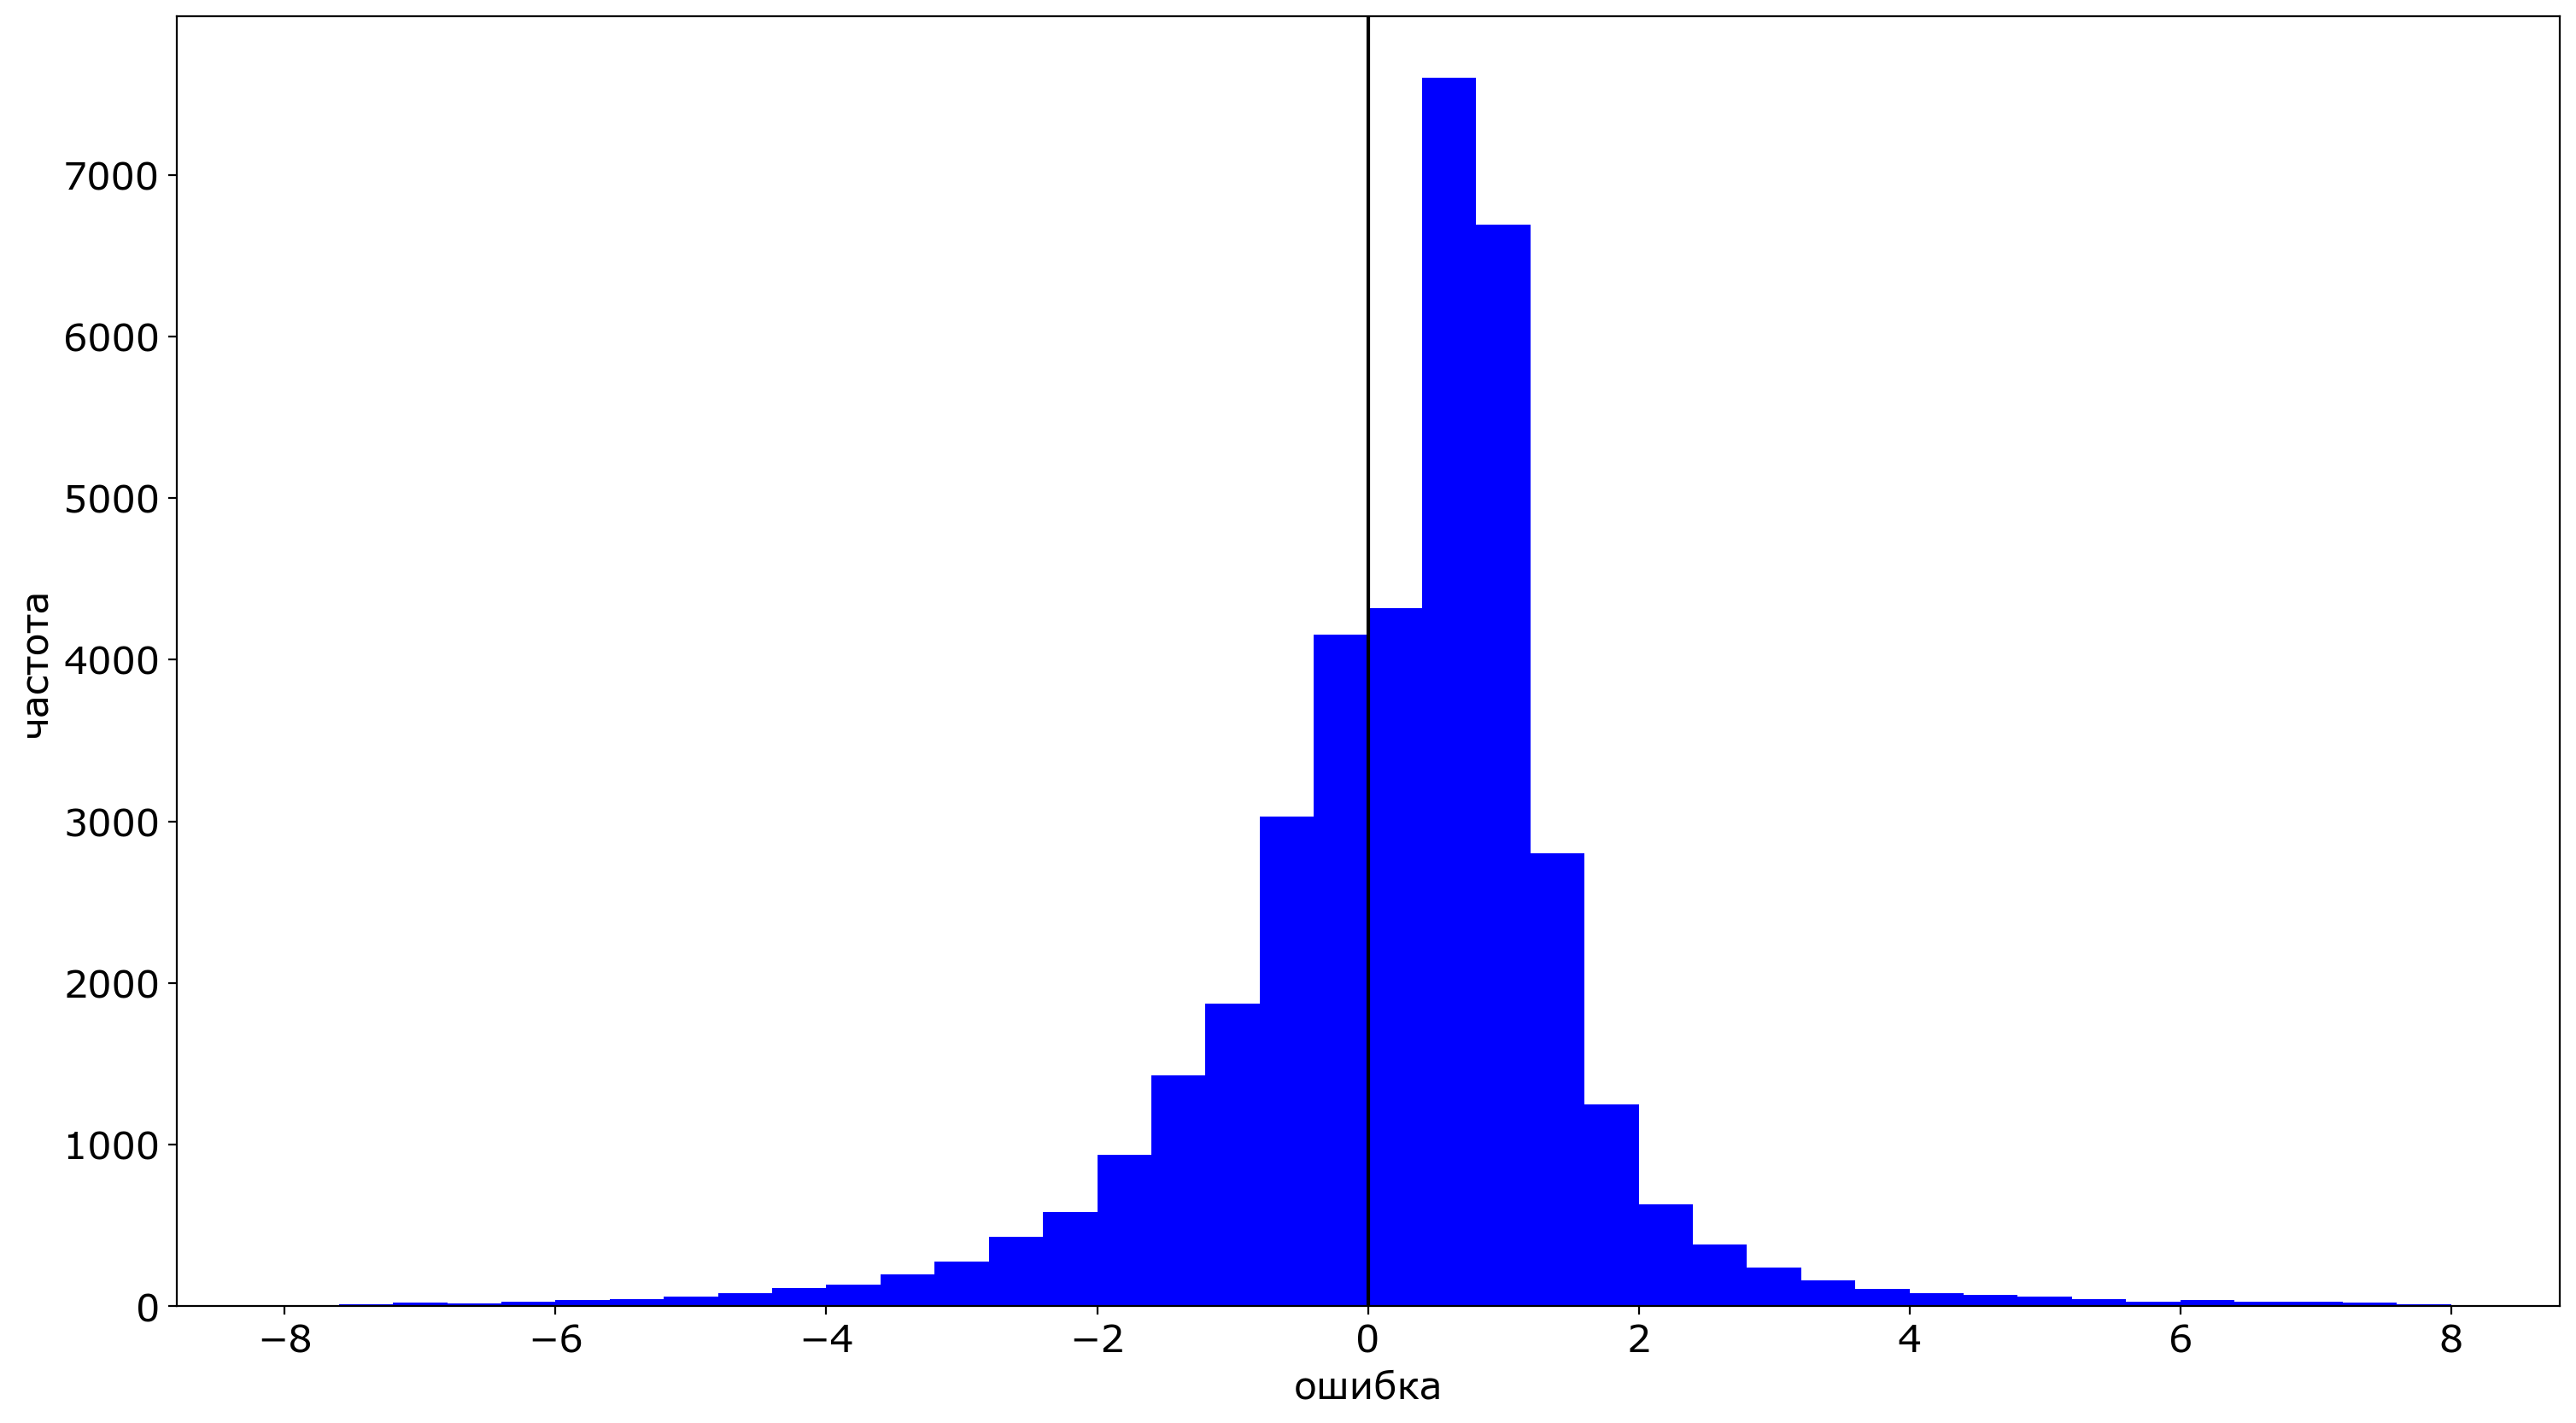

In [13]:
# распределение ошибок прогноза
err_bin = np.linspace(-8, 8, 41)
err_data_after = np.array(err_data_after)
plt.hist(err_data_after, bins=err_bin, color='blue')
plt.axvline(0, ymax=15000, color='k')
plt.xlabel(u'ошибка')
plt.ylabel(u'частота')

Text(0, 0.5, 'частота')

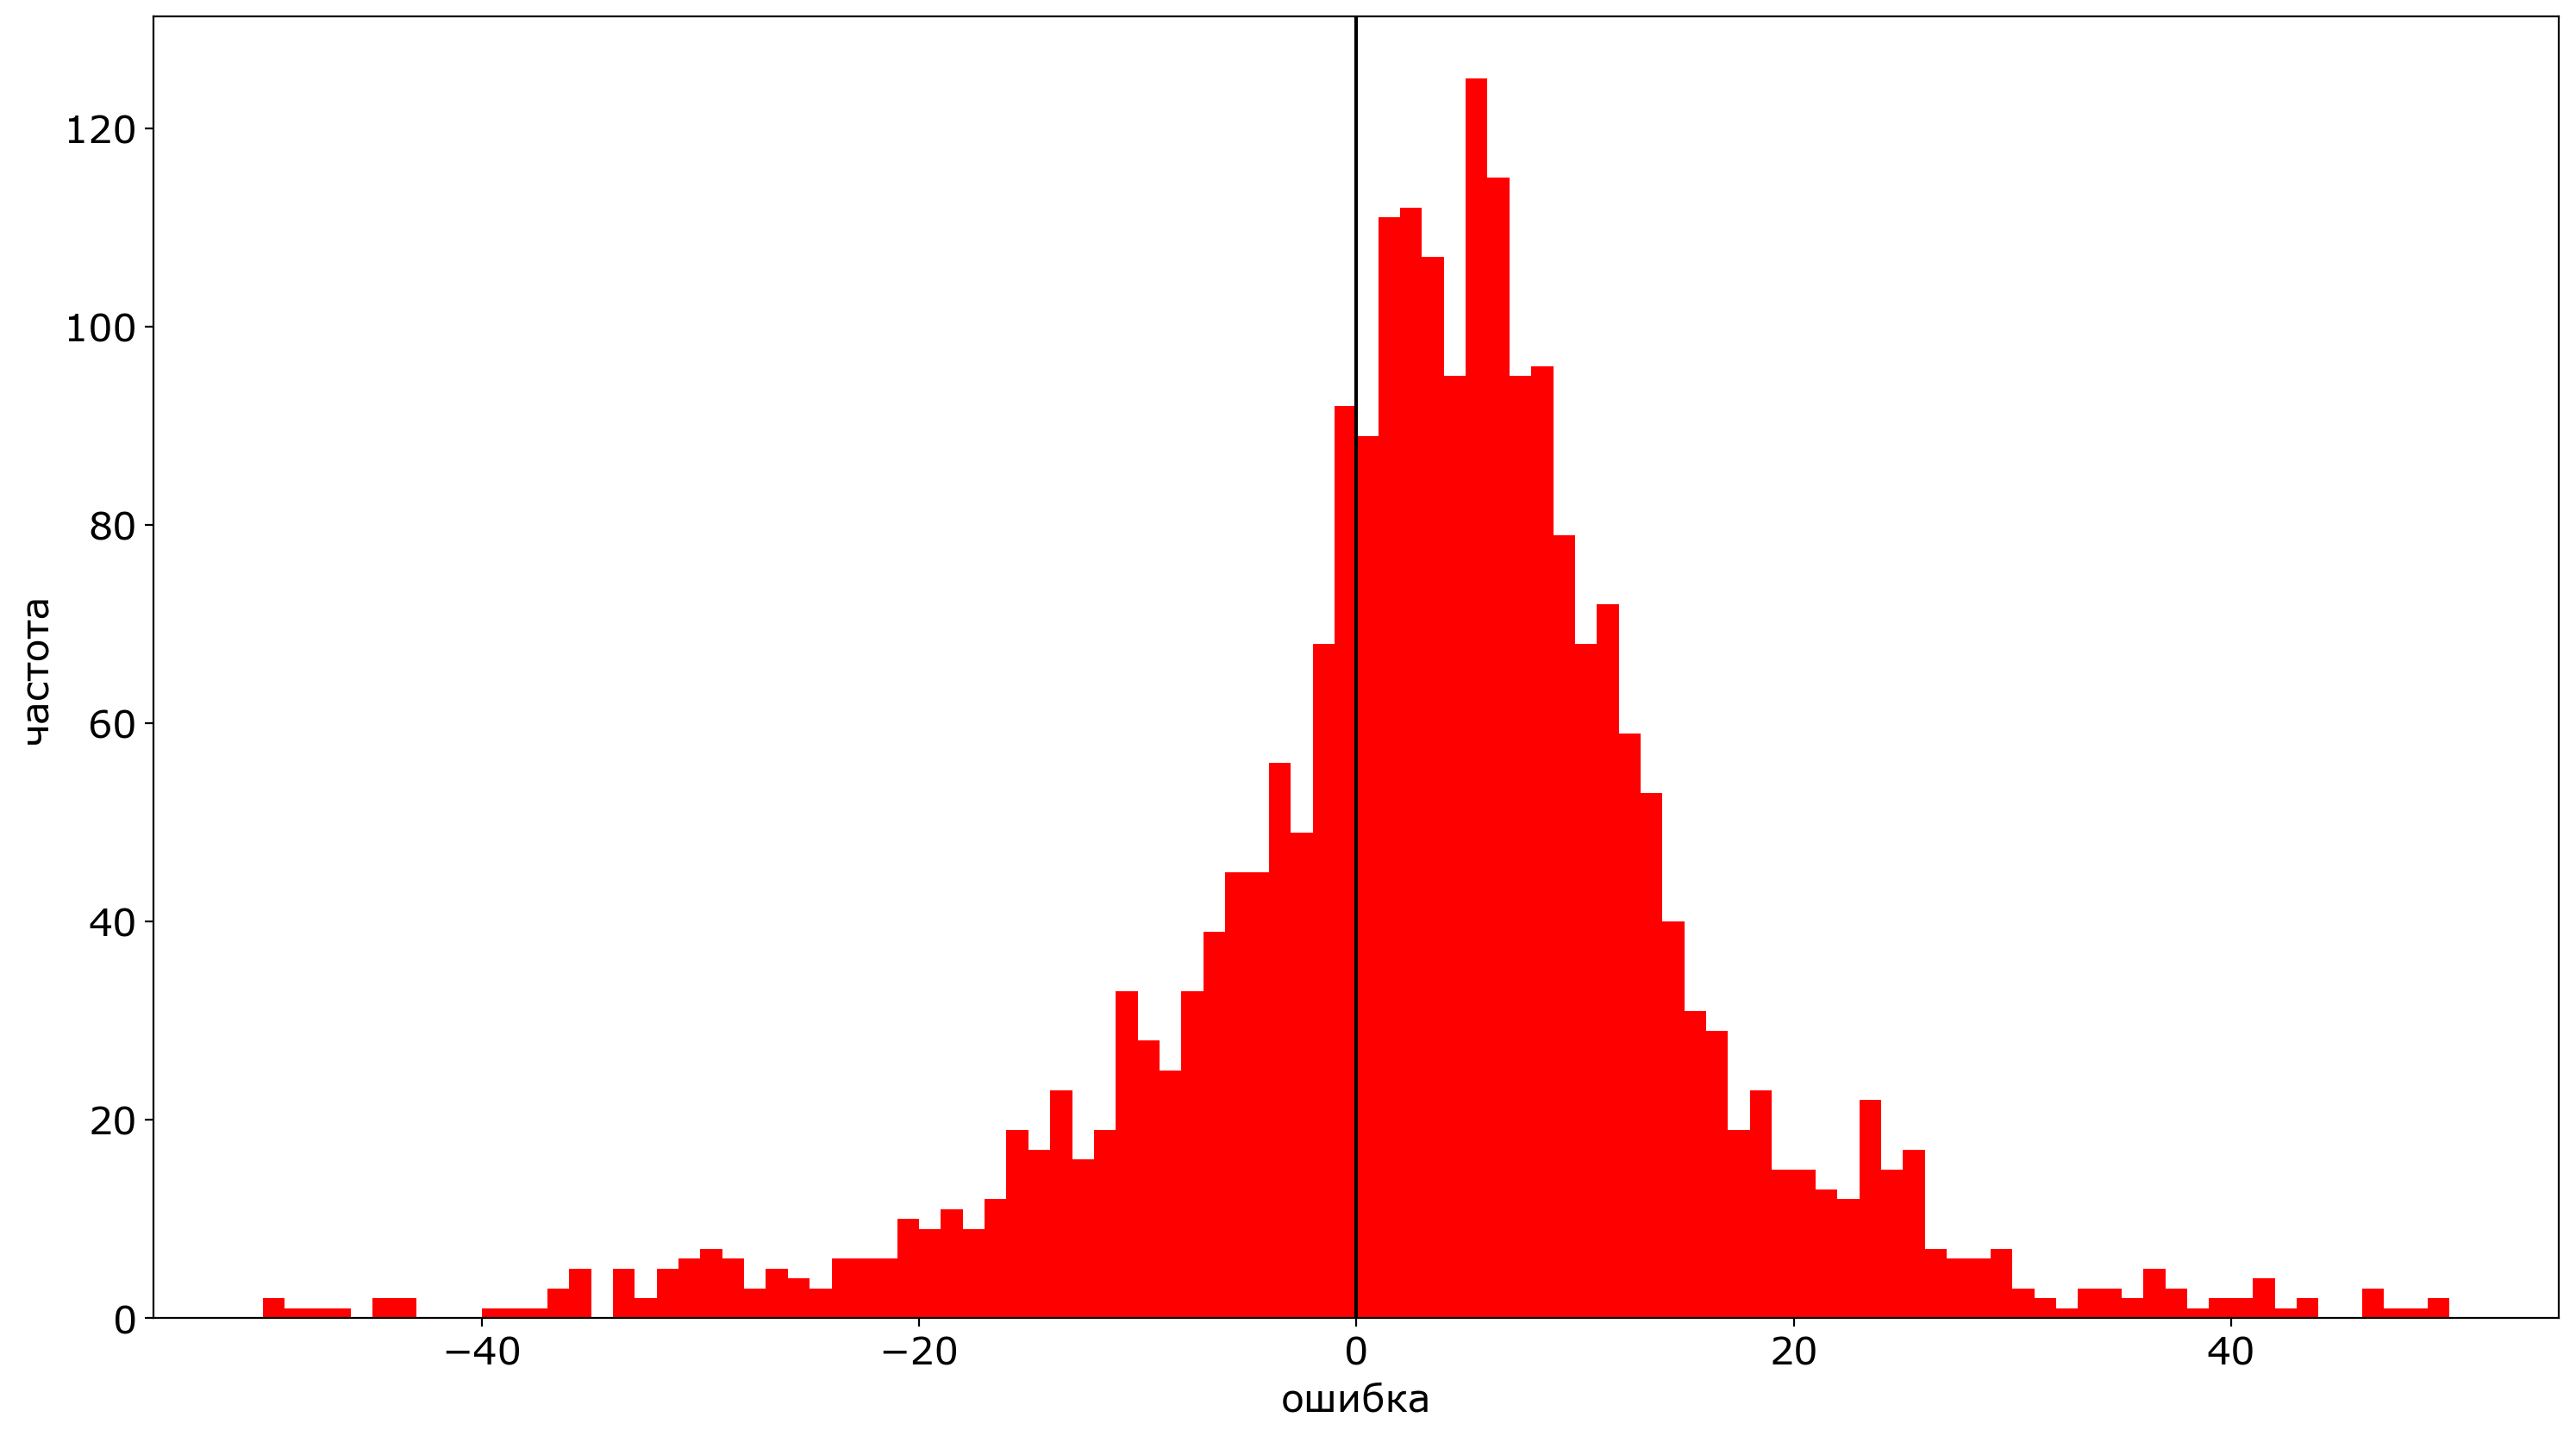

In [14]:
# распределение ошибок сумарного (на item) прогноза 
err_bin = np.linspace(-50, 50, 101)
err_data_item = np.array(err_data_item)
plt.hist(err_data_item, bins=err_bin, color='red')
plt.axvline(0, ymax=15000, color='k')
plt.xlabel(u'ошибка')
plt.ylabel(u'частота')

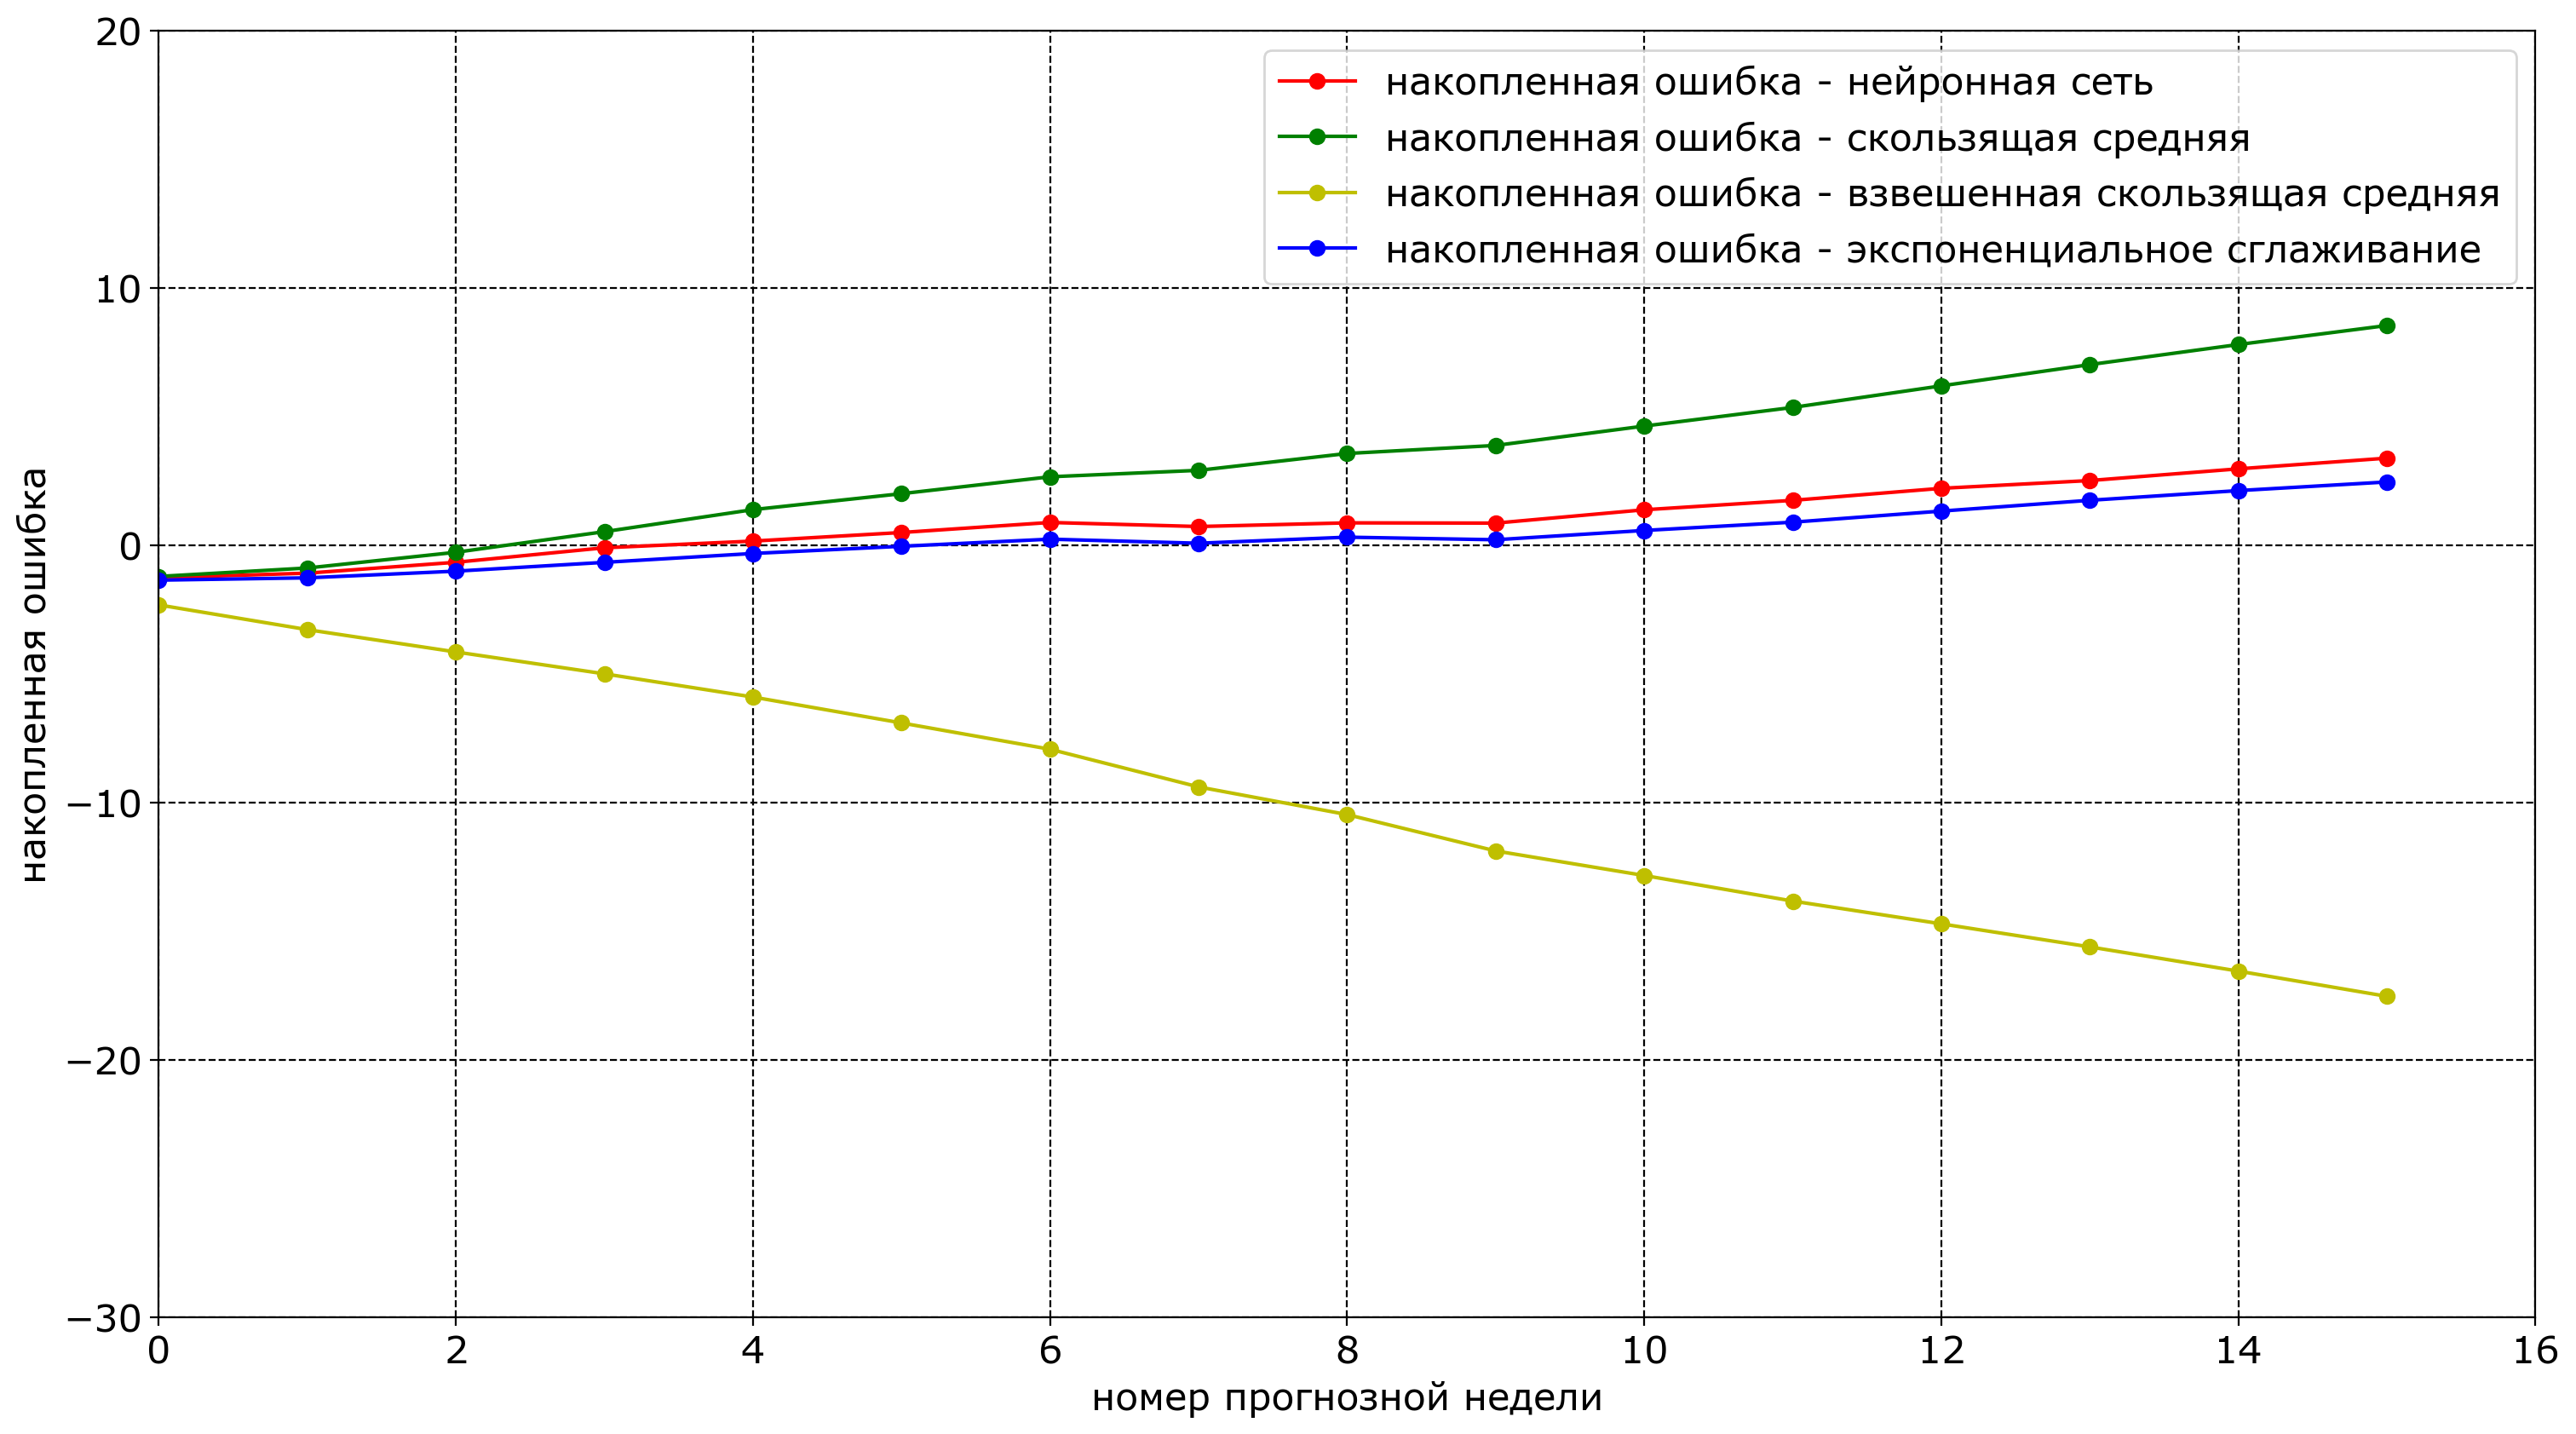

In [15]:
# накапливаемая ошибка сумарного (на item) прогноза
err_data_after = err_data_after.reshape(-1, 16)
err_ma = np.array(err_ma)
err_ma = err_ma.reshape(-1, 16)
err_mwa = np.array(err_mwa)
err_mwa = err_mwa.reshape(-1, 16)
err_ExpSmooth = np.array(err_ExpSmooth)
err_ExpSmooth = err_ExpSmooth.reshape(-1, 16)

cumsum_err = np.cumsum(err_data_after, axis = 1)
cumsum_err = np.mean(cumsum_err, axis = 0)
cumsum_err_ma = np.cumsum(err_ma, axis = 1)
cumsum_err_ma = np.mean(cumsum_err_ma, axis = 0)
cumsum_err_mwa = np.cumsum(err_mwa, axis = 1)
cumsum_err_mwa = np.mean(cumsum_err_mwa, axis = 0)
cumsum_err_ExpSmooth = np.cumsum(err_ExpSmooth, axis = 1)
cumsum_err_ExpSmooth = np.mean(cumsum_err_ExpSmooth, axis = 0)

week = np.arange(16)
plt.plot(week, cumsum_err, '-or')
plt.plot(week, cumsum_err_ma, '-og')
plt.plot(week, cumsum_err_mwa, '-oy')
plt.plot(week, cumsum_err_ExpSmooth, '-ob')

plt.xlabel(u'номер прогнозной недели')
plt.ylabel(u'накопленная ошибка')
plt.grid(True, axis='y', color='black',  linestyle='dashed')
plt.grid(True, axis='x', color='black',  linestyle='dashed')
plt.xlim(0, len(week))
# minimum = cumsum_err.min() if cumsum_err.min() < cumsum_err_abs.min() else cumsum_err_abs.min()
plt.ylim(-30, 20)
lab1 = u'накопленная ошибка - нейронная сеть'
lab2 = u'накопленная ошибка - скользящая средняя'
lab3 = u'накопленная ошибка - взвешенная скользящая средняя'
lab4 = u'накопленная ошибка - экспоненциальное сглаживание'
plt.legend((lab1, lab2, lab3, lab4), frameon=True, loc='best')

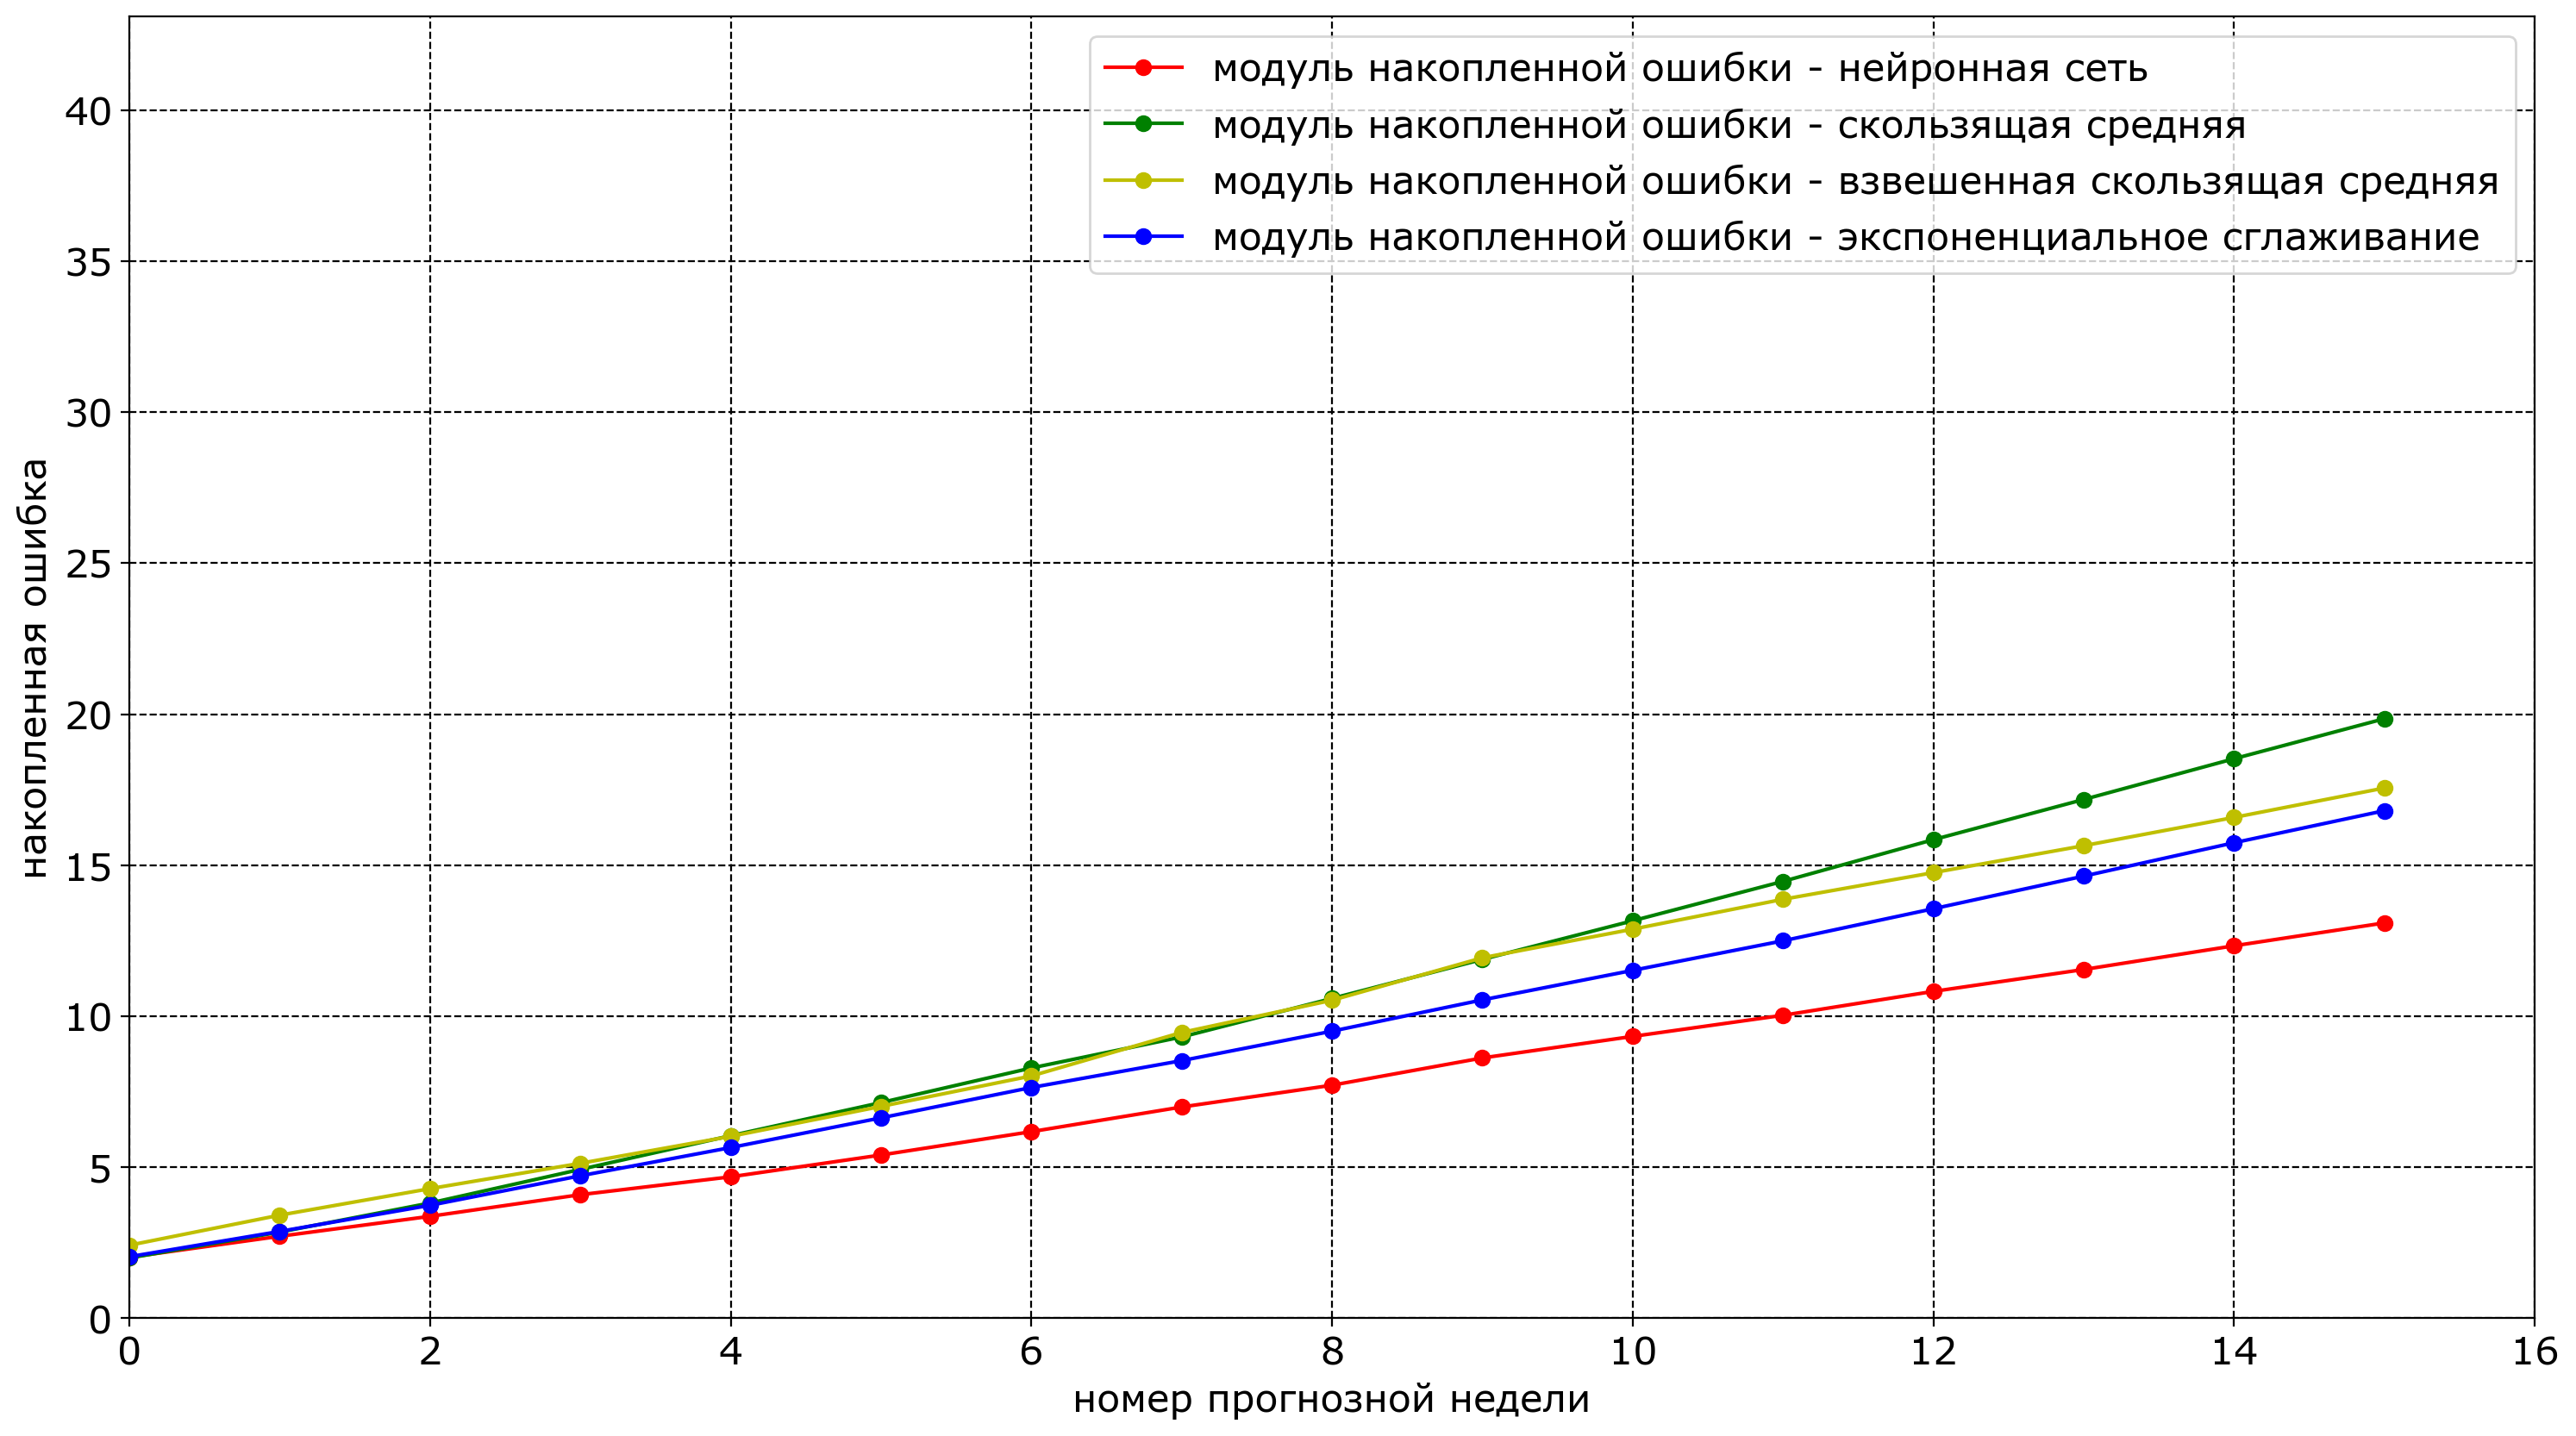

In [16]:
# накапливаемая по модулю ошибка сумарного (на item) прогноза
cumsum_err_abs = np.abs(np.cumsum(err_data_after, axis = 1))
cumsum_err_abs = np.mean(cumsum_err_abs, axis = 0)
cumsum_err_abs_ma = np.abs(np.cumsum(err_ma, axis = 1))
cumsum_err_abs_ma = np.mean(cumsum_err_abs_ma, axis = 0)
cumsum_err_abs_mwa = np.abs(np.cumsum(err_mwa, axis = 1))
cumsum_err_abs_mwa = np.mean(cumsum_err_abs_mwa, axis = 0)
cumsum_err_abs_ExpSmooth = np.abs(np.cumsum(err_ExpSmooth, axis = 1))
cumsum_err_abs_ExpSmooth = np.mean(cumsum_err_abs_ExpSmooth, axis = 0)

week = np.arange(16)
plt.plot(week, cumsum_err_abs, '-or')
plt.plot(week, cumsum_err_abs_ma, '-og')
plt.plot(week, cumsum_err_abs_mwa, '-oy')
plt.plot(week, cumsum_err_abs_ExpSmooth, '-ob')
plt.xlabel(u'номер прогнозной недели')
plt.ylabel(u'накопленная ошибка')
plt.grid(True, axis='y', color='black',  linestyle='dashed')
plt.grid(True, axis='x', color='black',  linestyle='dashed')
plt.xlim(0, len(week))
minimum = cumsum_err.min() if cumsum_err.min() < cumsum_err_abs.min() else cumsum_err_abs.min()
plt.ylim(0, cumsum_err_abs.max() + 30)
lab1 = u'модуль накопленной ошибки - нейронная сеть'
lab2 = u'модуль накопленной ошибки - скользящая средняя'
lab3 = u'модуль накопленной ошибки - взвешенная скользящая средняя'
lab4 = u'модуль накопленной ошибки - экспоненциальное сглаживание'
plt.legend((lab1, lab2, lab3, lab4), frameon=True, loc='best')

# Далее сопоставление с другими методами

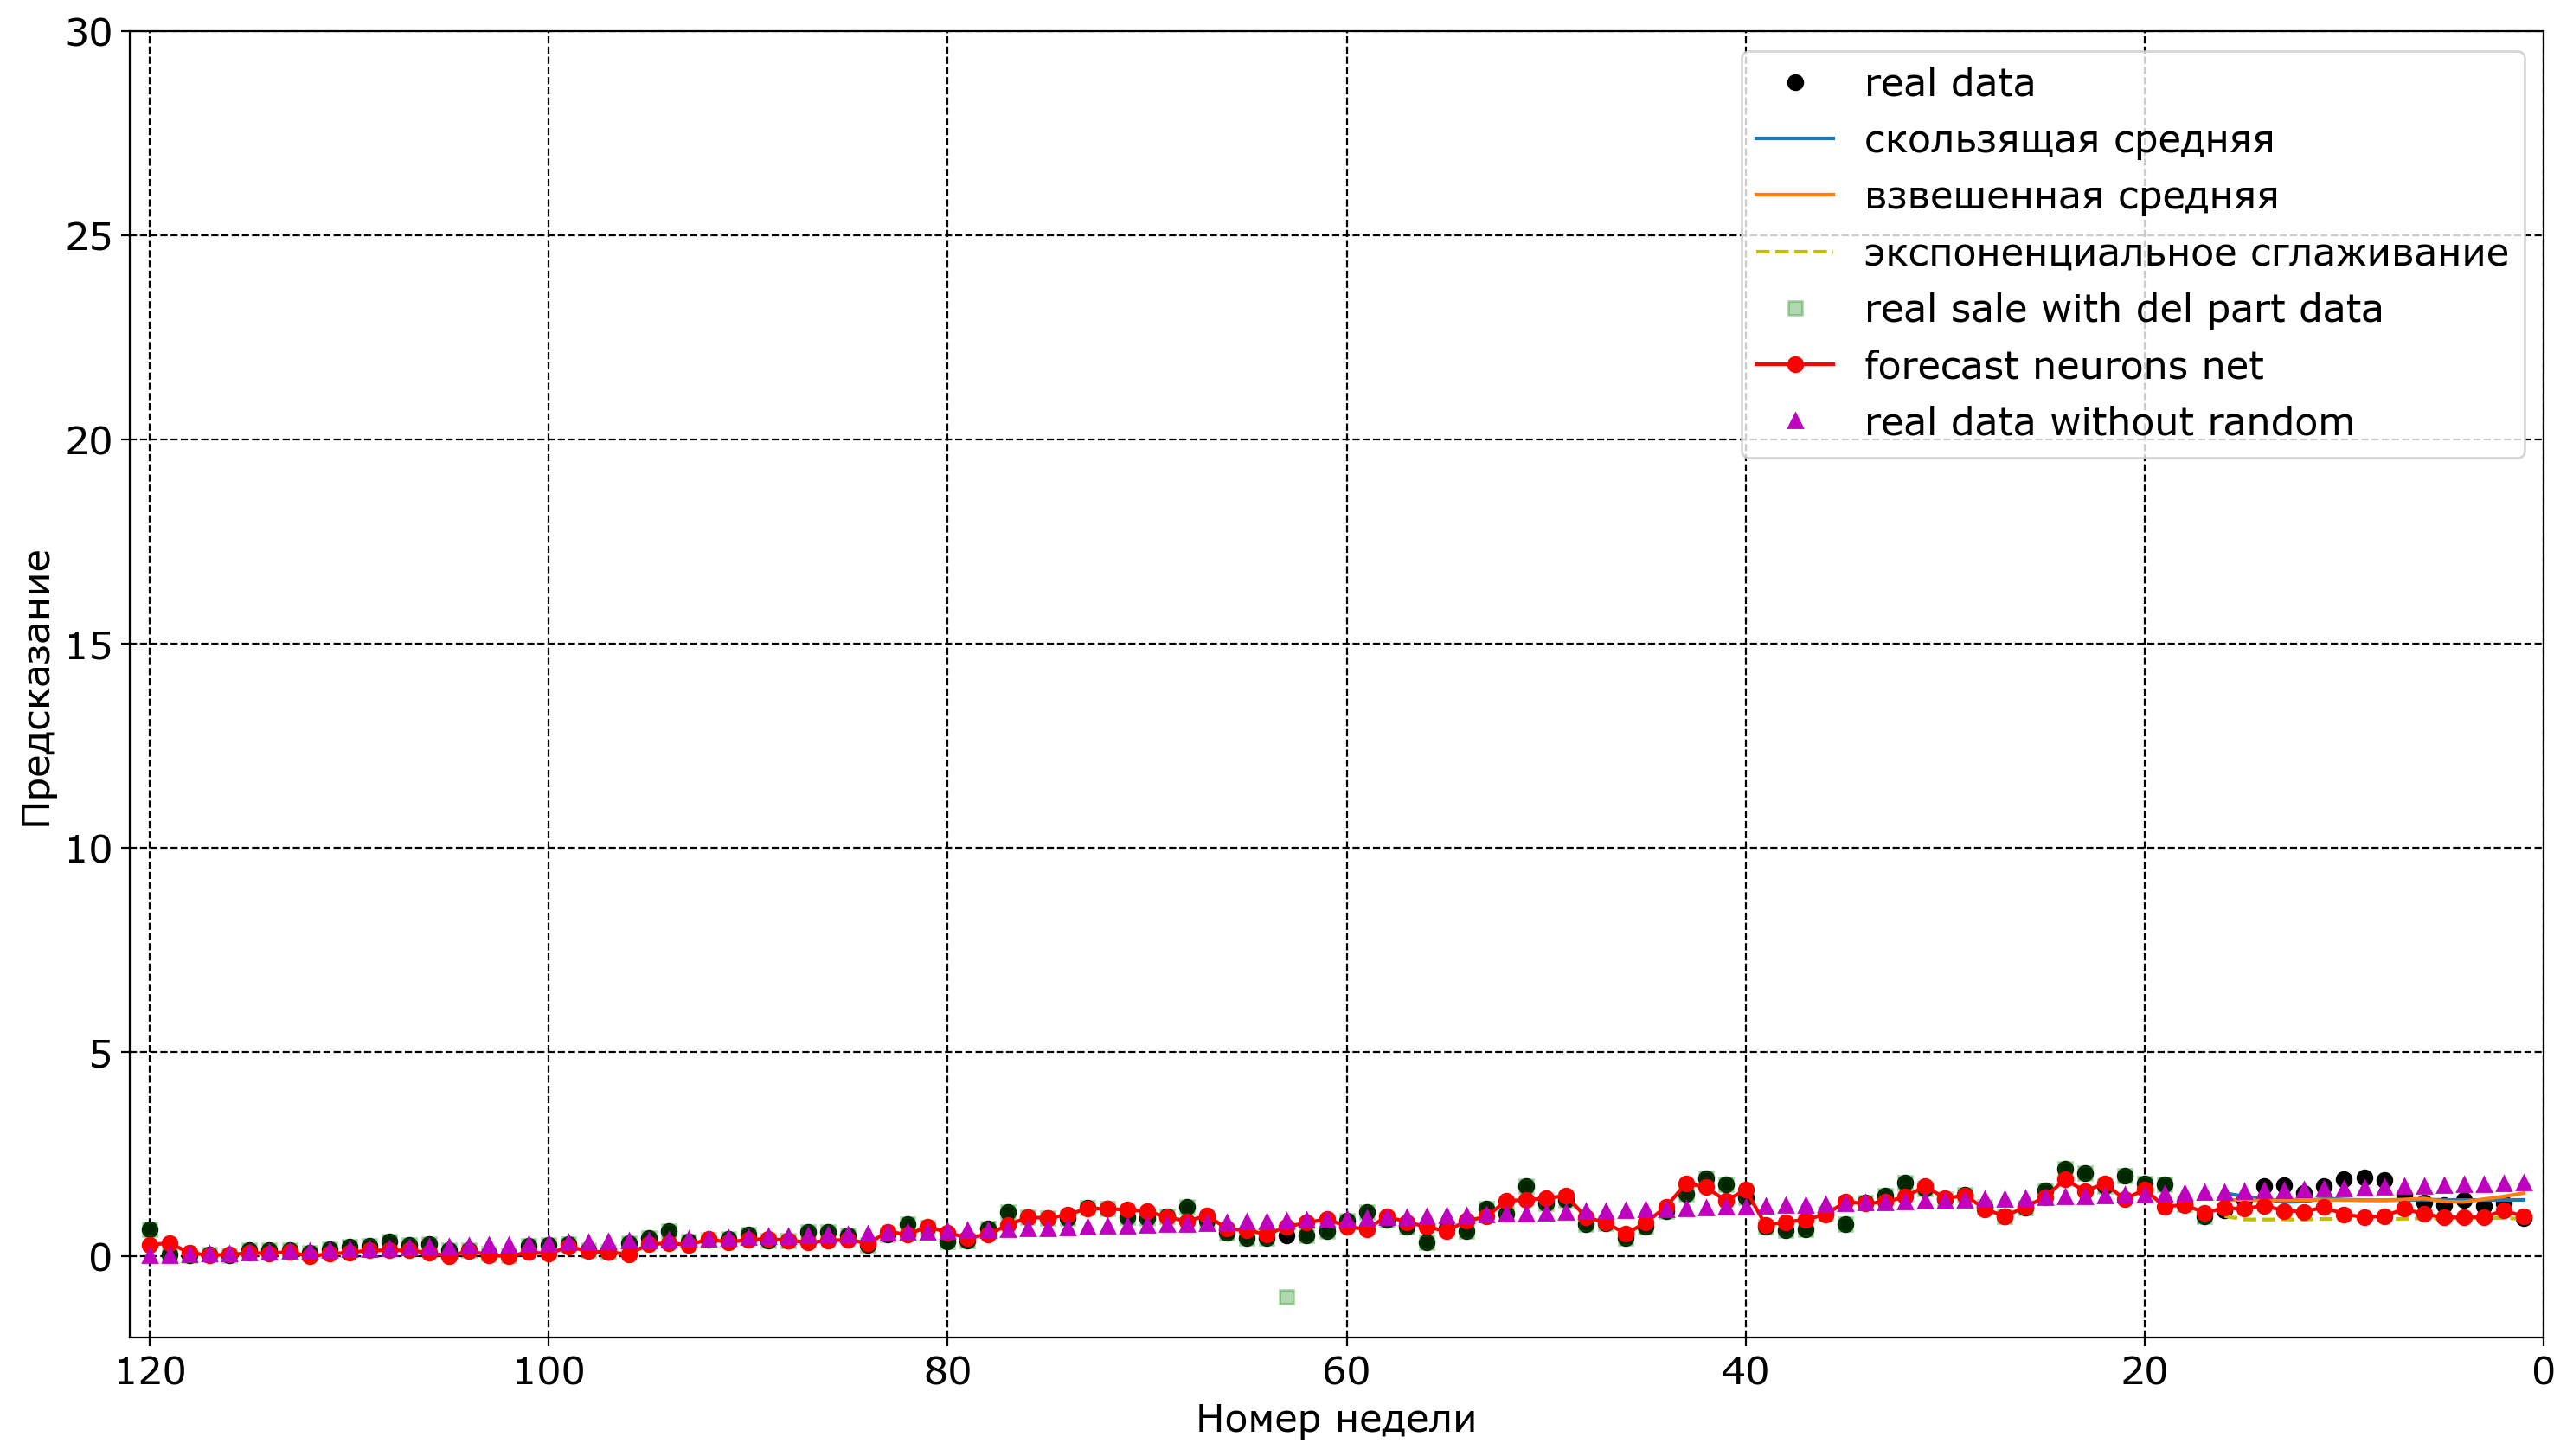

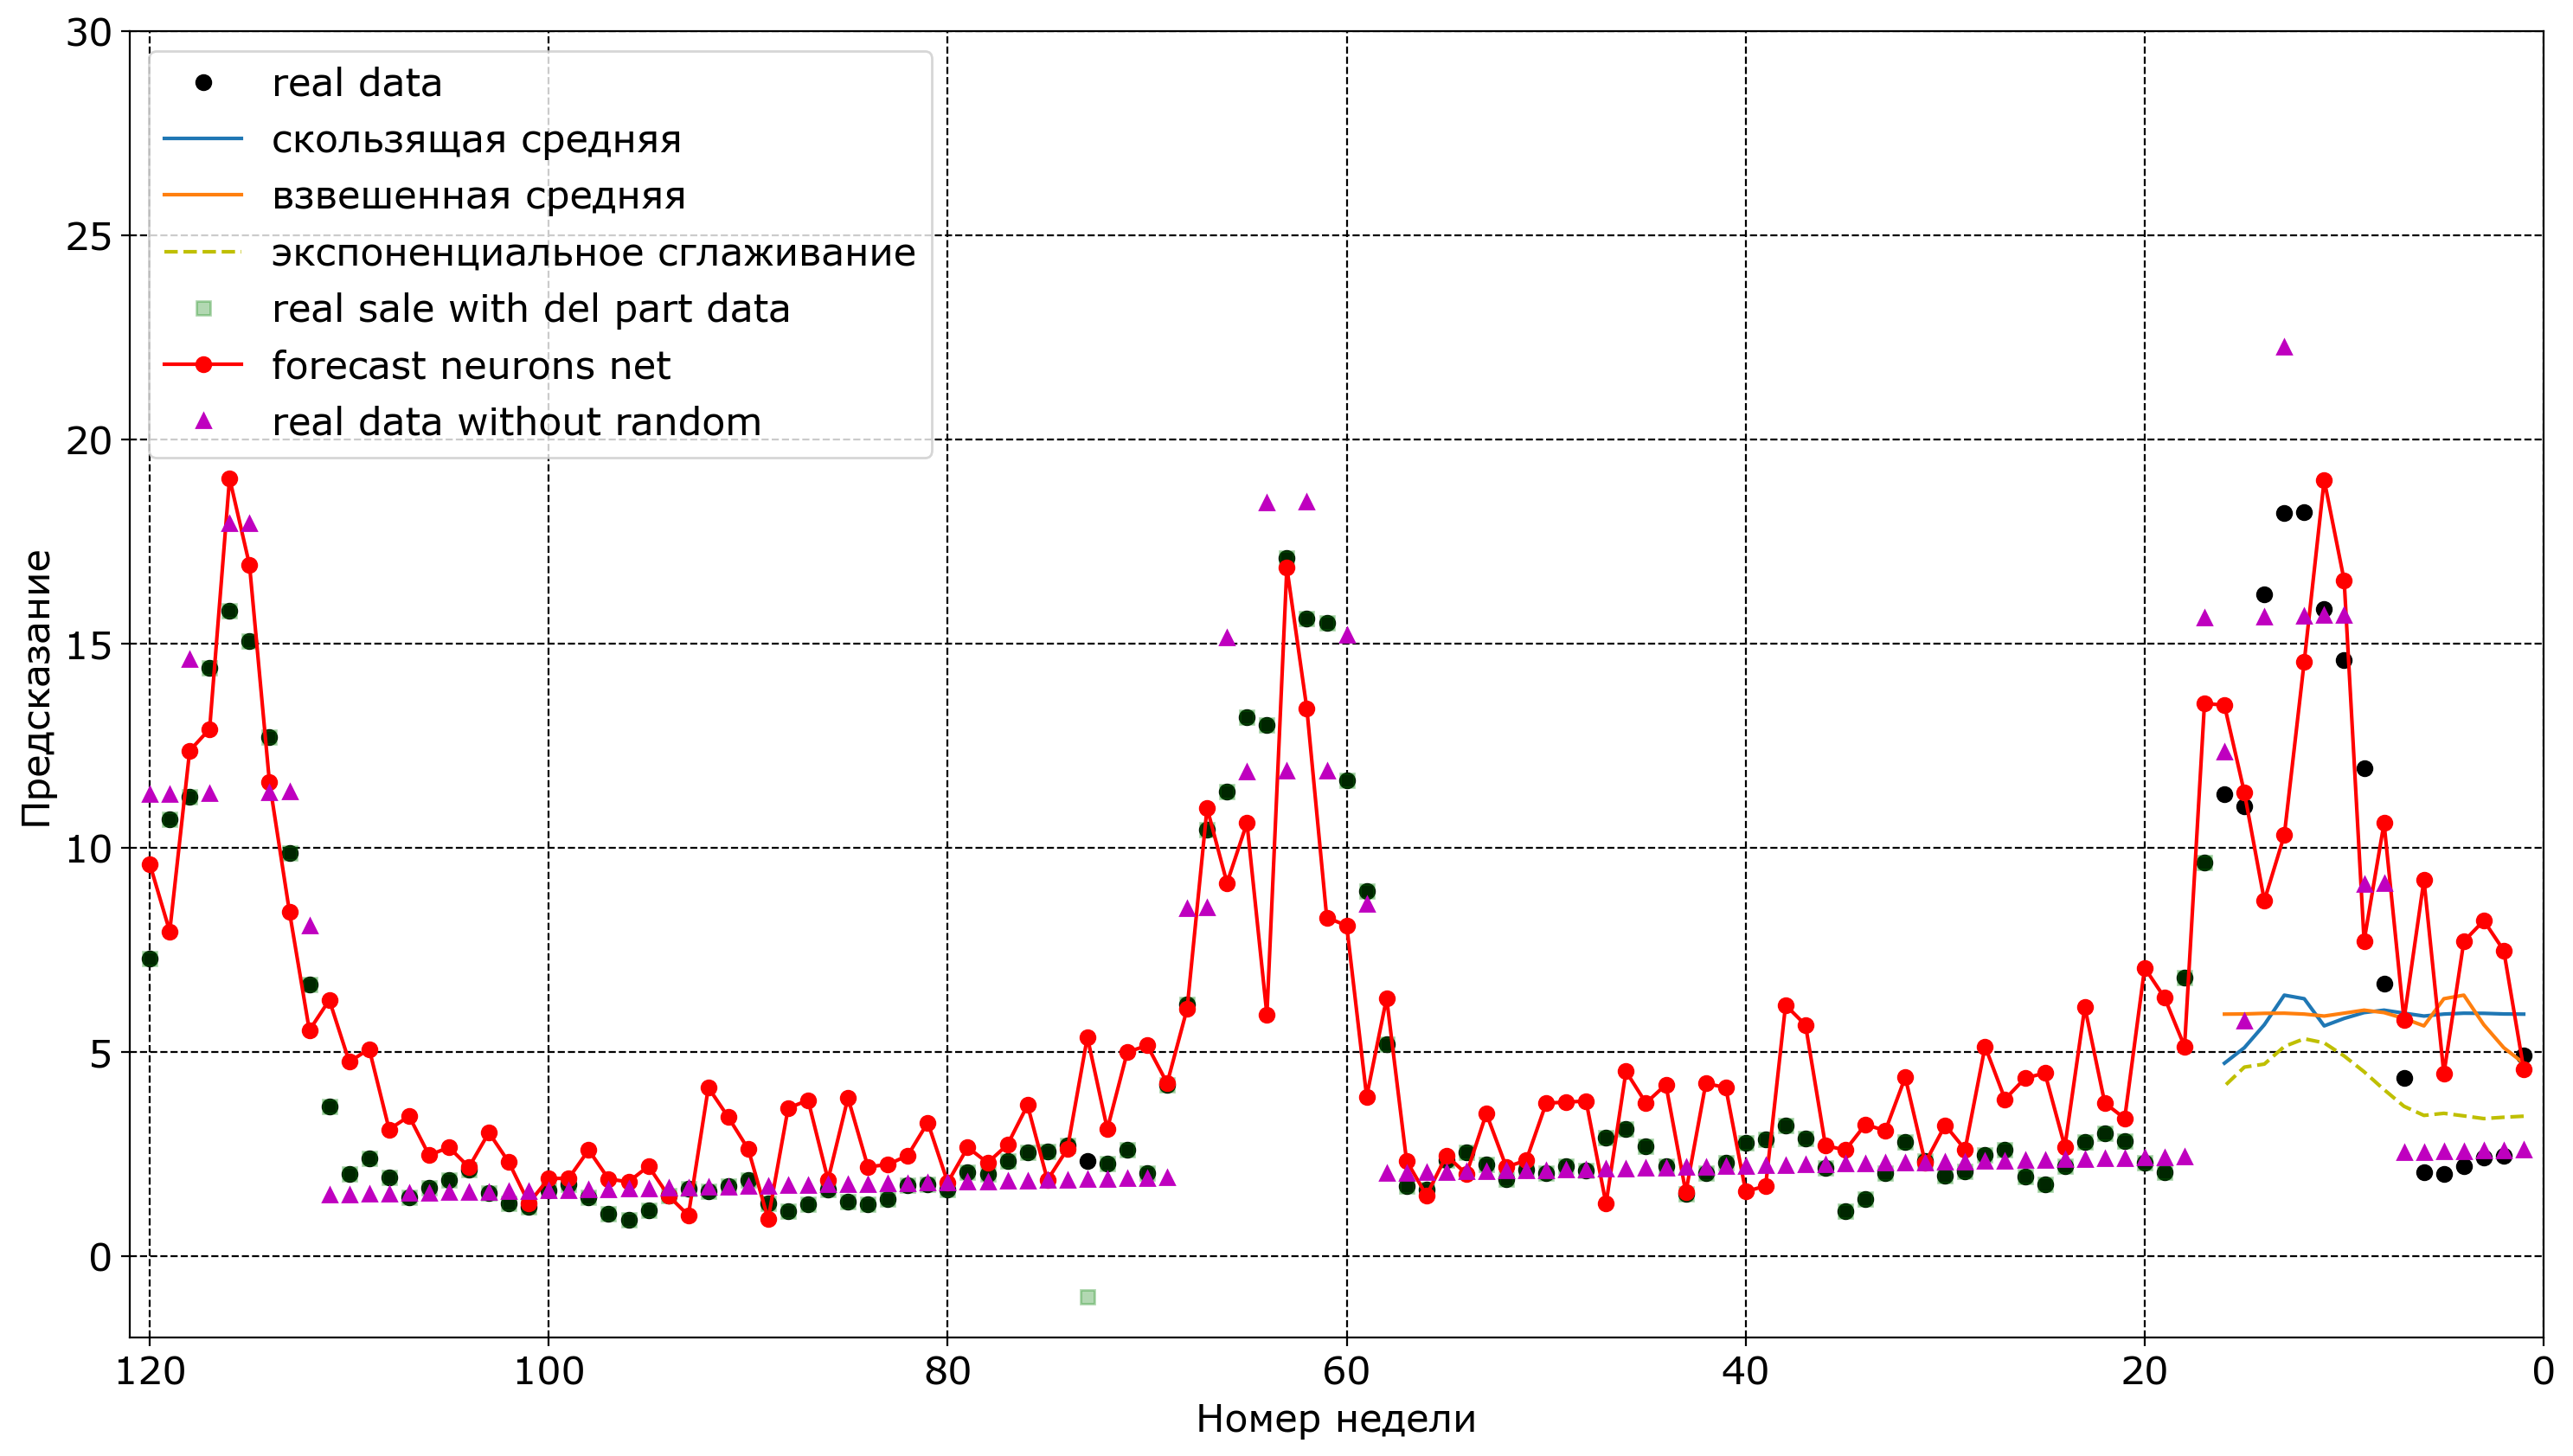

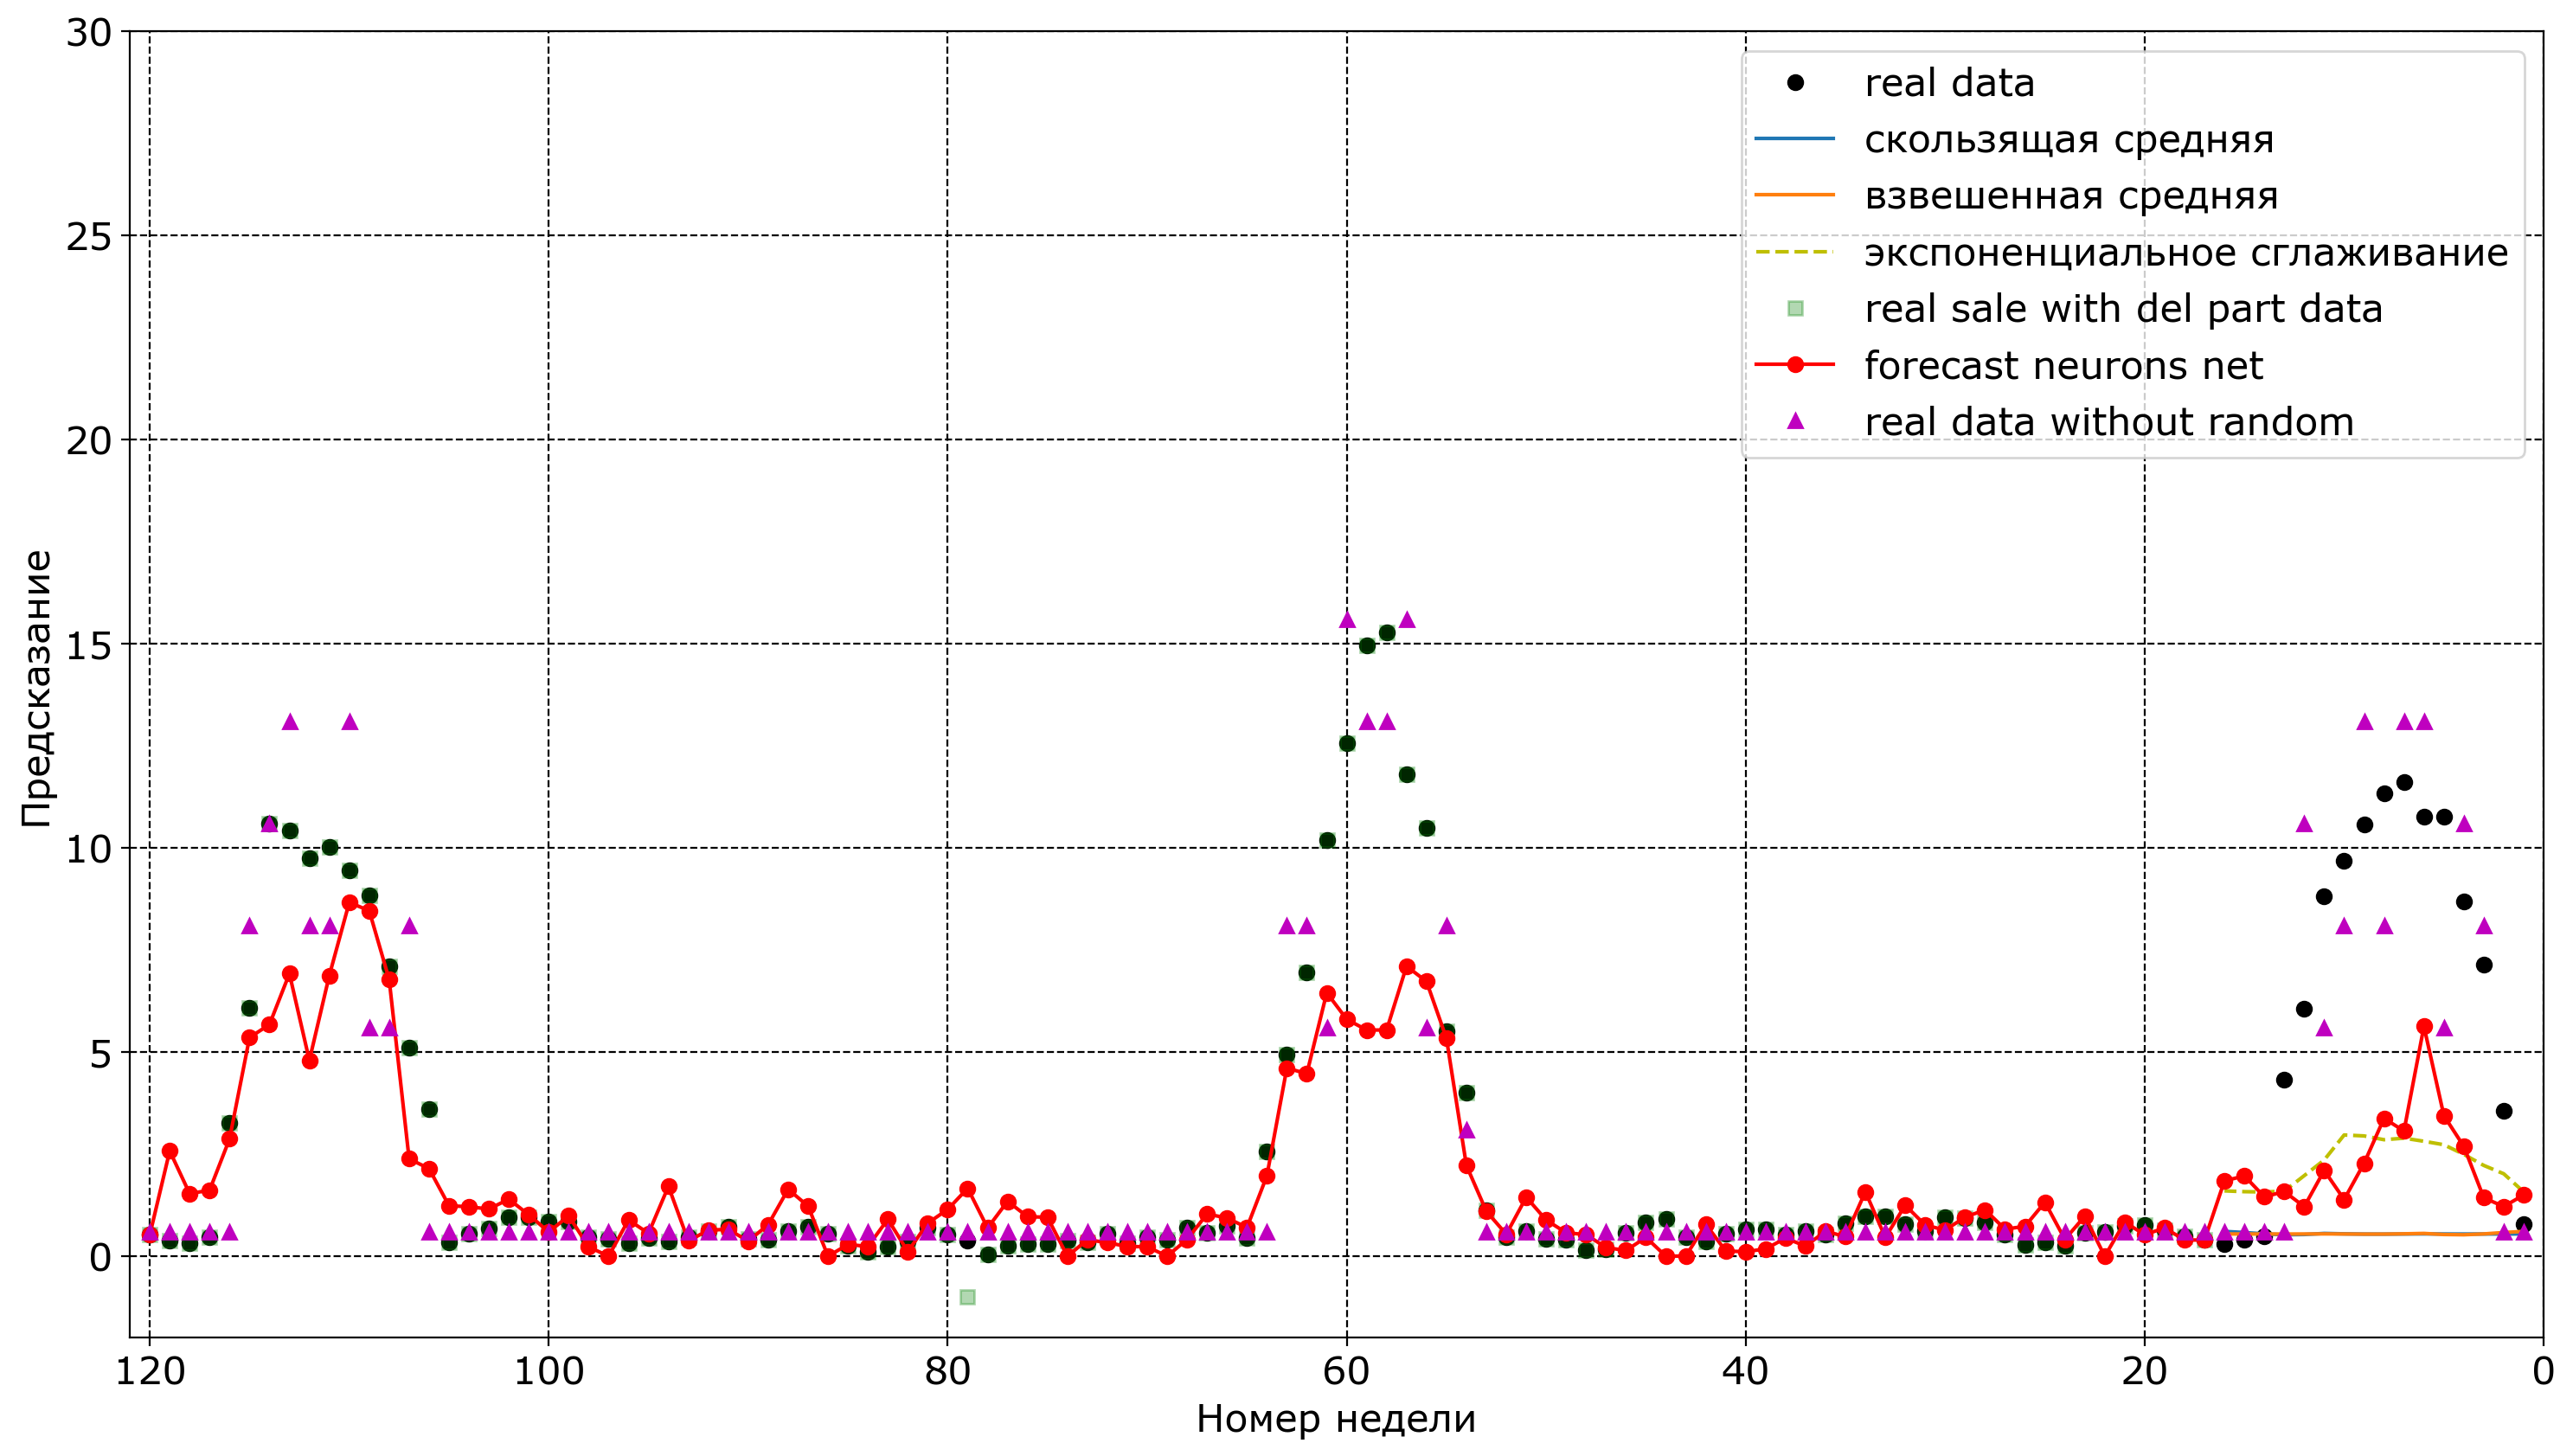

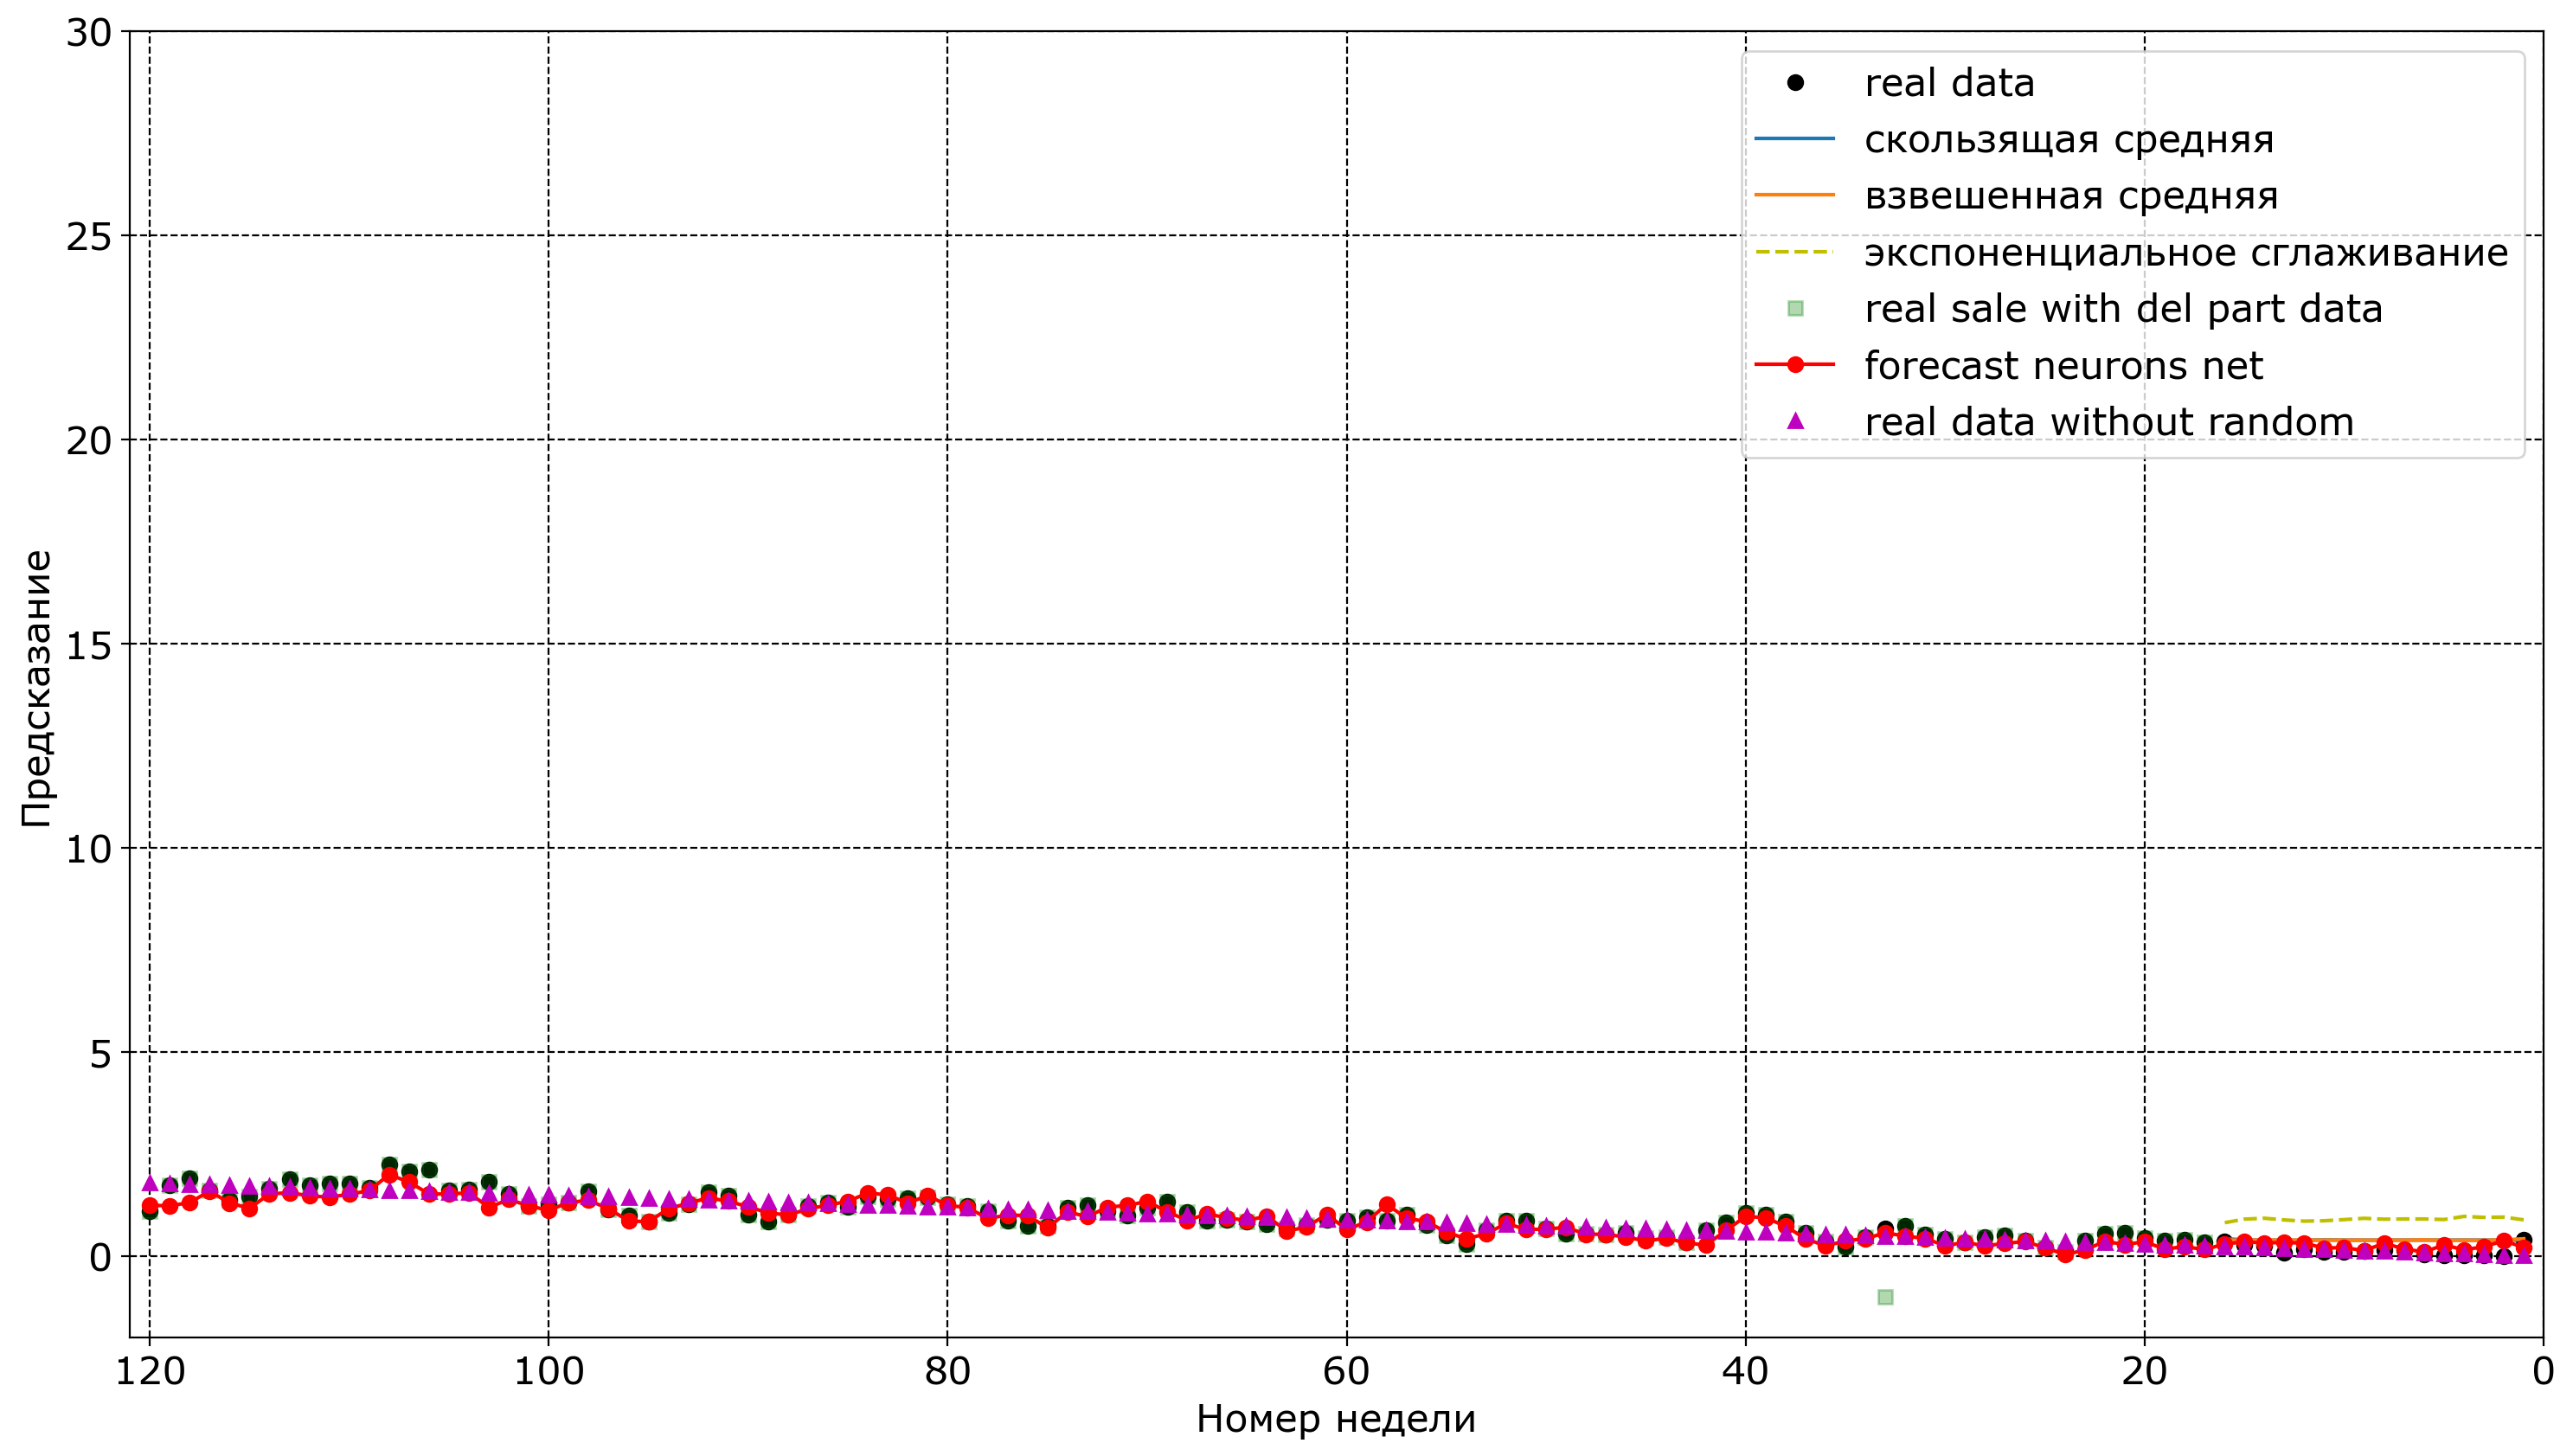

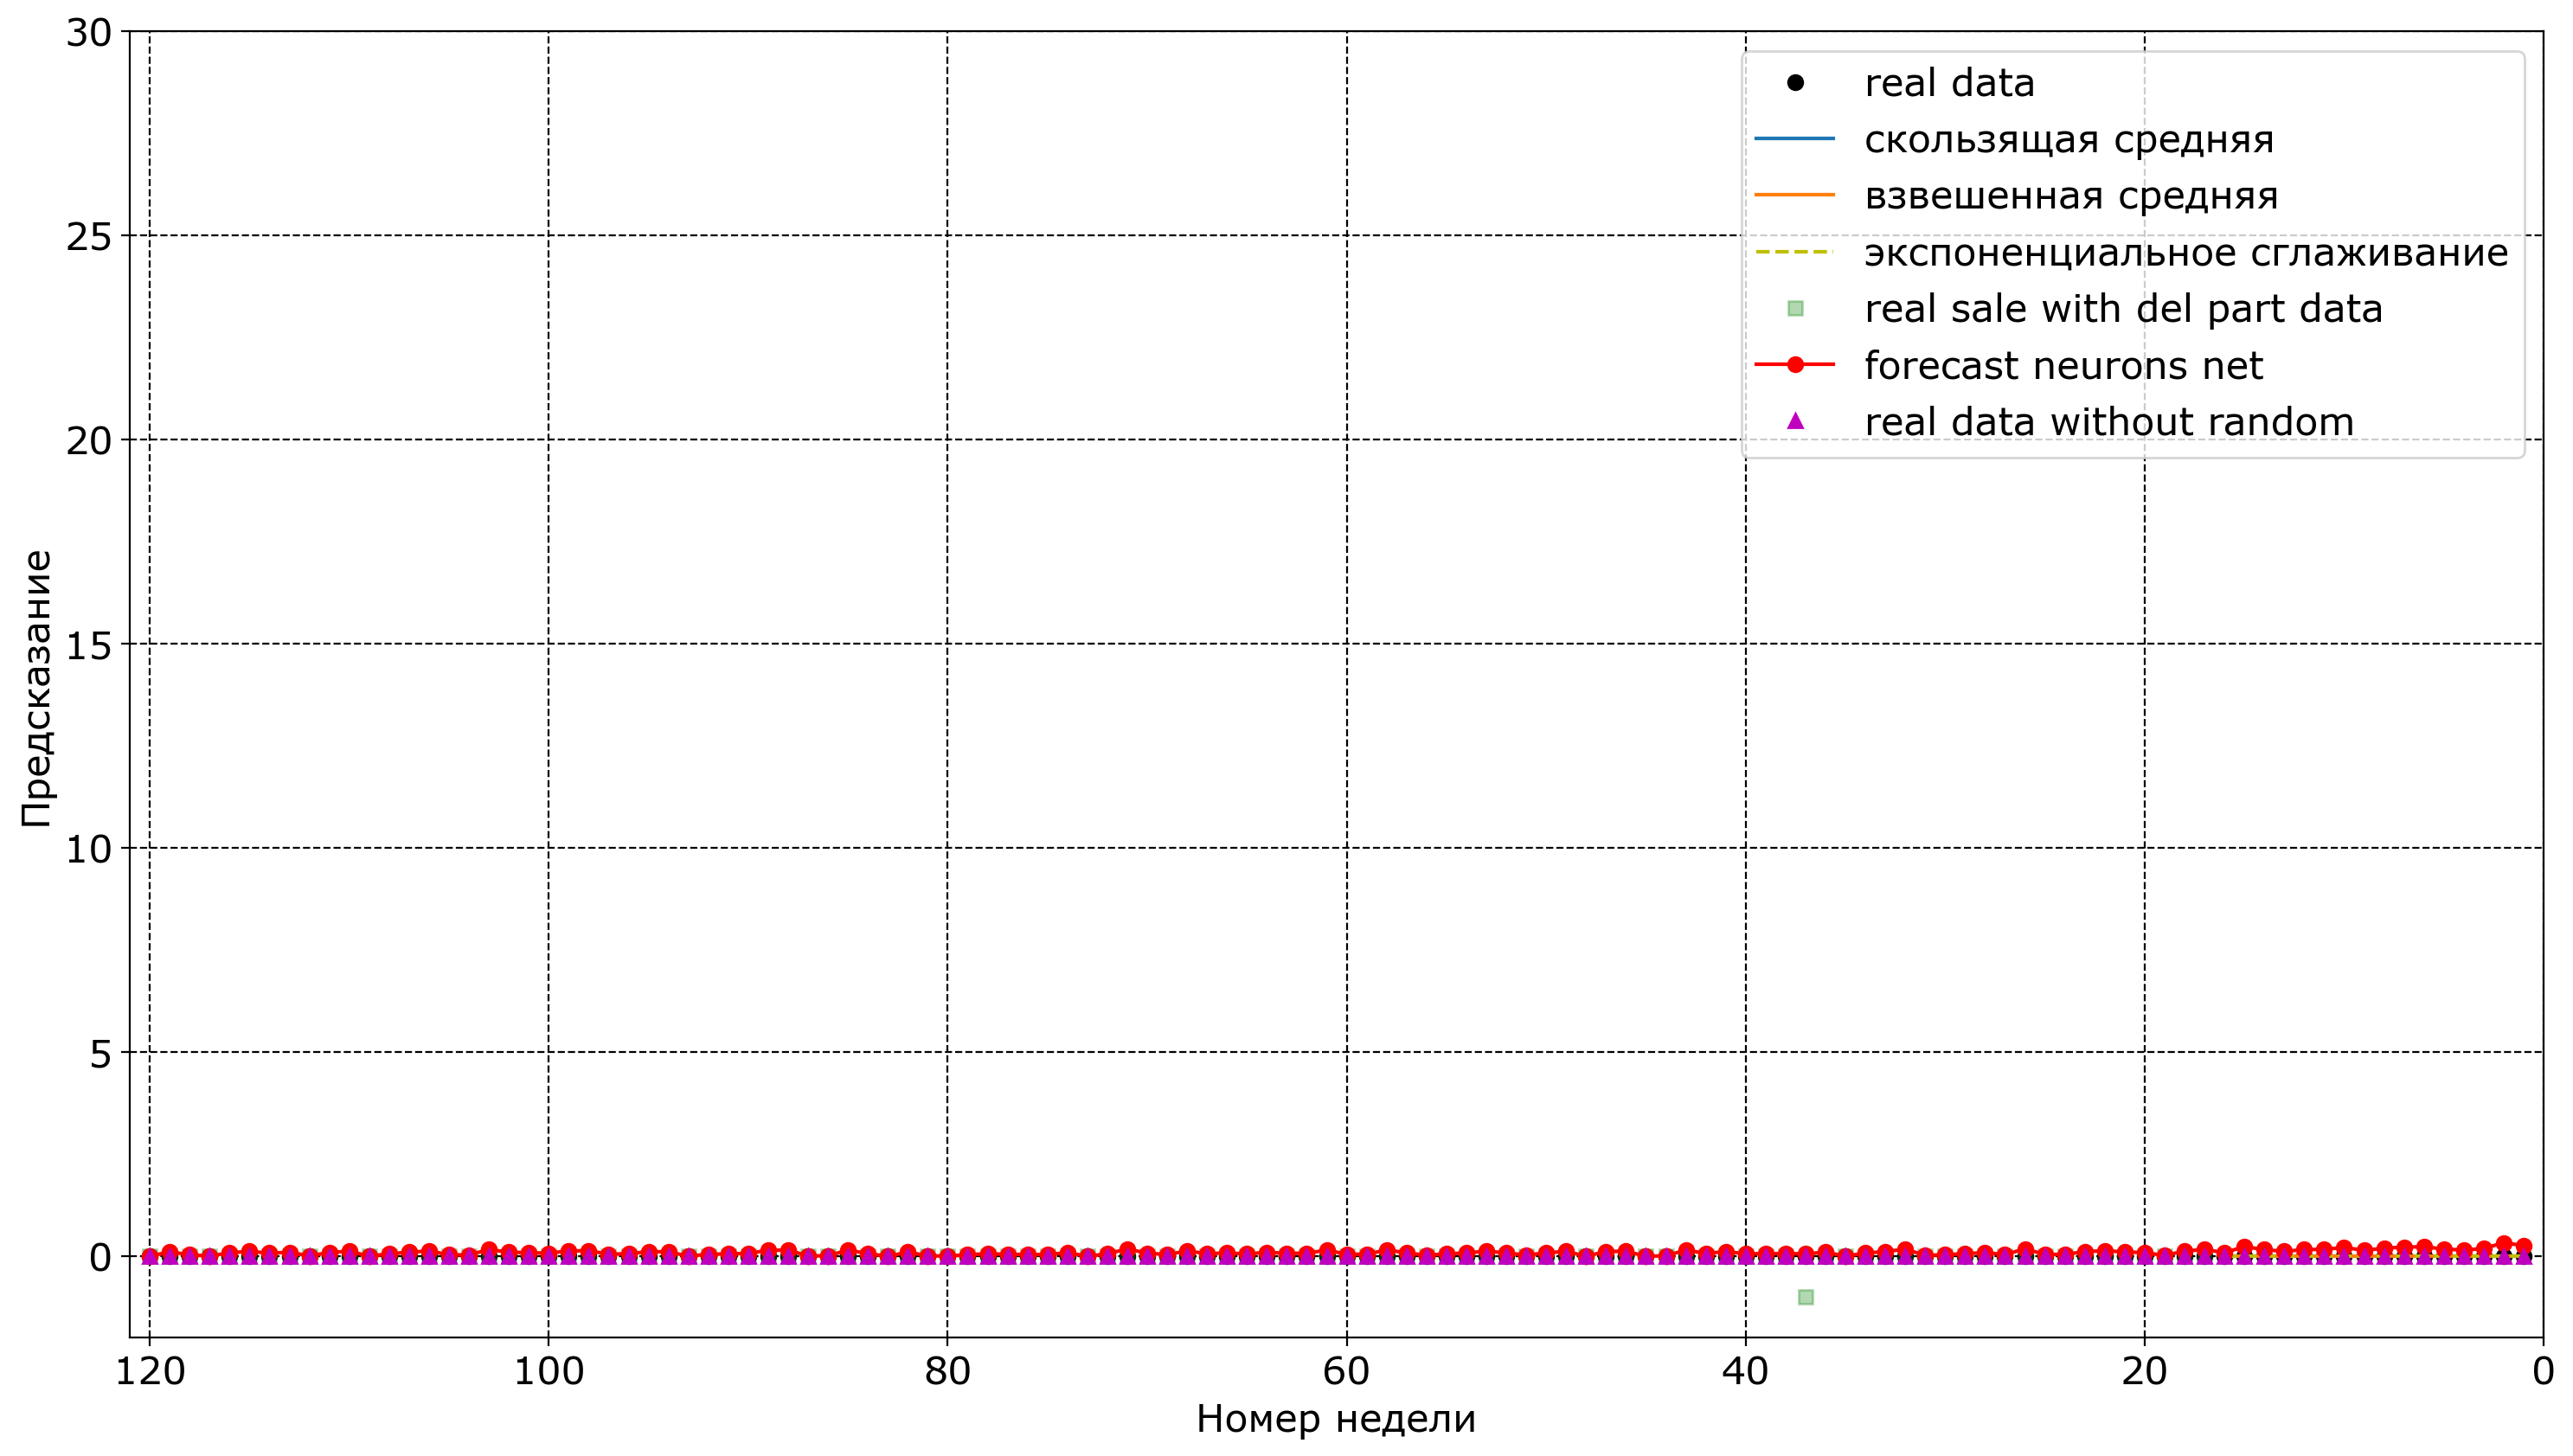

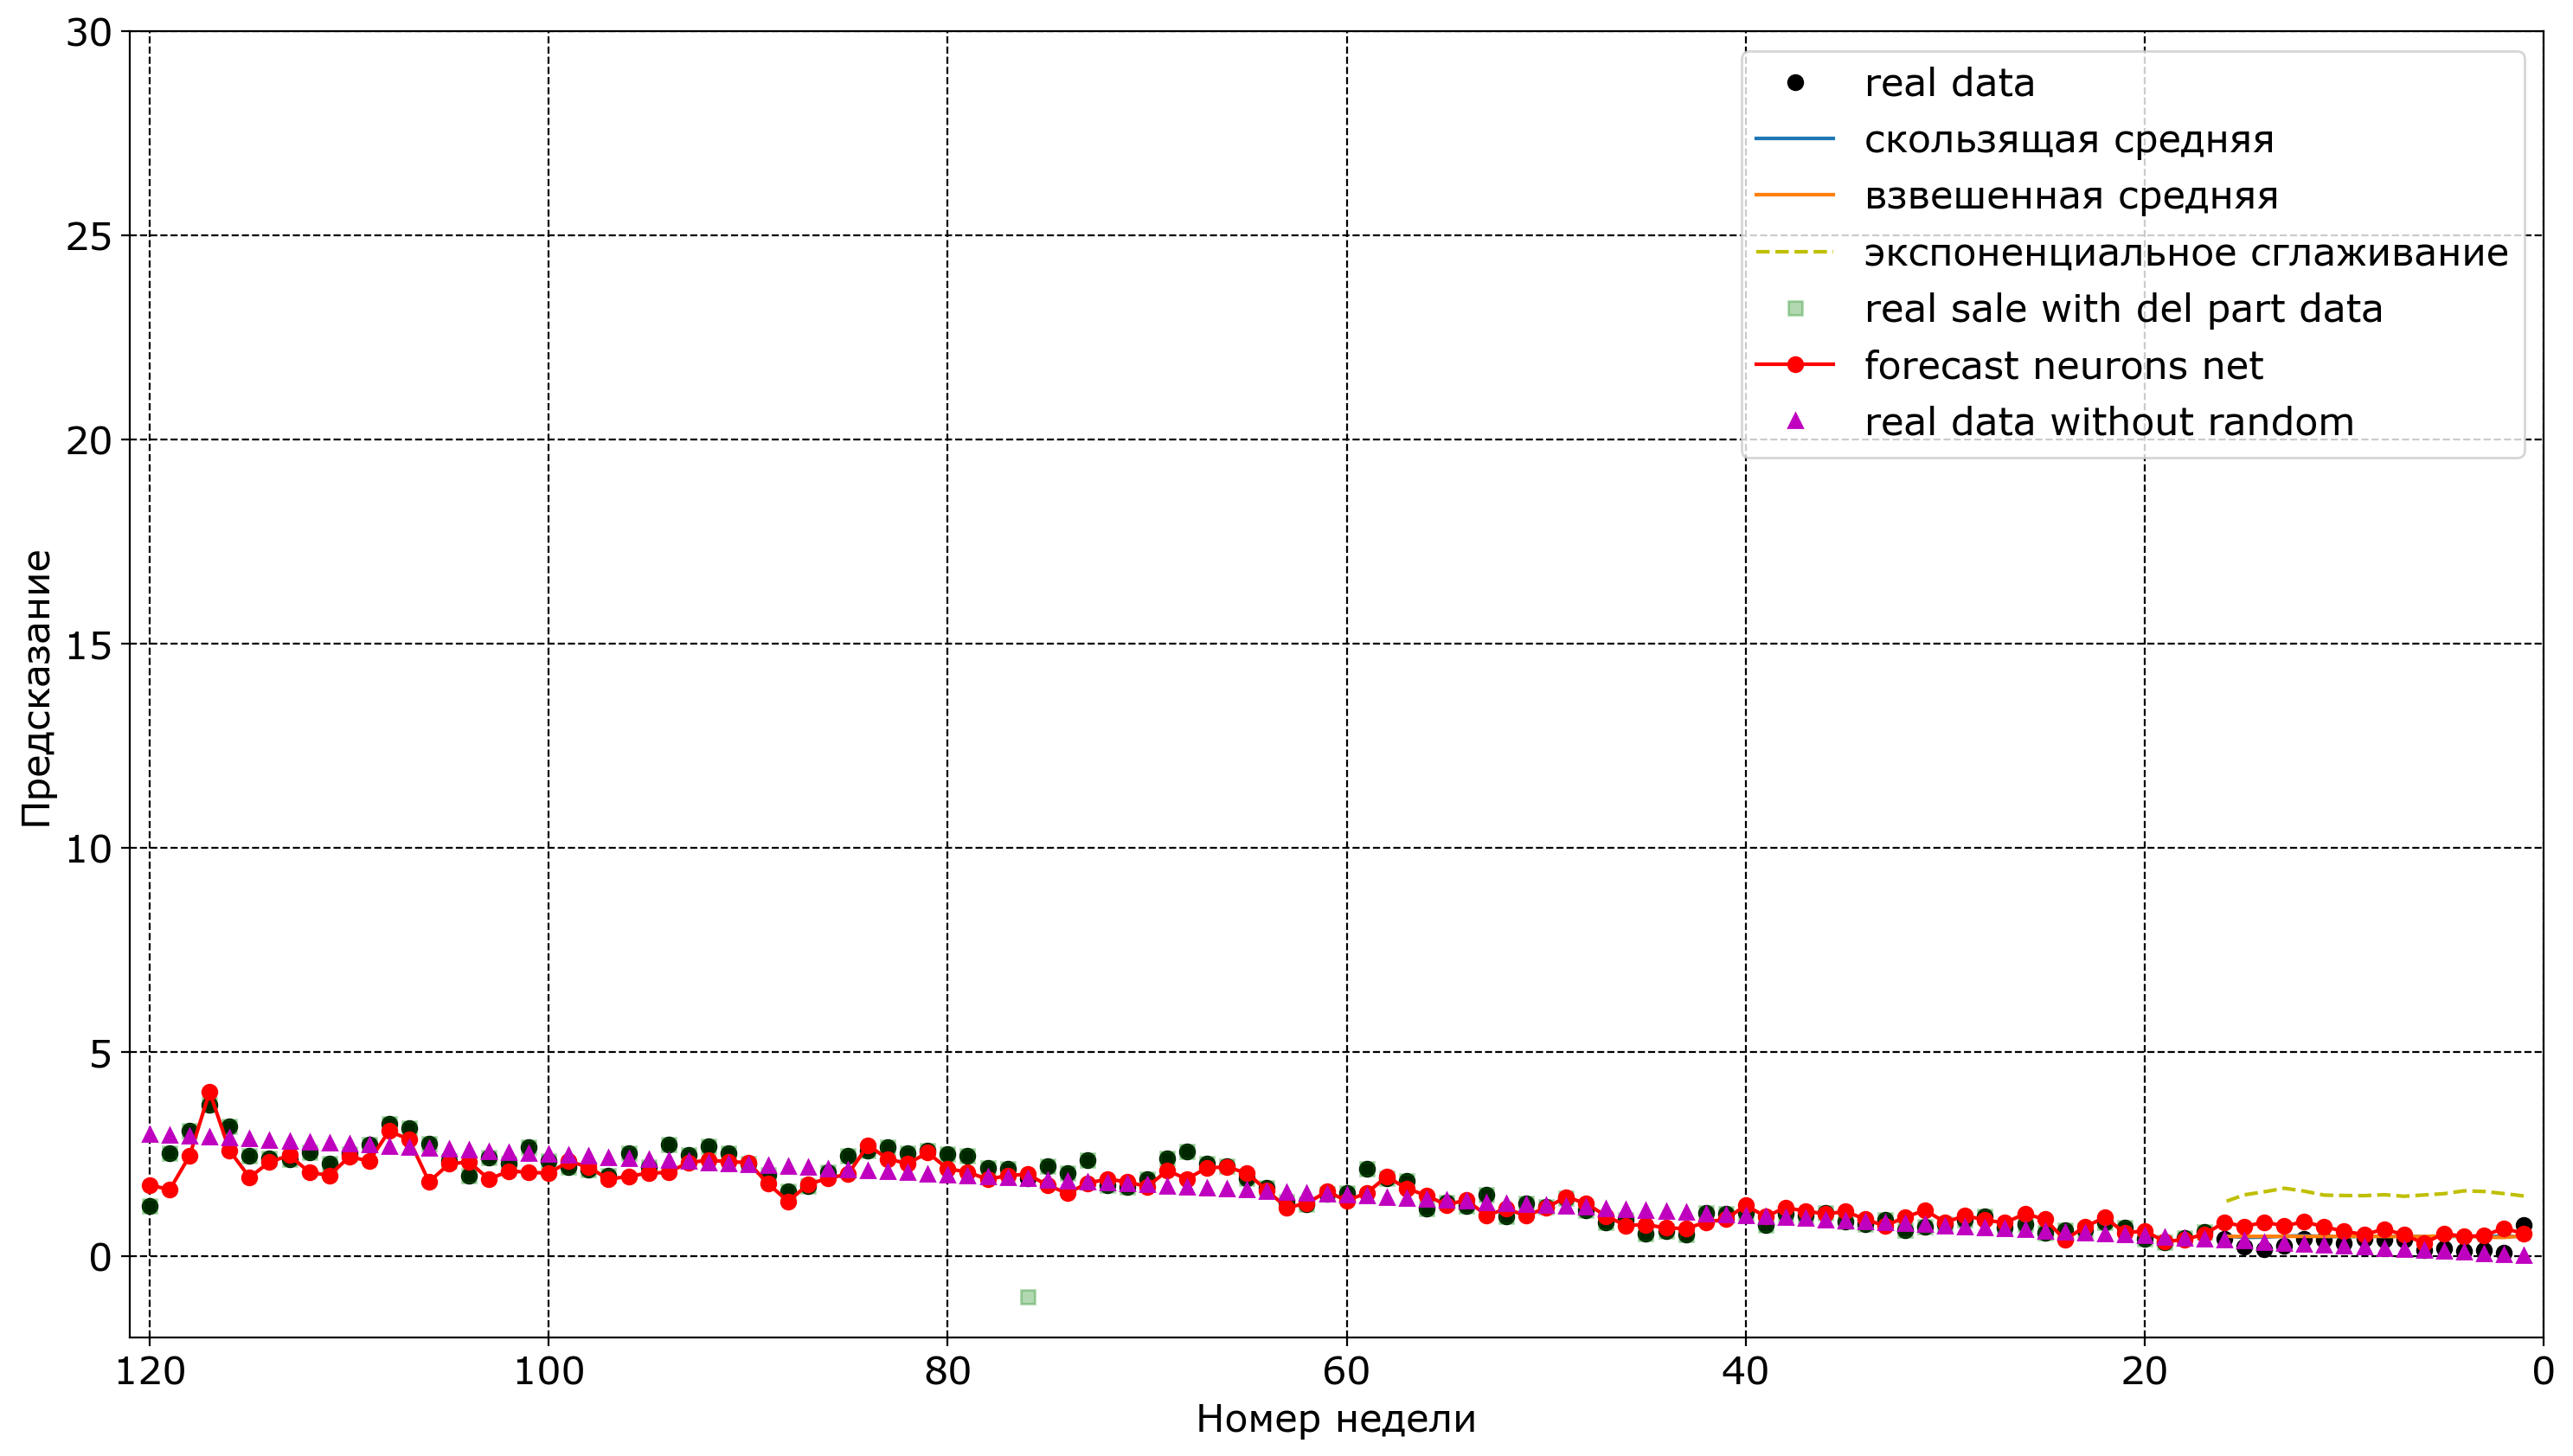

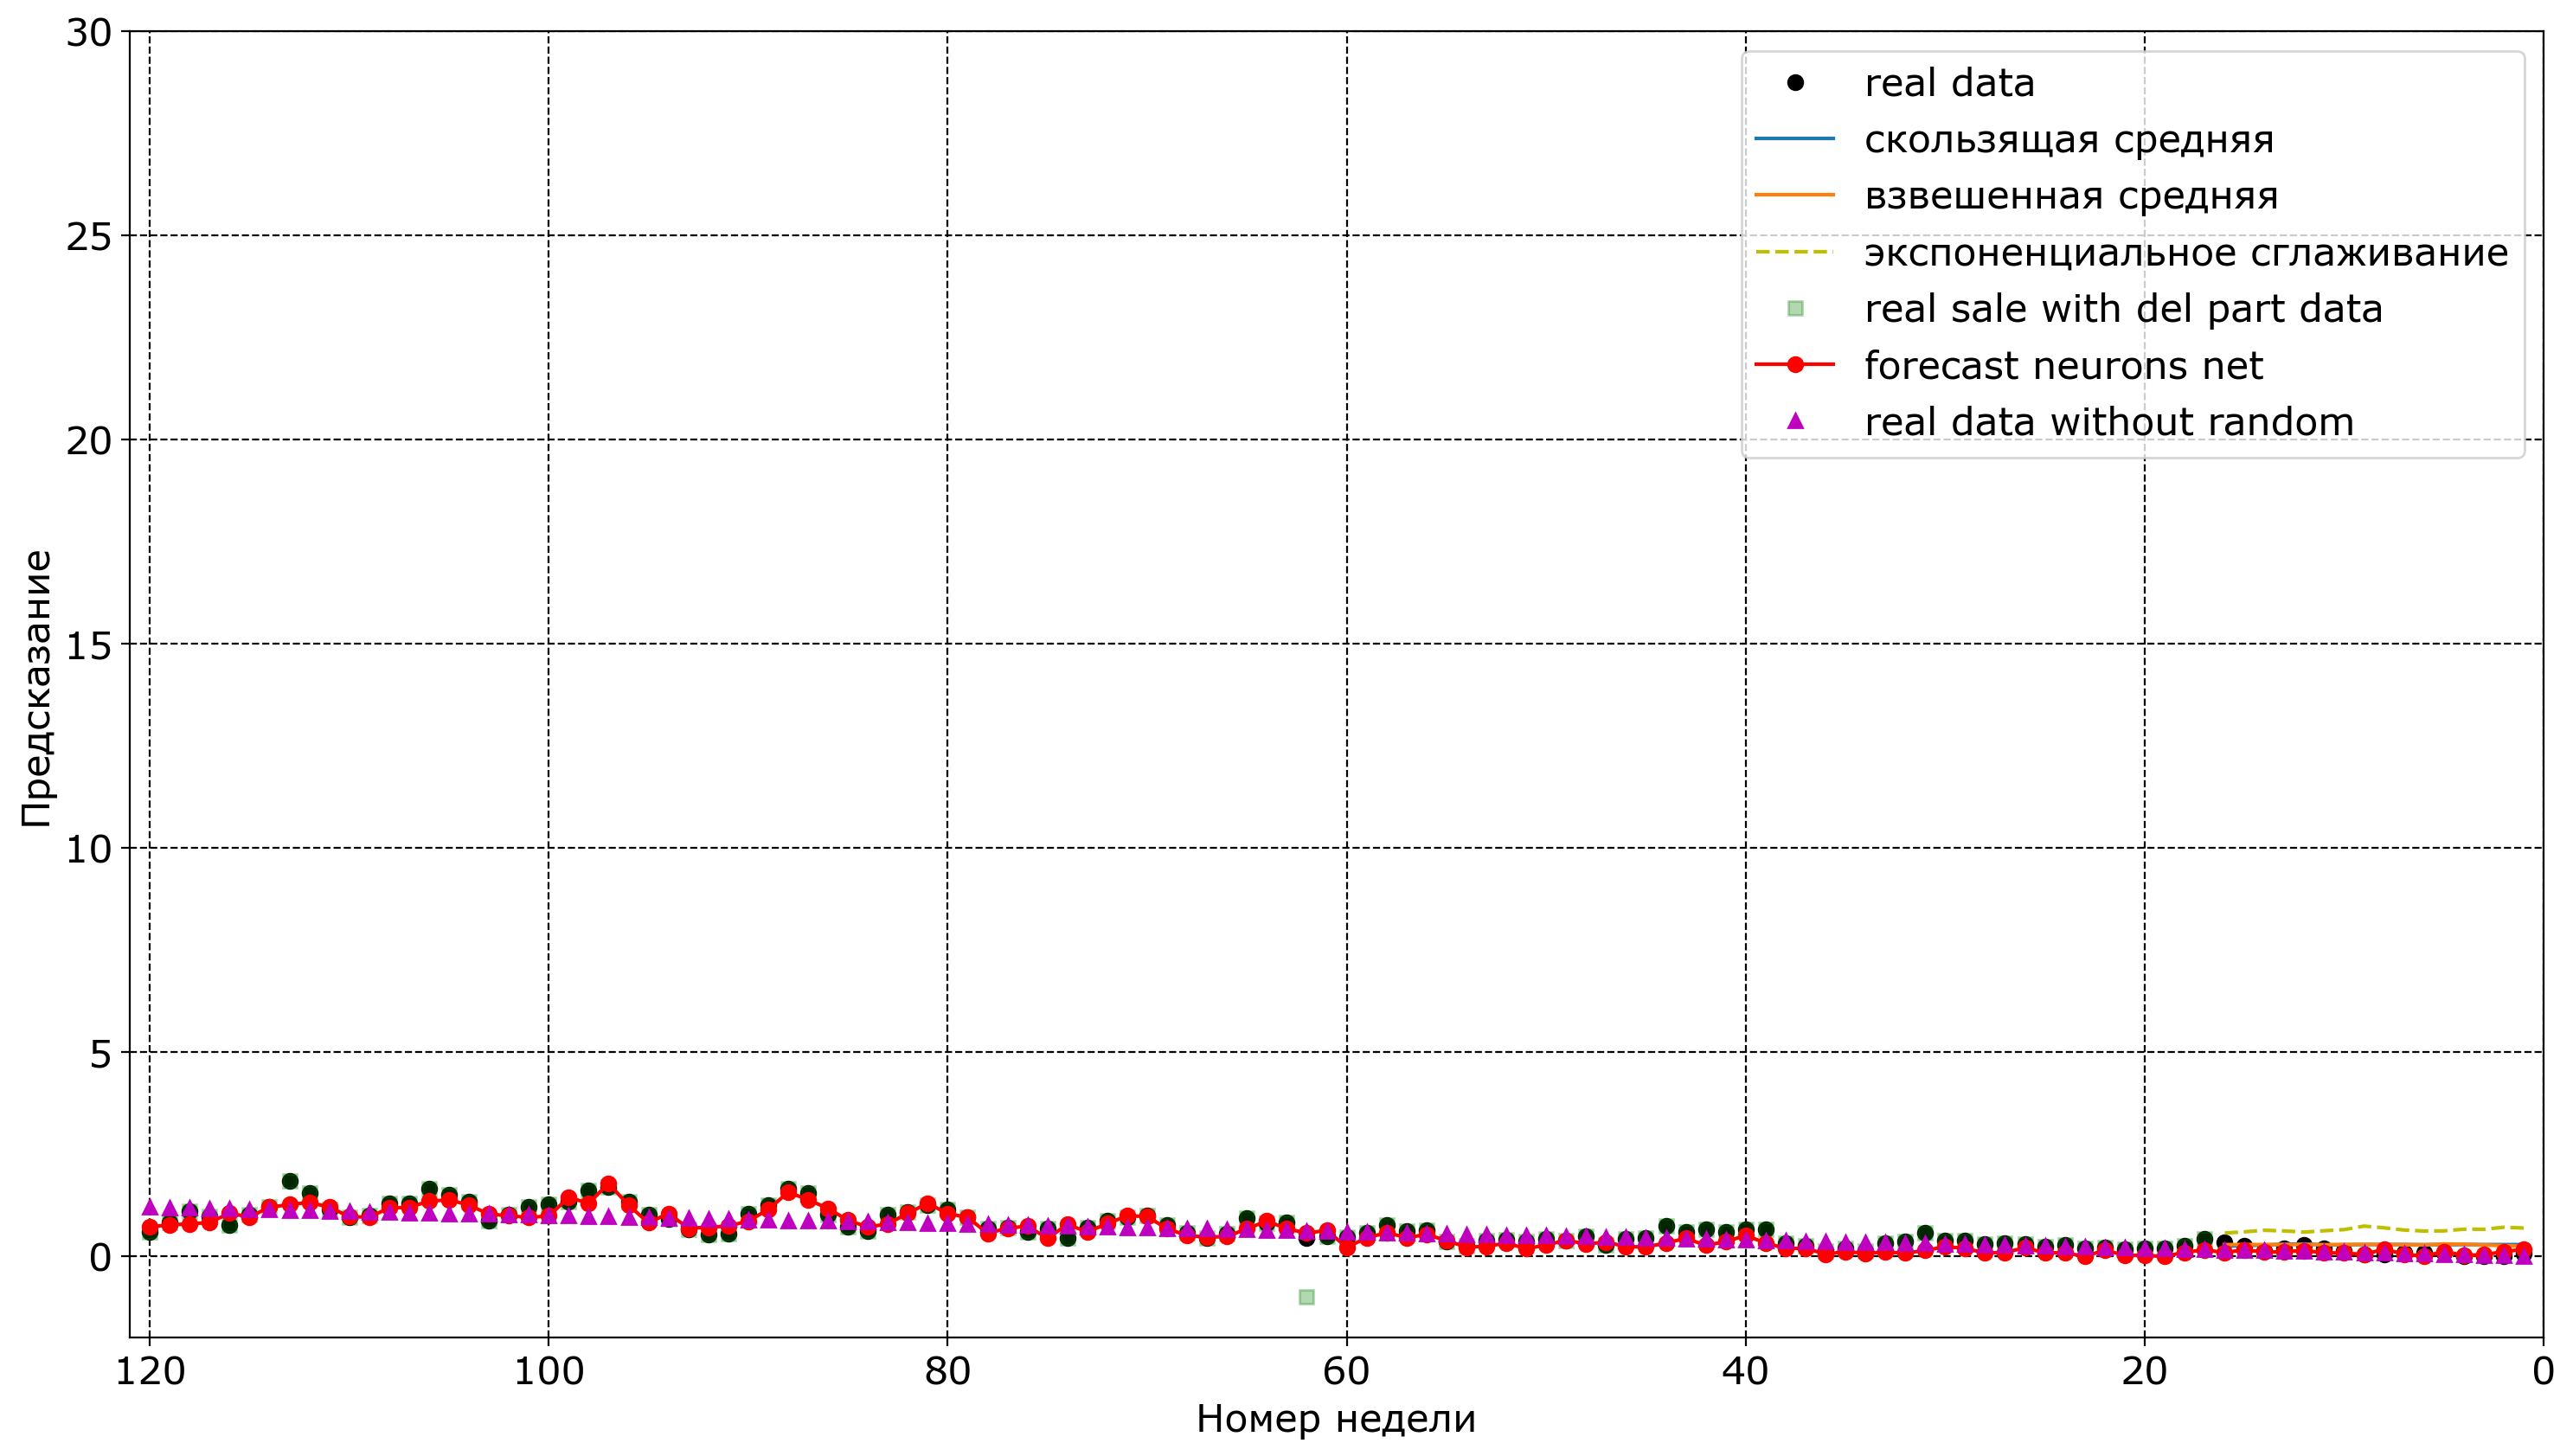

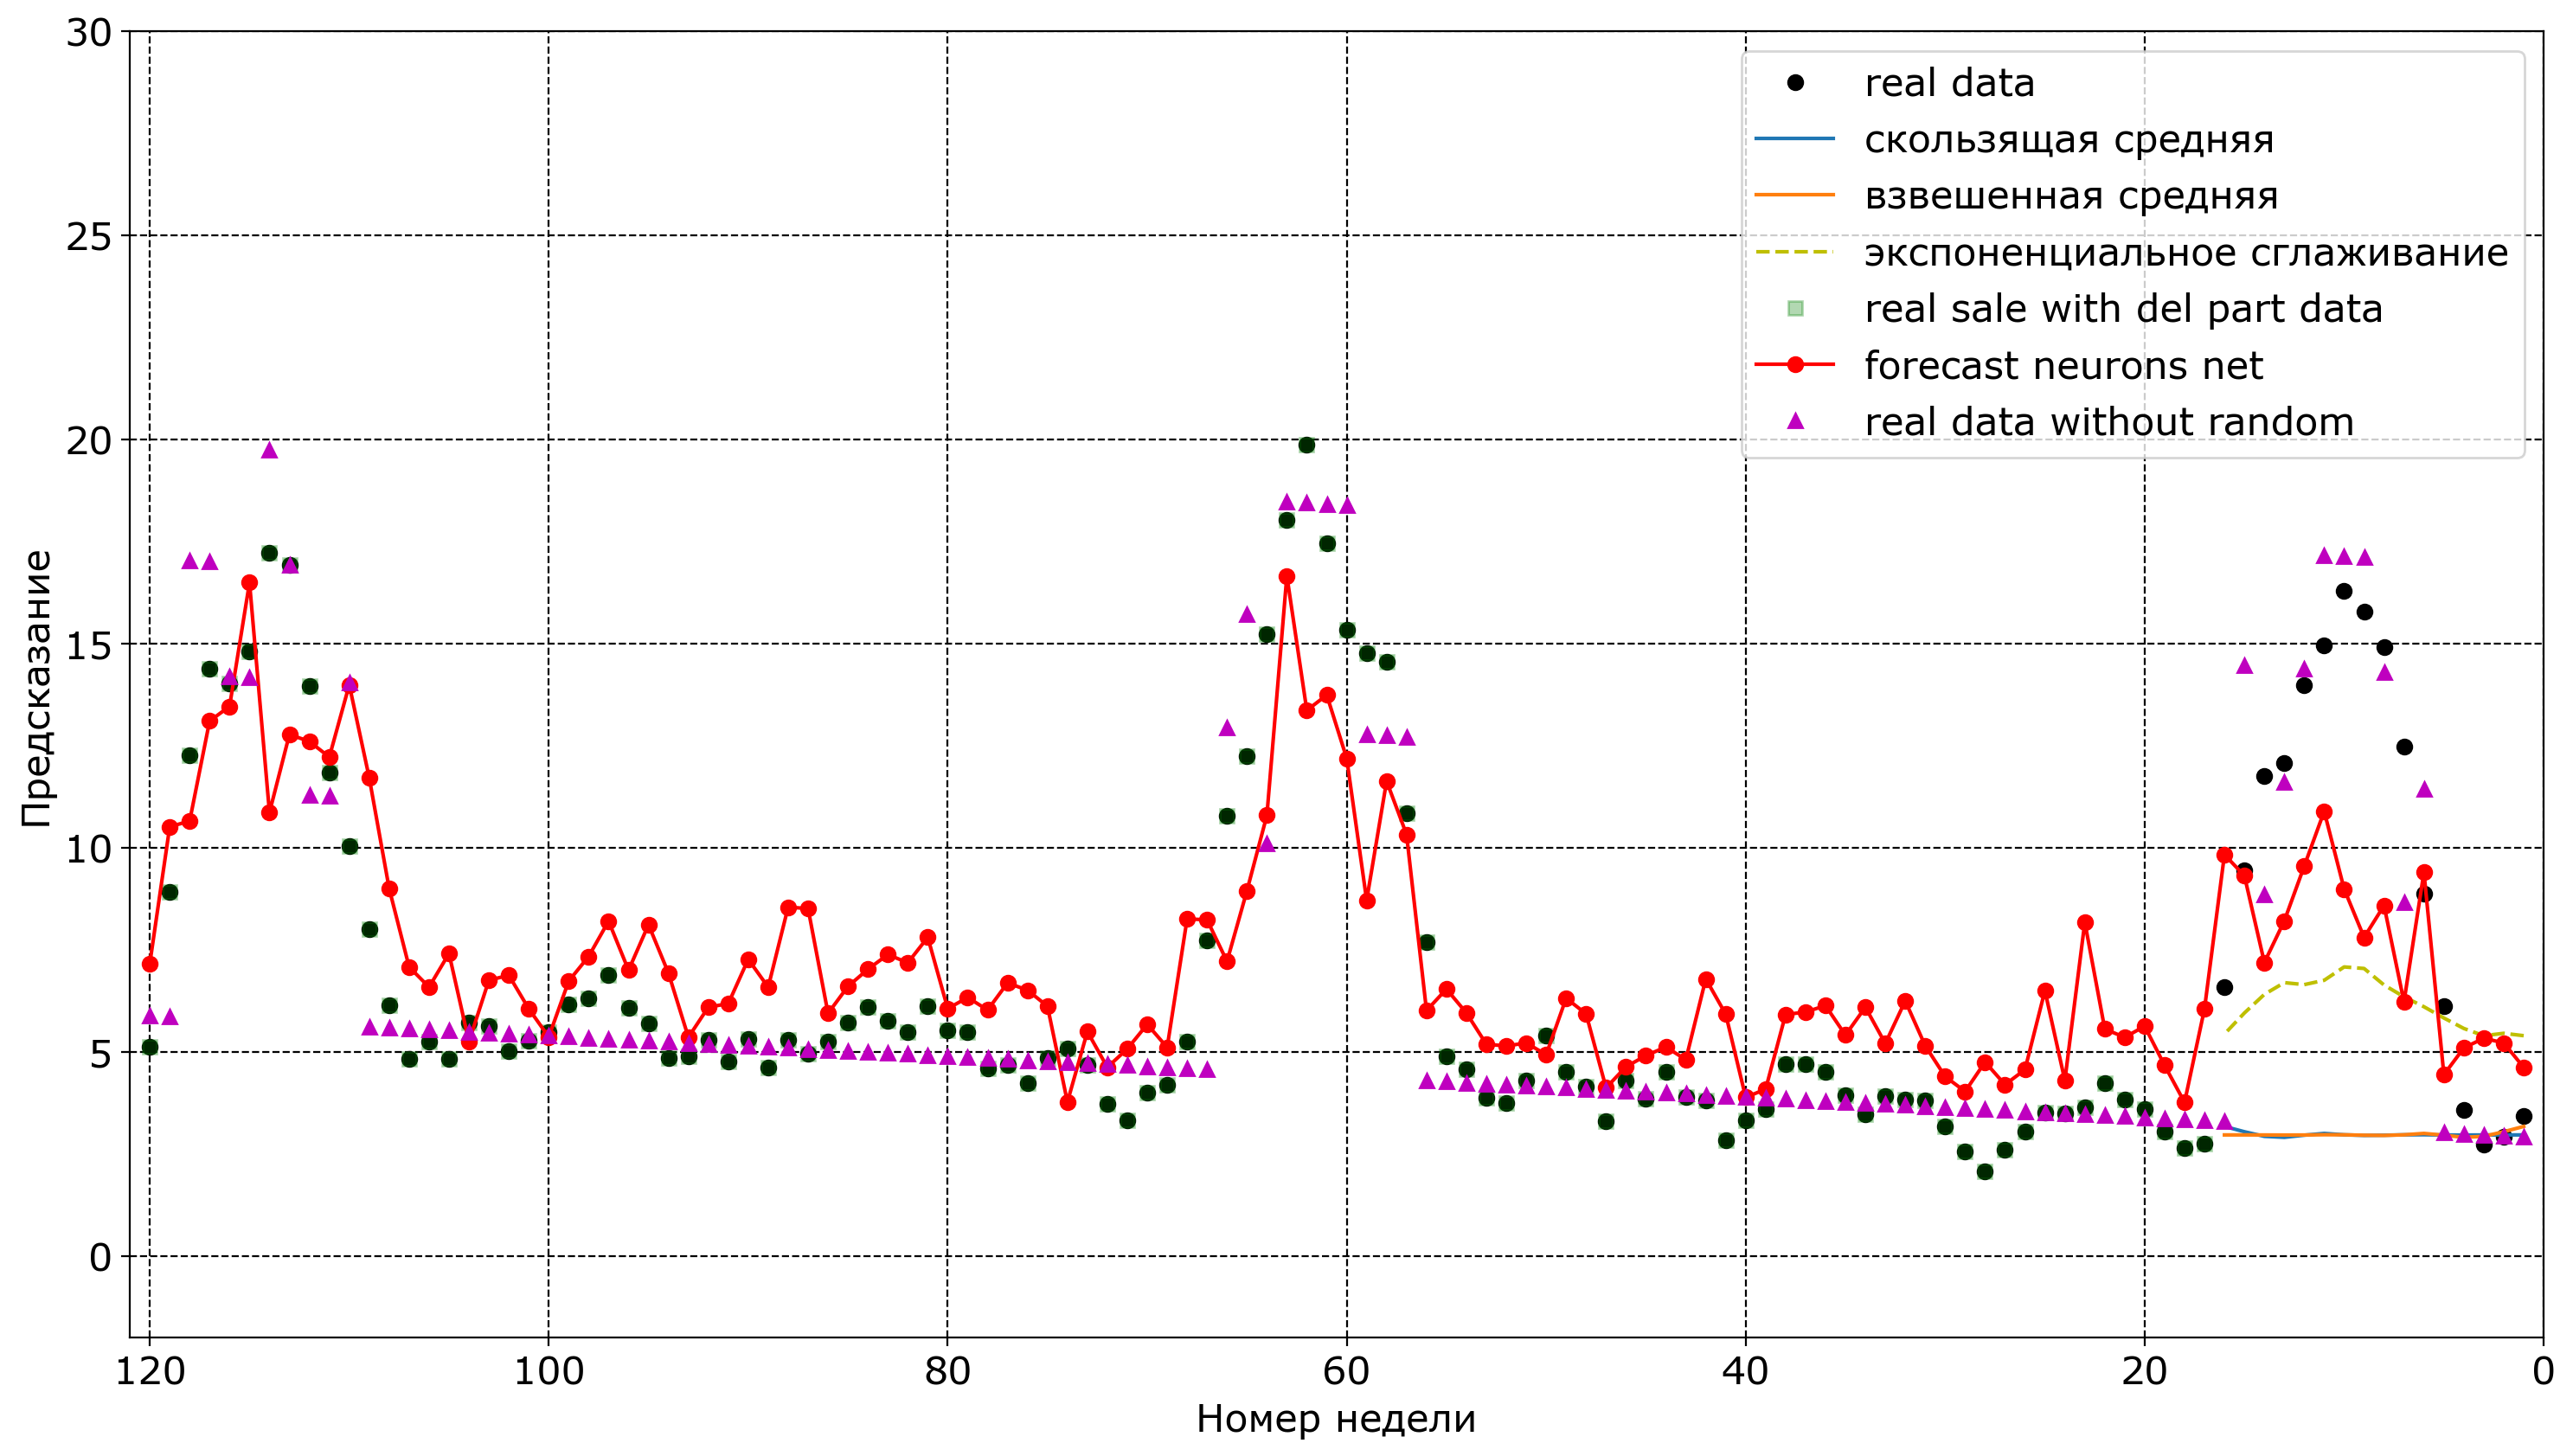

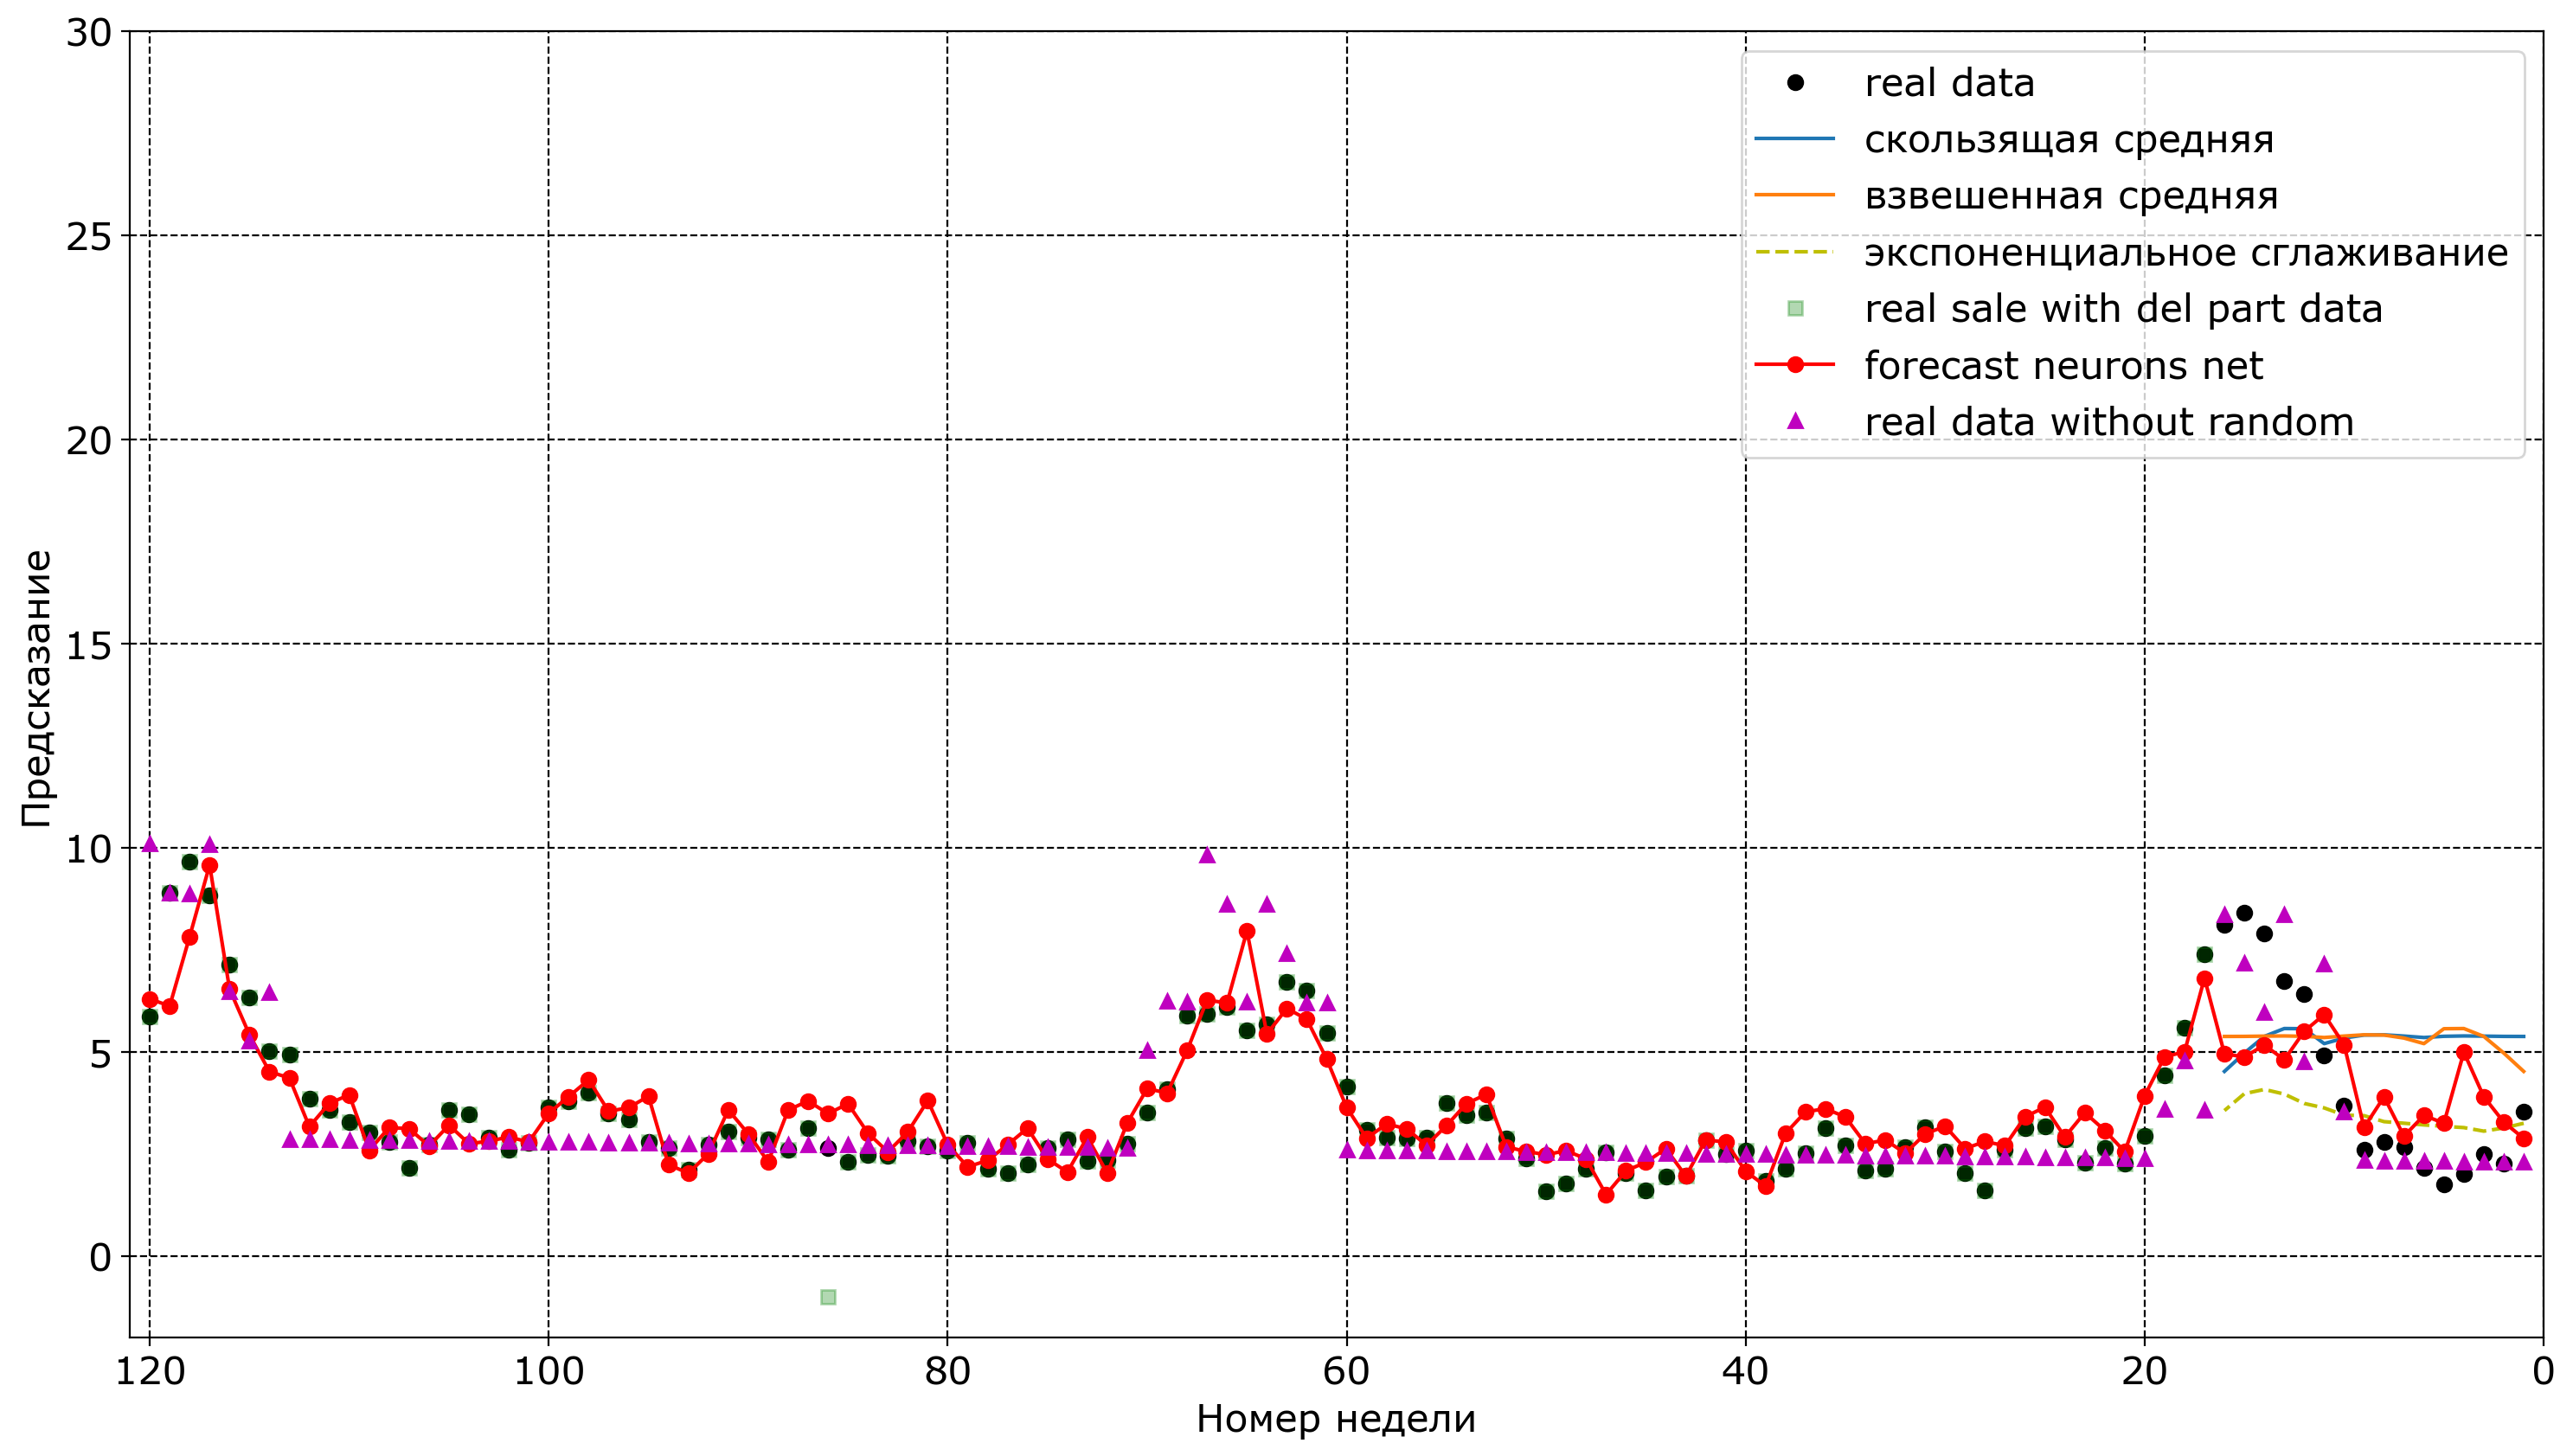

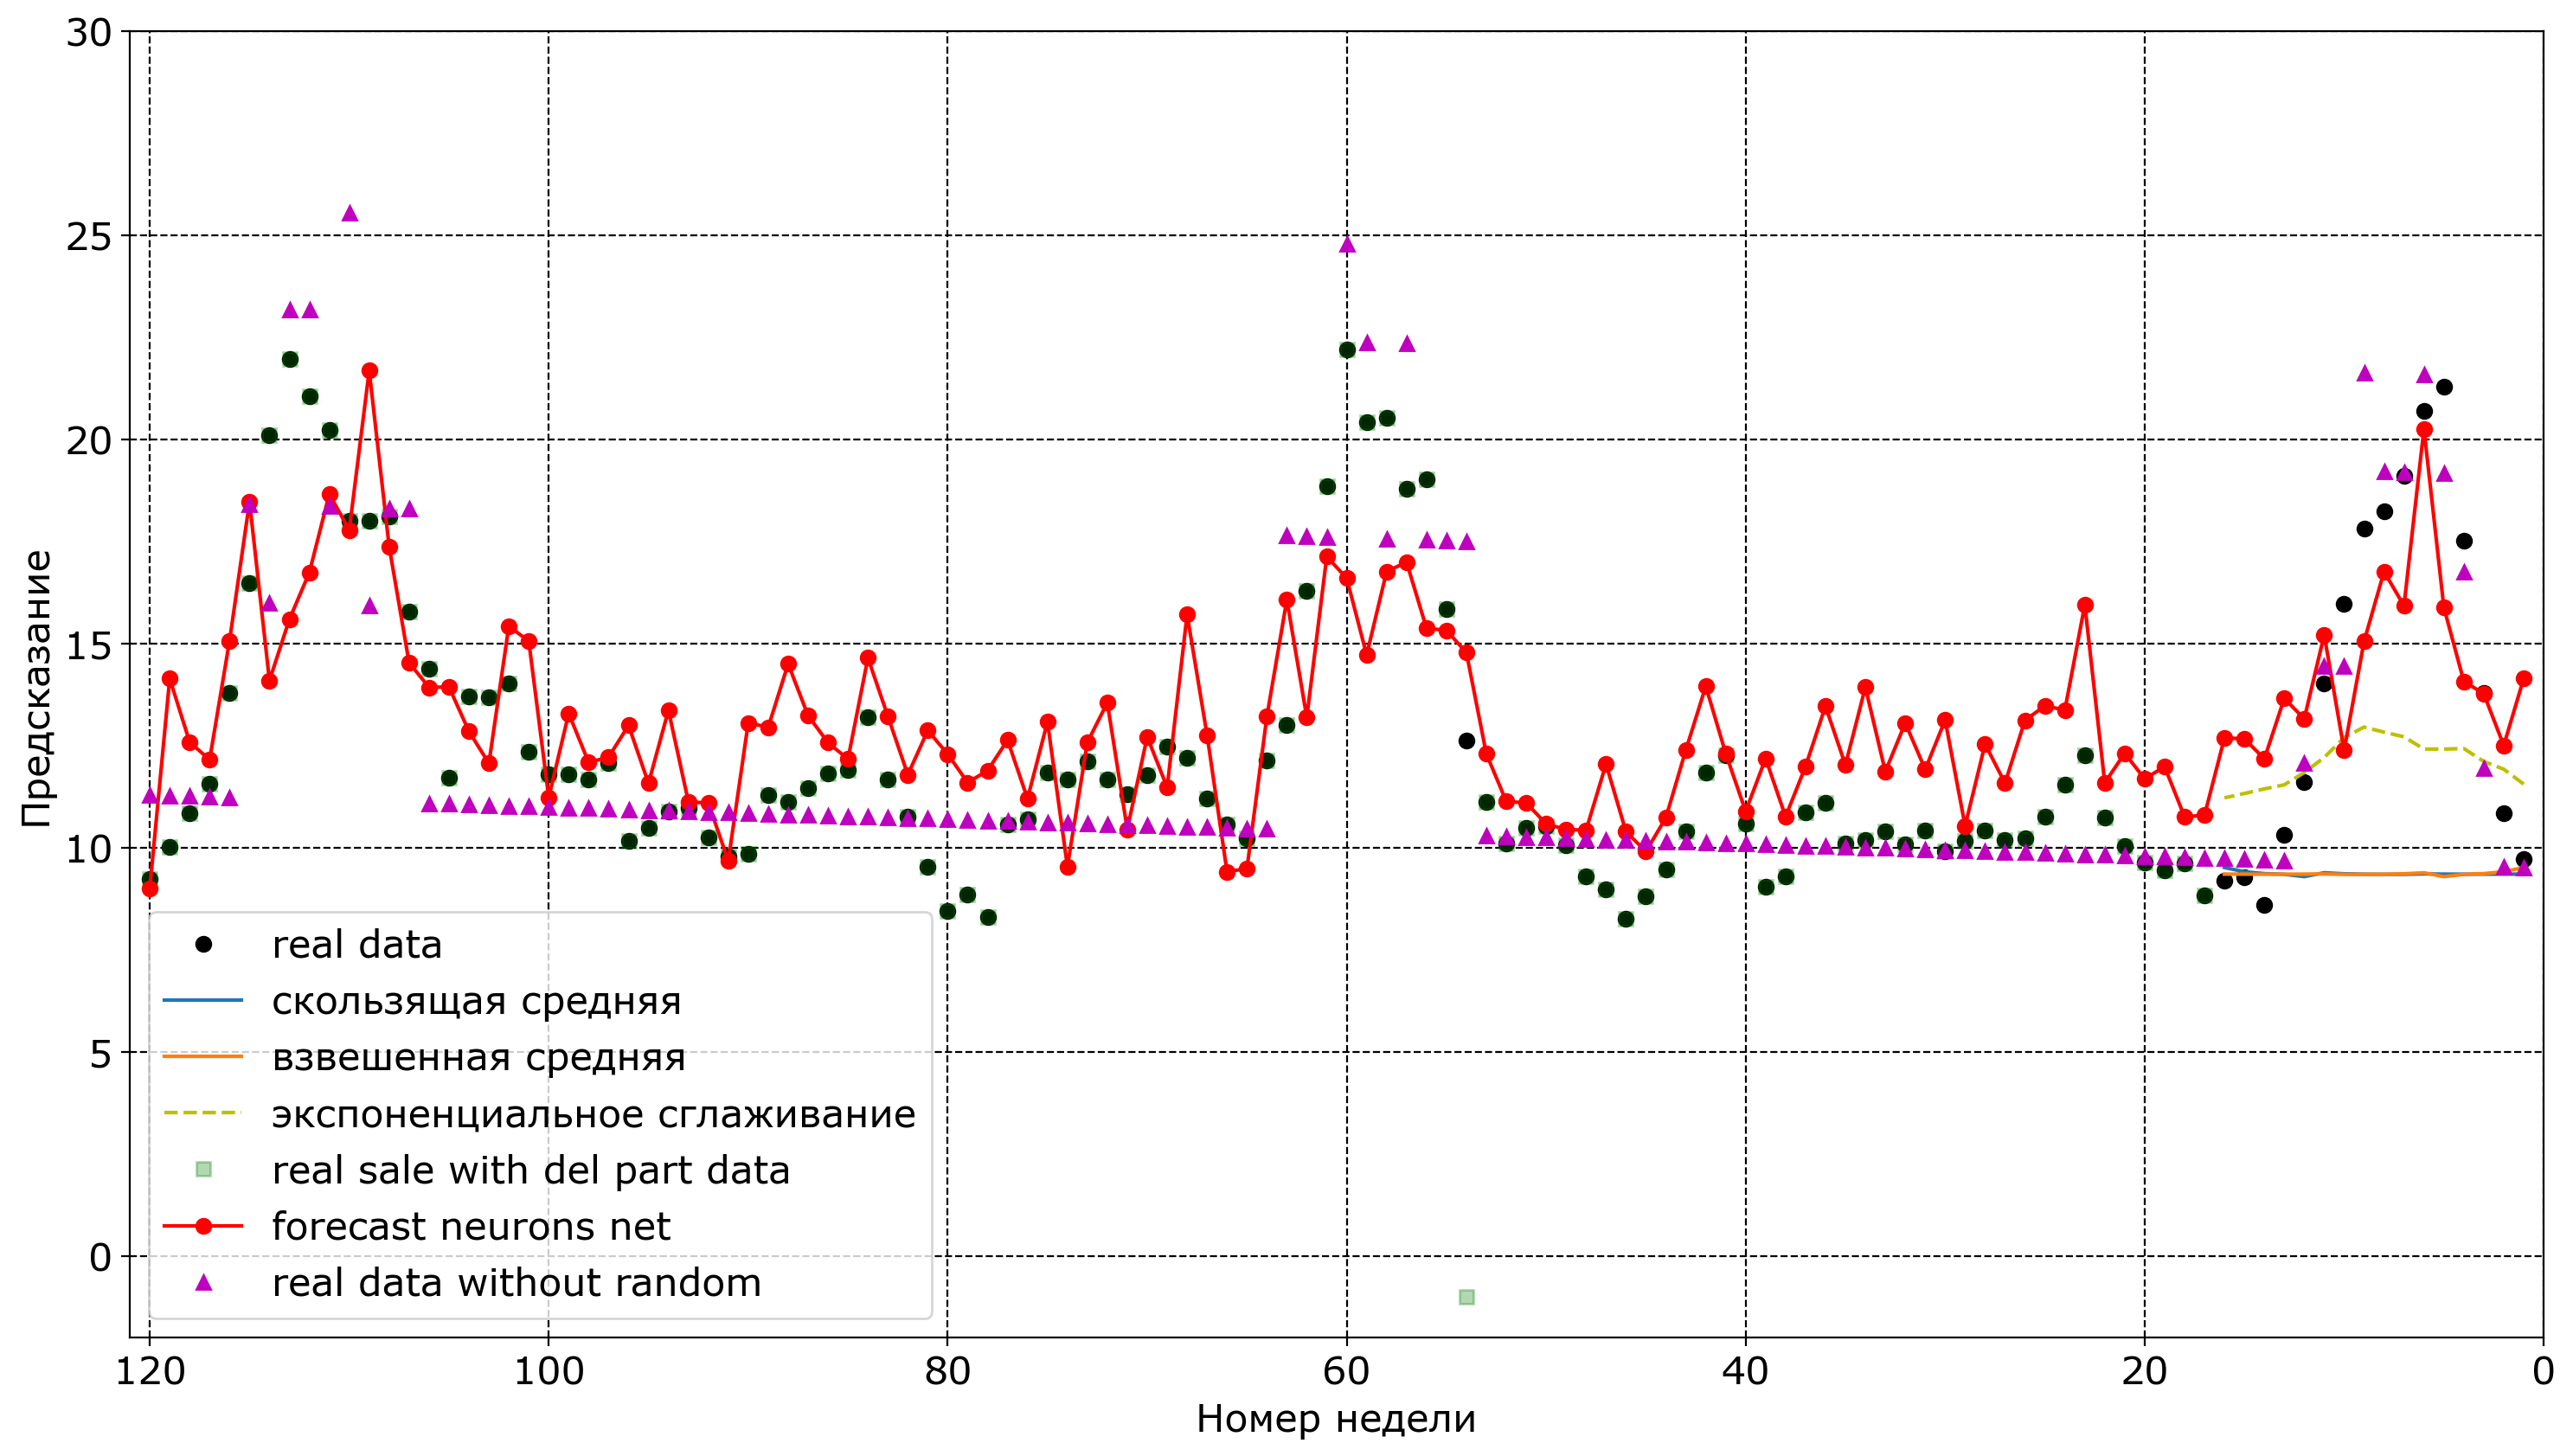

In [17]:
from sklearn.linear_model import LinearRegression

week= np.arange(1, 121)
period = week.size
iter_number = 10000
Average_sale_without_random = 0. 
MSE_NN = 0.
MD_NN = np.zeros(4)
MSE_moving_average = 0.
MD_moving_average = np.zeros(4)
MSE_moving_weights_average = 0.
MD_moving_weights_average = np.zeros(4)
MSE_ExpSmoth = 0.
MD_ExpSmoth = np.zeros(4)

err_data_before = []
err_data_after = []
err_data_item = []
err_moving_average = []
err_moving_weights_average = []
err_ExpSmoth = []

def remove_trend(data):
    """
        in data - (2-dim massive, row - article, col - sales by week)
        calculate trend use week 0 - 10 and 93 - 103
        out data - data without trend
    """
    col = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]       
    fp = np.polyfit(col, data[col], 1)
    for x in range(data.size):
        data[x] = data[x] - fp[0] * (x - 51)
    return data

for i in range(iter_number):    
    k = np.random.randint(0, 6, size=1) / 200.
    sale_trend = np.array([k[0] * x for x in week], dtype = 'f4')
    bool_reverse = np.random.choice(2, size = (1,), p = [0.5, 0.5])
    if bool_reverse:
        sale_trend = np.flip(sale_trend)
    mean_sale_value = np.random.randint(4, 100, size=1) / 10.
    sale_mean = np.full(period, mean_sale_value, dtype = 'f4')
    sale_mean_with_season = sale_mean.copy()
    slice_shift = np.random.randint(-1, 10, size=1)
    slice_1 = slice_shift + np.array([1, 2, 3, 8, 9, 10, 52, 53, 54, 59, 60, 61, 105, 106, 107, 112, 113])
    slice_1 = slice_1[slice_1 < 120]
    slice_2 =  slice_shift + np.array([4, 5, 6, 7, 55, 56, 57, 58, 108, 109, 110, 111])
    slice_2 = slice_2[slice_2 < 120]
    rate = np.random.randint(10, 35, size=1) / 10.
    sales_value = rate * np.array([1, 2, 3, 4])
    sale_mean_with_season[slice_1] += np.random.choice(sales_value, size = (len(slice_1),), p = [0.05, 0.3, 0.45, 0.2])
    sales_value = rate * np.array([3, 4, 5, 6]) 
    sale_mean_with_season[slice_2] += \
        np.random.choice(sales_value, size = (len(slice_2),), p = [0.15, 0.3, 0.4, 0.15])
    bool_season = np.random.choice(2, size = (1,), p = [0.4, 0.6])
    if bool_season:
        sale_without_random = sale_mean_with_season + sale_trend
    else:
        sale_without_random = sale_trend
    rand_σ = np.random.randint(40, 70, size= iter_number) / 100
    sale_random = (rand_σ[i] * np.sqrt(sale_without_random)) * np.random.randn(period)
    # print(sale_random)
    if bool_season:
        sale = sale_mean_with_season + sale_trend + sale_random
    else:
        sale = sale_trend + sale_random
    sale = np.where(sale < 0, 0., sale)
    # print(sale)
    
    # усреднение по  трем точкам
    tempDataSales = np.empty_like(sale)
    for iweek in range(sale.size):
        nElem = 0
        sumElem = 0.
        if sale[(iweek-1) % sale.size] != -1:
            sumElem += sale[(iweek-1) % sale.size]
            nElem += 1
        if sale[iweek % sale.size] != -1:
            sumElem += sale[iweek % sale.size]
            nElem += 1 
        if sale[(iweek+1) % sale.size] != -1:
            sumElem += sale[(iweek+1) % sale.size]
            nElem += 1     
        tempDataSales[iweek] = sumElem / nElem if nElem != 0 else -1.
    sale = tempDataSales
    
    # заполняем массив усредненными по годам недельными продажами
    meanSaleByNumberWeekInYear = np.zeros(sale.shape, dtype=np.float32)
    numWeekForSeasonal = sale.size - 16
    
    salesData_remove_trend = remove_trend(sale.copy())    
    for iWeek in range(sale.size):
        counter = 0
        x = 0.
        if salesData_remove_trend[iWeek % numWeekForSeasonal] >= 0.:
            x += salesData_remove_trend[iWeek % numWeekForSeasonal]
            counter += 1           
        if salesData_remove_trend[(iWeek + 52) % numWeekForSeasonal] >= 0.:
            x += salesData_remove_trend[(iWeek + 52) % numWeekForSeasonal]
            counter += 1
        if salesData_remove_trend[(iWeek + 104) % numWeekForSeasonal] >= 0.:
            x += salesData_remove_trend[(iWeek + 104) % numWeekForSeasonal]
            counter += 1              
        if counter > 0:    
            meanSaleByNumberWeekInYear[iWeek] = x / counter
        else:
            meanSaleByNumberWeekInYear[iWeek] = -1
            
    # используем скользящую медиану с окном шириной 3 для представления входных данных            
#     sale = np.array(skate_median(sale, 3))
#     meanSaleByNumberWeekInYear = np.array(skate_median(meanSaleByNumberWeekInYear, 3))
    # --------------------------------------------------------------------------------
    
    inSale = np.split(sale, [16])[1]
    
    first_week = np.random.randint(104)
    α = 0.1
    β = np.random.randint(15, 95, size = 1)
    size_del_data = 10
    rand_bool =  np.random.choice(2, size = (size_del_data,), p = [0.75, 0.25])
    random_diviation = np.random.randint(1, 14, size = (size_del_data,))
    list_data_del = [first_week]
    for num in range(size_del_data - 1):
        list_data_del.append(int(np.round(list_data_del[-1] + α * random_diviation[num] + β * rand_bool[num])) % 104)
    #     print(list_data_del)    
    sale_del_data = sale.copy()
    sale_del_data[list_data_del[0]] = -1.
    sale_del_to_Mean = sale.copy()
    sale_del_to_Mean[list_data_del[0]] = sale.mean()
    sale_del_to_Mean[:16] = -1
    #     print(sale_del_to_Mean)
    Average_sale_without_random += sale_without_random[0:16].mean()
    
    sale_del_to_Mean[sale_del_to_Mean != -1.] = args.logNormToNormData(sale_del_to_Mean[sale_del_to_Mean != -1.])
    sale_del_to_Mean[sale_del_to_Mean == -1.] = 1e-6
    meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear != -1.] = \
        args.logNormToNormData(meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear != -1.])
    meanSaleByNumberWeekInYear[meanSaleByNumberWeekInYear == -1.] = 1e-6
    #   -----------------------------------------------------------

    # Переверот данных (из будущего в прошлое --> из прошлого в будущее)
    sale_del_to_Mean = np.flip(sale_del_to_Mean, axis=0)
    meanSaleByNumberWeekInYear = np.flip(meanSaleByNumberWeekInYear, axis=0)  
    # -------------------------------------------------------------------
    
    #  оценка временного ряда - Neuron Network
    sale_del_to_Mean = sale_del_to_Mean.astype('f4')
    sale_del_to_Mean = sale_del_to_Mean[np.newaxis, :]
    meanSaleByNumberWeekInYear = meanSaleByNumberWeekInYear[np.newaxis, :]
    sale_del_to_Mean = np.concatenate((meanSaleByNumberWeekInYear, sale_del_to_Mean), axis = 0)
    torch_sale_del_data = torch.from_numpy(sale_del_to_Mean)
    torch_sale_del_data = torch_sale_del_data.view(1, 2, sale_del_to_Mean.shape[1])
#     print('torch_sale_del_data shape', torch_sale_del_data.shape)
    with torch.no_grad():
        y_pred= net(torch_sale_del_data.to(dtype=torch.float32))  
    y_pred = np.array(y_pred.float().squeeze(1))
    y_pred = y_pred.squeeze(0)
    
    # список ошибок прогноза до перехода от нормального распределения к логнормальному
    sale_for_err = args.logNormToNormData(sale_without_random)
    for k in range(16):
        err_data_before.append(np.flip(y_pred)[k] - sale_for_err[k])
    # --------------------------------------------------------------------------------
    
    #  здесь переход от нормального распределения к логнормальному
    sale_del_to_Mean = args.normToLogNormData(sale_del_to_Mean)
    y_pred = args.normToLogNormData(y_pred)
    y_pred[y_pred < 0.] = 0. # прогноз нейронной сети
    # -------------------------------------------------------------
    # сглаживаем прогноз
#     y_pred = skate_median(y_pred, 3)   
    # список ошибок прогноза после перехода от нормального распределения к логнормальному
    for k in range(16):
#         err_data_after.append(np.flip(y_pred)[k] - sale_without_random[k])
        err_data_after.append(np.flip(y_pred)[k] - sale[k])
#     err_data_item.append((np.flip(y_pred)[0:16] - sale_without_random[0:16]).sum())
    err_data_item.append((np.flip(y_pred)[0:16] - sale[0:16]).sum())
    # -----------------------------
#     MSE_NN += np.sqrt(pow((np.flip(y_pred)[0:16] - sale_without_random[0:16]), 2).mean())
#     MD_NN[0] += np.abs((np.flip(y_pred)[0:16] - sale_without_random[0:16]).sum())
#     MD_NN[1] += np.abs((np.flip(y_pred)[0:12] - sale_without_random[0:12]).sum())
#     MD_NN[2] += np.abs((np.flip(y_pred)[0:8] - sale_without_random[0:8]).sum())
#     MD_NN[3] += np.abs((np.flip(y_pred)[0:4] - sale_without_random[0:4]).sum())
    MSE_NN += np.sqrt(pow((np.flip(y_pred)[0:16] - sale[0:16]), 2).mean())
    MD_NN[0] += np.abs((np.flip(y_pred)[0:16] - sale[0:16]).sum())
    MD_NN[1] += np.abs((np.flip(y_pred)[0:12] - sale[0:12]).sum())
    MD_NN[2] += np.abs((np.flip(y_pred)[0:8] - sale[0:8]).sum())
    MD_NN[3] += np.abs((np.flip(y_pred)[0:4] - sale[0:4]).sum())
    # ------------------------------------NN---------------------------
    # оценка временного ряда - скользящая средняя
    cur_series = inSale[:5].copy()
    cur_series = np.flip(cur_series)
    rolling_mean_sale = np.array([np.mean(cur_series)])
    for _ in range(15):
        cur_series = np.hstack((cur_series[1:], rolling_mean_sale[-1]))
        rolling_mean_sale = np.hstack((rolling_mean_sale, np.mean(cur_series)))
    rolling_mean_sale = np.flip(rolling_mean_sale)
#     MSE_moving_average += np.sqrt(pow((rolling_mean_sale - sale_without_random[0:16]), 2).mean())
#     MD_moving_average[0] += np.abs((rolling_mean_sale - sale_without_random[0:16]).sum())
#     MD_moving_average[1] += np.abs((rolling_mean_sale[0:12] - sale_without_random[0:12]).sum())
#     MD_moving_average[2] += np.abs((rolling_mean_sale[0:8] - sale_without_random[0:8]).sum())
#     MD_moving_average[3] += np.abs((rolling_mean_sale[0:4] - sale_without_random[0:4]).sum())
    MSE_moving_average += np.sqrt(pow((rolling_mean_sale - sale[0:16]), 2).mean())
    MD_moving_average[0] += np.abs((rolling_mean_sale - sale[0:16]).sum())
    MD_moving_average[1] += np.abs((rolling_mean_sale[0:12] - sale[0:12]).sum())
    MD_moving_average[2] += np.abs((rolling_mean_sale[0:8] - sale[0:8]).sum())
    MD_moving_average[3] += np.abs((rolling_mean_sale[0:4] - sale[0:4]).sum())
    for k in range(16):
        err_moving_average.append(rolling_mean_sale[15 - k] - sale[15 - k])  
    # --------------------------------------------
    # оценка временного ряда - взвешенная средняя    
    weights = np.array([0.06, 0.12, 0.19, 0.27, 0.36])
    cur_series = inSale[:5].copy()
    cur_series = np.flip(cur_series)
    rolling_weights_mean_sale = np.array([np.mean(cur_series * weights)])
    for _ in range(15):
        cur_series = np.hstack((cur_series[1:], rolling_mean_sale[-1]))
        rolling_weights_mean_sale = np.hstack((rolling_weights_mean_sale, np.mean(cur_series * weights)))
    rolling_weights_mean_sale = np.flip(rolling_mean_sale)        
#     MSE_moving_weights_average += np.sqrt(pow((rolling_weights_mean_sale - sale_without_random[0:16]), 2).mean())
#     MD_moving_weights_average[0] += np.abs(
#                 (rolling_weights_mean_sale - sale_without_random[0:16]).sum())
#     MD_moving_weights_average[1] += np.abs(
#                 (rolling_weights_mean_sale[0:12] - sale_without_random[0:12]).sum())
#     MD_moving_weights_average[2] += np.abs(
#                 (rolling_weights_mean_sale[0:8] - sale_without_random[0:8]).sum())
#     MD_moving_weights_average[3] += np.abs(
#                 (rolling_weights_mean_sale[0:4] - sale_without_random[0:4]).sum())
    MSE_moving_weights_average += np.sqrt(pow((rolling_weights_mean_sale - sale[0:16]), 2).mean())
    MD_moving_weights_average[0] += np.abs(
                (rolling_weights_mean_sale - sale[0:16]).sum())
    MD_moving_weights_average[1] += np.abs(
                (rolling_weights_mean_sale[0:12] - sale[0:12]).sum())
    MD_moving_weights_average[2] += np.abs(
                (rolling_weights_mean_sale[0:8] - sale[0:8]).sum())
    MD_moving_weights_average[3] += np.abs(
                (rolling_weights_mean_sale[0:4] - sale[0:4]).sum())
    for k in range(16):
        err_moving_weights_average.append(rolling_weights_mean_sale[15 - k] - sale[15 - k]) 
        
    # -------------------------------------------
    # оценка временного ряда - экспоненциальное сглаживание
    def exponential_smoothing(series, alpha):
        result = [series[0]] # first value is same as series
        for n in range(1, len(series)):
            result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        return result[-1]
    cur_series = inSale.copy()
    alpha = 0.019
    cur_series = np.flip(cur_series)
    exp_smoth_forecast_sale = np.array([exponential_smoothing(cur_series, alpha)])
    for _ in range(15):
        cur_series = np.hstack([cur_series[1:], exp_smoth_forecast_sale[-1]])
        exp_smoth_forecast_sale = np.hstack([exp_smoth_forecast_sale, exponential_smoothing(cur_series, alpha)])
    exp_smoth_forecast_sale = np.flip(exp_smoth_forecast_sale)    
#     MSE_ExpSmoth += np.sqrt(pow((exp_smoth_forecast_sale - sale_without_random[0:16]), 2).mean())
#     MD_ExpSmoth[0] += np.abs((exp_smoth_forecast_sale - sale_without_random[0:16]).sum())
#     MD_ExpSmoth[1] += np.abs((exp_smoth_forecast_sale[0:12] - sale_without_random[0:12]).sum())
#     MD_ExpSmoth[2] += np.abs((exp_smoth_forecast_sale[0:8] - sale_without_random[0:8]).sum())
#     MD_ExpSmoth[3] += np.abs((exp_smoth_forecast_sale[0:4] - sale_without_random[0:4]).sum())
    MSE_ExpSmoth += np.sqrt(pow((exp_smoth_forecast_sale - sale[0:16]), 2).mean())
    MD_ExpSmoth[0] += np.abs((exp_smoth_forecast_sale - sale[0:16]).sum())
    MD_ExpSmoth[1] += np.abs((exp_smoth_forecast_sale[0:12] - sale[0:12]).sum())
    MD_ExpSmoth[2] += np.abs((exp_smoth_forecast_sale[0:8] - sale[0:8]).sum())
    MD_ExpSmoth[3] += np.abs((exp_smoth_forecast_sale[0:4] - sale[0:4]).sum()) 
    for k in range(16):
        err_ExpSmoth.append(exp_smoth_forecast_sale[15 - k] - sale[15 - k]) 
        
    # ------------------------------------------------------
    if i % 1000 == 999:
#         %matplotlib inline
        plt.rc('font', family='Verdana')
        plt.rcParams.update({'font.size': 16, 'figure.figsize' : (18, 10), 'figure.dpi' : 200})
        fig, ax = plt.subplots(1)
        ax.plot(week, sale, 'ok')
        lab1 = u'real data'
        ax.plot(week[:16], rolling_mean_sale)
        lab2 = u'скользящая средняя'
        ax.plot(week[:16], rolling_weights_mean_sale)
        lab3 = u'взвешенная средняя'
        ax.plot(week[:16], exp_smoth_forecast_sale, '--y' )
        lab4 = u'экспоненциальное сглаживание'
        ax.plot(week[16:], sale_del_data[16:], 'sg', alpha= 0.3)
        lab5 = u'real sale with del part data'
        ax.plot(week, np.flip(y_pred), '-or')
        lab6 = u'forecast neurons net'
        ax.plot(week, sale_without_random, '^m')
        lab7 = u'real data without random'
        ax.legend((lab1, lab2, lab3, lab4, lab5, lab6, lab7), frameon=True, loc='best')
        ax.set_ylabel('Предсказание')
        ax.set_xlabel('Номер недели') 
        ax.grid(True, axis='y', color='black',  linestyle='dashed')
        ax.grid(True, axis='x', color='black',  linestyle='dashed')
        ax.set_xlim(len(week) + 1, 0)
        ax.set_ylim(-2, 30)

MSE_NN /= iter_number
MSE_moving_average /= iter_number
MSE_moving_weights_average /= iter_number
MSE_ExpSmoth /= iter_number
MD_NN /= iter_number
MD_moving_average /= iter_number
MD_moving_weights_average /= iter_number
MD_ExpSmoth /= iter_number
Average_sale_without_random /= iter_number

In [18]:
print('MSE NN - %.2f' %(MSE_NN))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - %.2f %% '
      %(MD_NN[0], (MD_NN[0] * 100) / (Average_sale_without_random * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек) - %.2f %% ' 
      %(MD_NN[1], (MD_NN[1] * 100) / (Average_sale_without_random * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек) - %.2f %% ' 
      %(MD_NN[2], (MD_NN[2] * 100) / (Average_sale_without_random * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек) - %.2f %% ' 
      %(MD_NN[3], (MD_NN[3] * 100) / (Average_sale_without_random * 4)))

print('MSE скользящая средняя - %.2f' %(MSE_moving_average))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - %.2f %% '
      %(MD_moving_average[0], (MD_moving_average[0] * 100) / (Average_sale_without_random * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек)) - %.2f %% '
      %(MD_moving_average[1], (MD_moving_average[1] * 100) / (Average_sale_without_random * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек)) - %.2f %% '
      %(MD_moving_average[2], (MD_moving_average[2] * 100) / (Average_sale_without_random * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек)) - %.2f %% '
      %(MD_moving_average[3], (MD_moving_average[3] * 100) / (Average_sale_without_random * 4)))

print('MSE взвешенная скользящая средняя - %.2f' %(MSE_moving_weights_average))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - %.2f %% '
      %(MD_moving_weights_average[0], (MD_moving_weights_average[0] * 100) / (Average_sale_without_random * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек)) - %.2f %% '
      %(MD_moving_weights_average[1], (MD_moving_weights_average[1] * 100) / (Average_sale_without_random * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек)) - %.2f %% '
      %(MD_moving_weights_average[2], (MD_moving_weights_average[2] * 100) / (Average_sale_without_random * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек)) - %.2f %% '
      %(MD_moving_weights_average[3], (MD_moving_weights_average[3] * 100) / (Average_sale_without_random * 4)))

print('MSE экспоненциальное сглаживание - %.2f' %(MSE_ExpSmoth))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - %.2f %% '
      %(MD_ExpSmoth[0], (MD_ExpSmoth[0] * 100) / (Average_sale_without_random * 16)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек)) - %.2f %% '
      %(MD_ExpSmoth[1], (MD_ExpSmoth[1] * 100) / (Average_sale_without_random * 12)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек)) - %.2f %% '
      %(MD_ExpSmoth[2], (MD_ExpSmoth[2] * 100) / (Average_sale_without_random * 8)))
print('Среднее отклонение - %.2f и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек)) - %.2f %% '
      %(MD_ExpSmoth[3], (MD_ExpSmoth[3] * 100) / (Average_sale_without_random * 4)))

MSE NN - 2.11
Среднее отклонение - 11.53 и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - 11.05 % 
Среднее отклонение - 11.25 и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек) - 14.38 % 
Среднее отклонение - 8.10 и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек) - 15.53 % 
Среднее отклонение - 5.05 и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек) - 19.36 % 
MSE скользящая средняя - 3.50
Среднее отклонение - 37.54 и процент среднего отклонения прогноза на 1 временной ряд NN (16 точек)) - 35.97 % 
Среднее отклонение - 33.79 и процент среднего отклонения прогноза на 1 временной ряд NN (12 точек)) - 43.18 % 
Среднее отклонение - 21.86 и процент среднего отклонения прогноза на 1 временной ряд NN (8 точек)) - 41.89 % 
Среднее отклонение - 7.67 и процент среднего отклонения прогноза на 1 временной ряд NN (4 точек)) - 29.42 % 
MSE взвешенная скользящая средняя - 3.48
Среднее отклонение - 37.54 и процент 

In [19]:
plt.show()

Text(0, 0.5, 'частота')

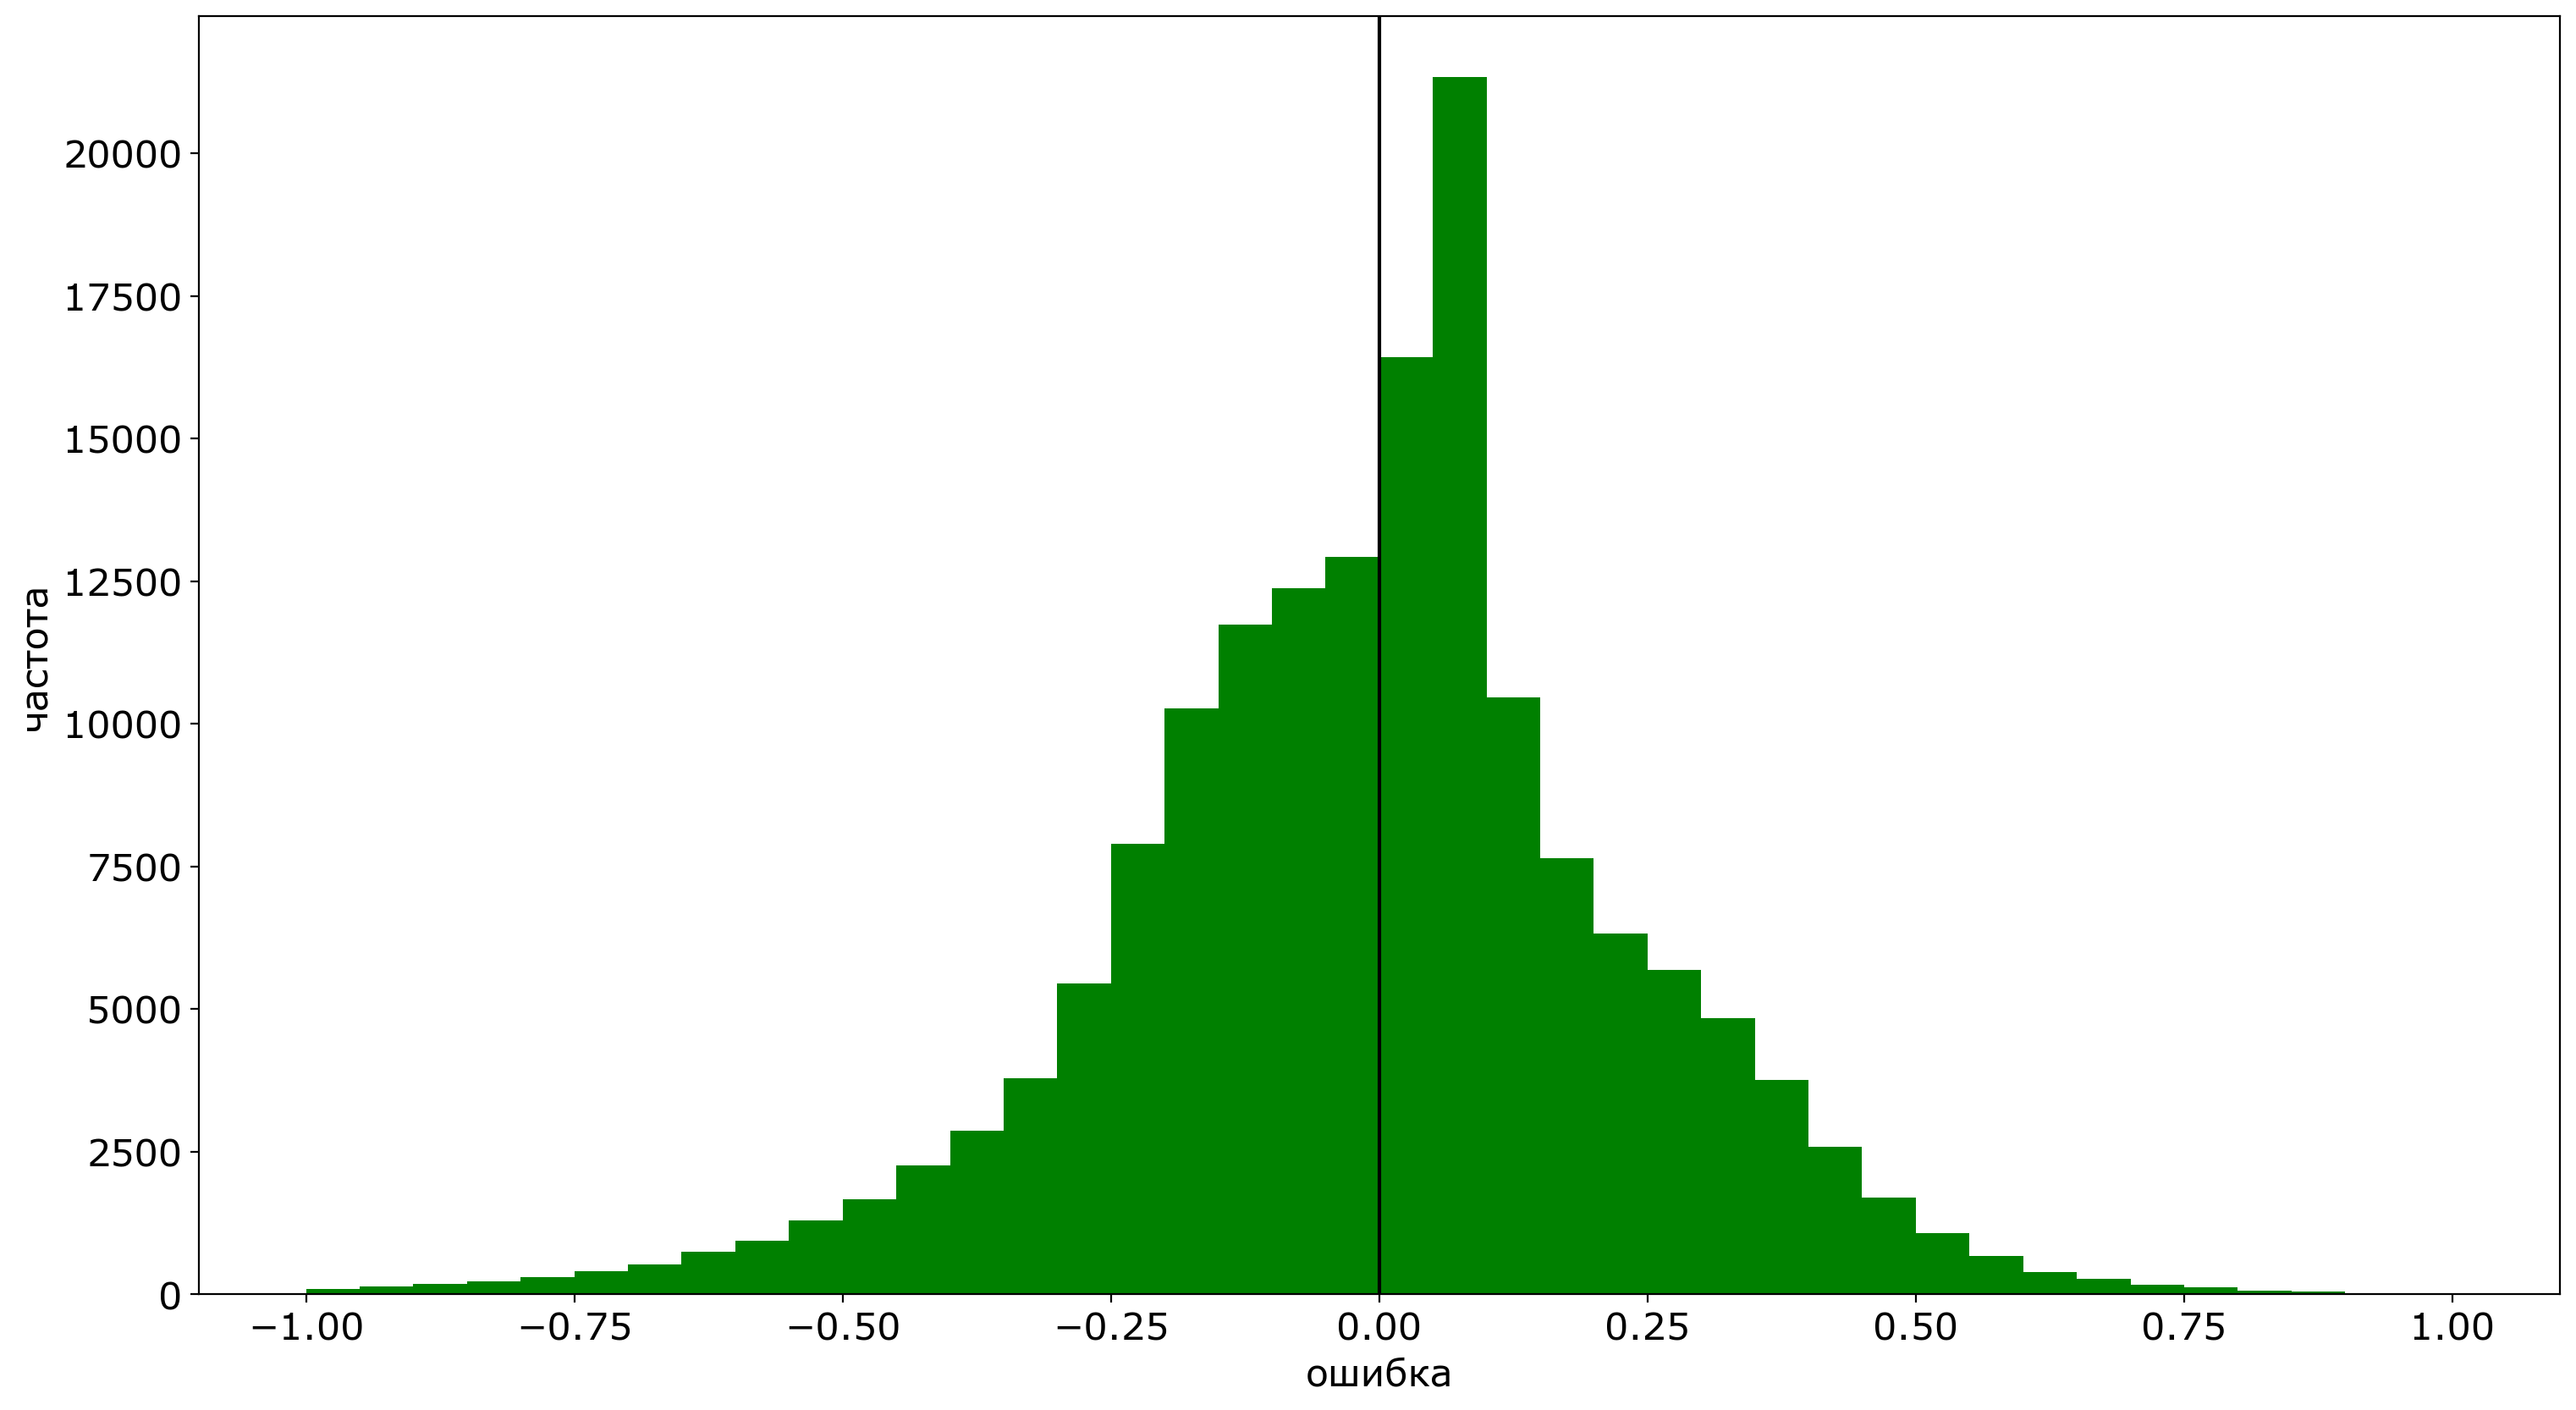

In [20]:
# распределение ошибок прогноза
err_bin = np.linspace(-1, 1, 41)
err_data_before = np.array(err_data_before)
plt.hist(err_data_before, bins=err_bin, color='green')
plt.axvline(0, ymax=15000, color='k')
plt.xlabel(u'ошибка')
plt.ylabel(u'частота')

Text(0, 0.5, 'частота')

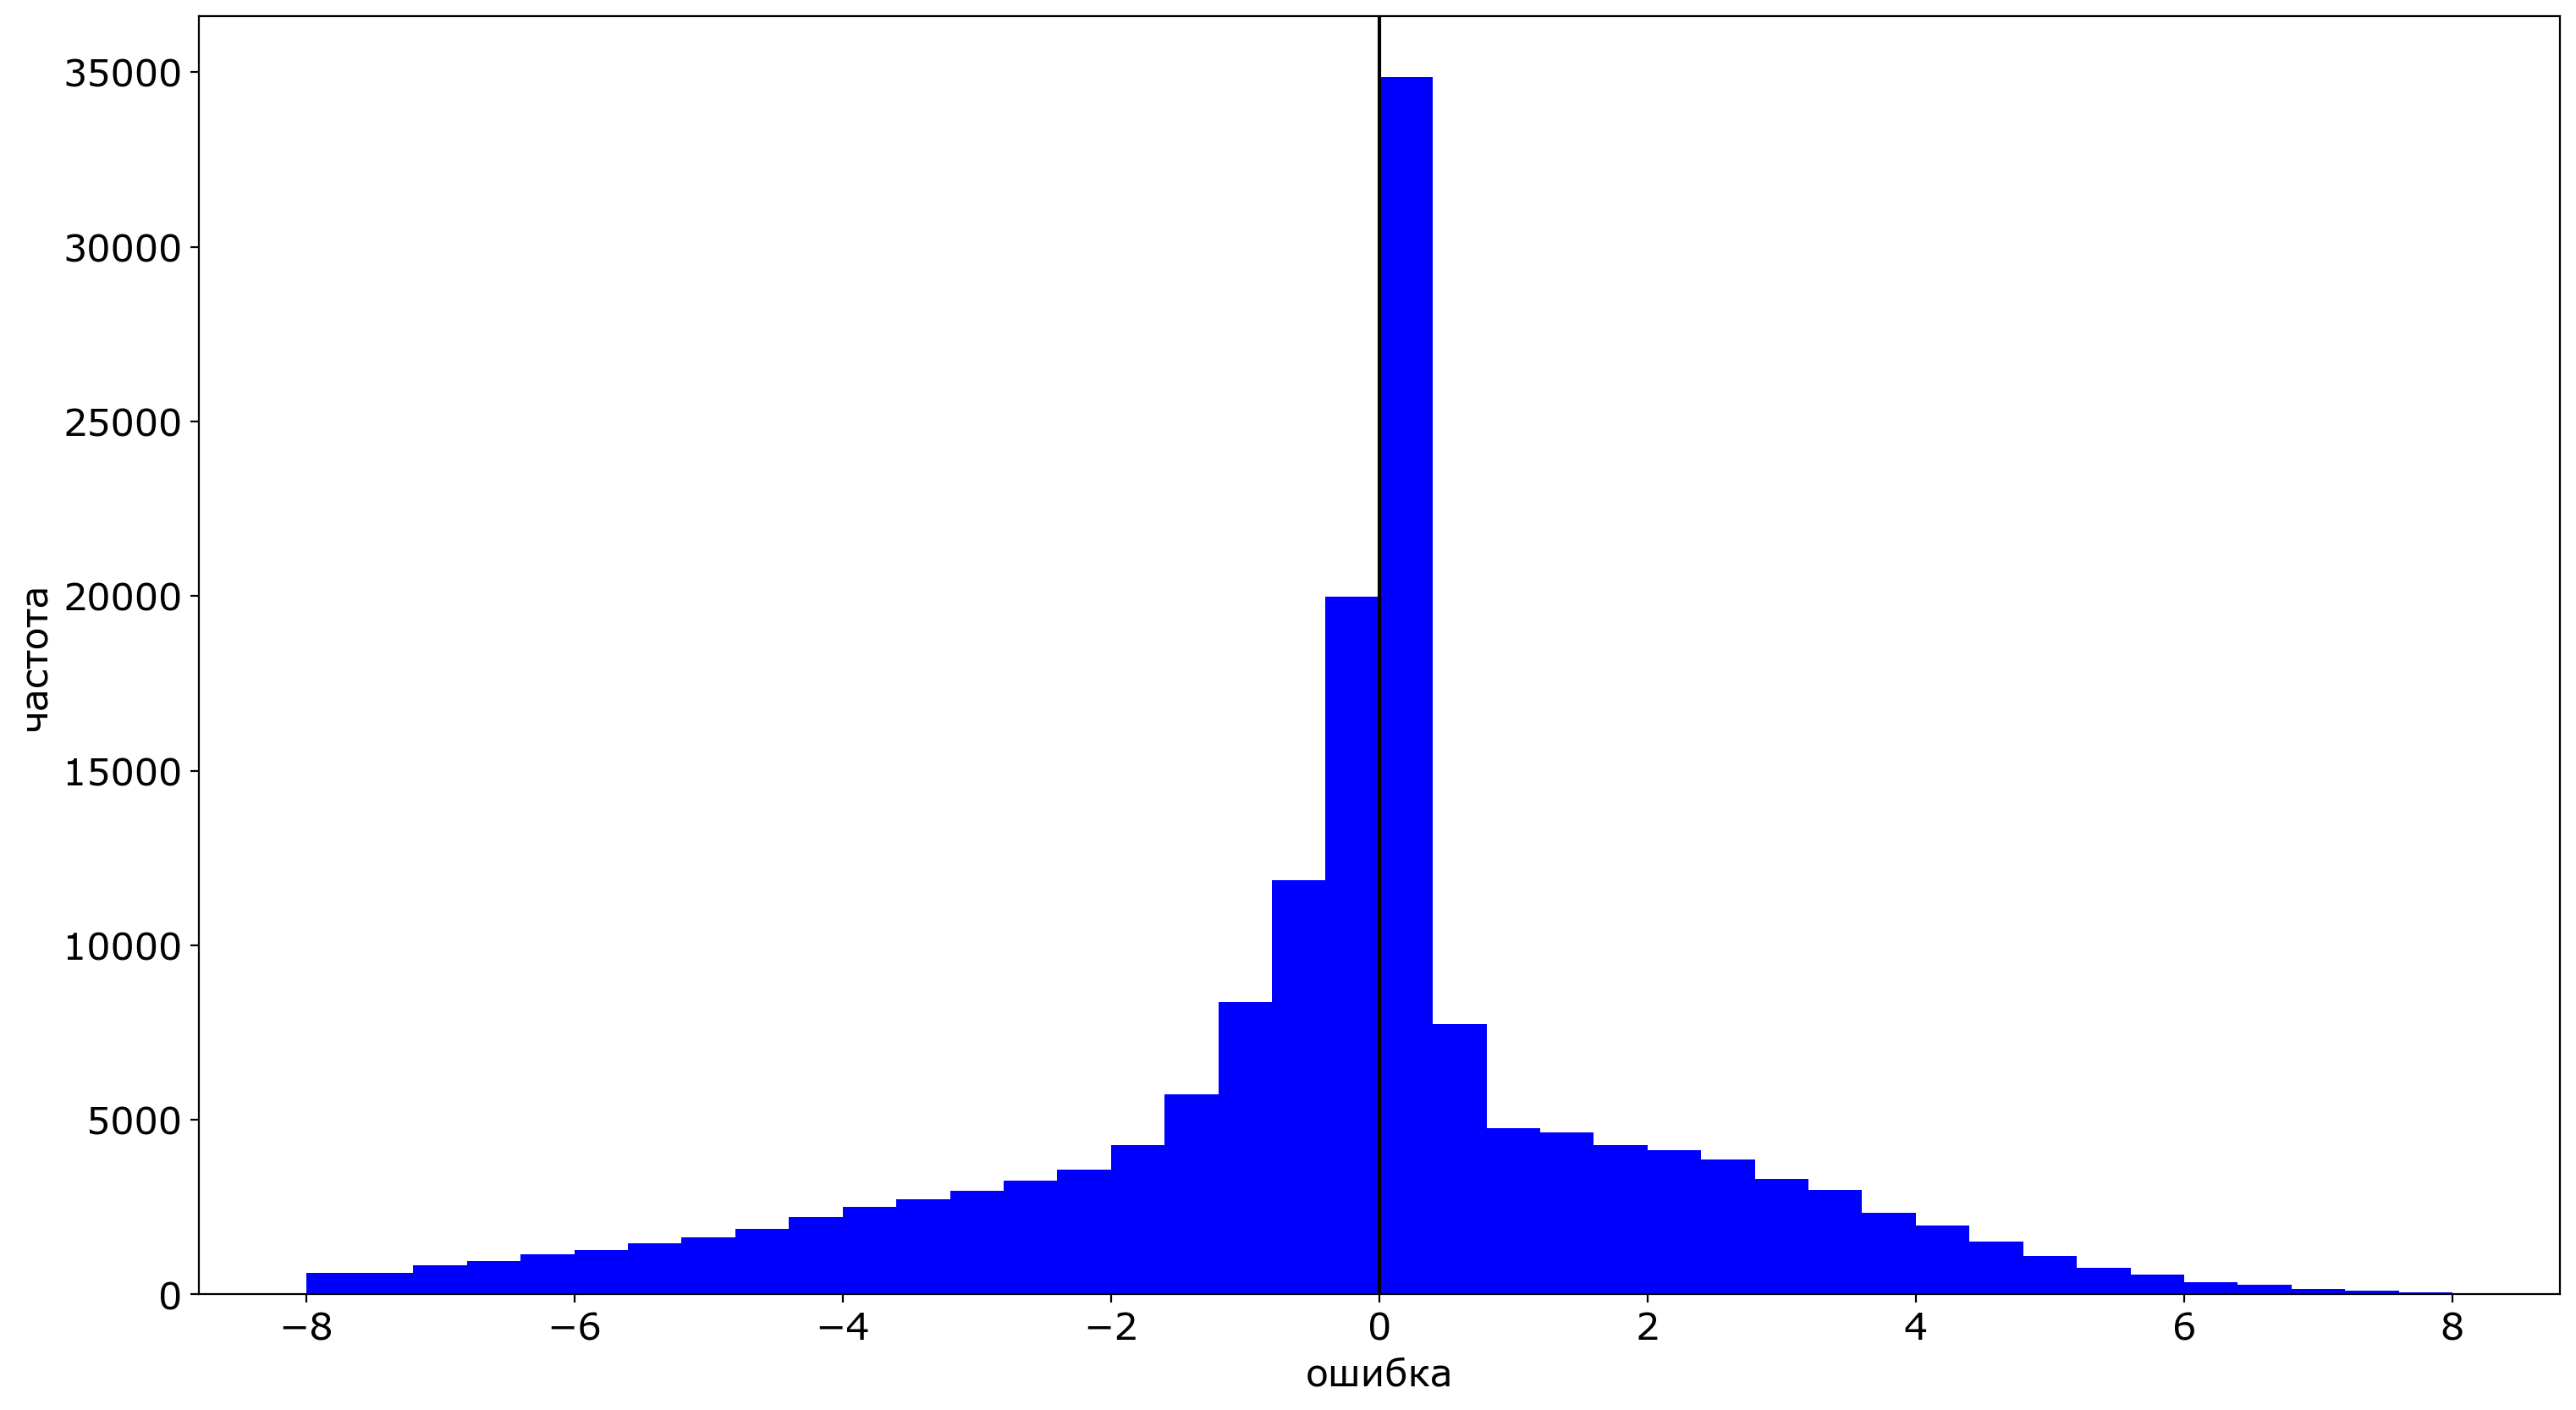

In [21]:
# распределение ошибок прогноза
err_bin = np.linspace(-8, 8, 41)
err_data_after = np.array(err_data_after)
plt.hist(err_data_after, bins=err_bin, color='blue')
plt.axvline(0, ymax=15000, color='k')
plt.xlabel(u'ошибка')
plt.ylabel(u'частота')

Text(0, 0.5, 'частота')

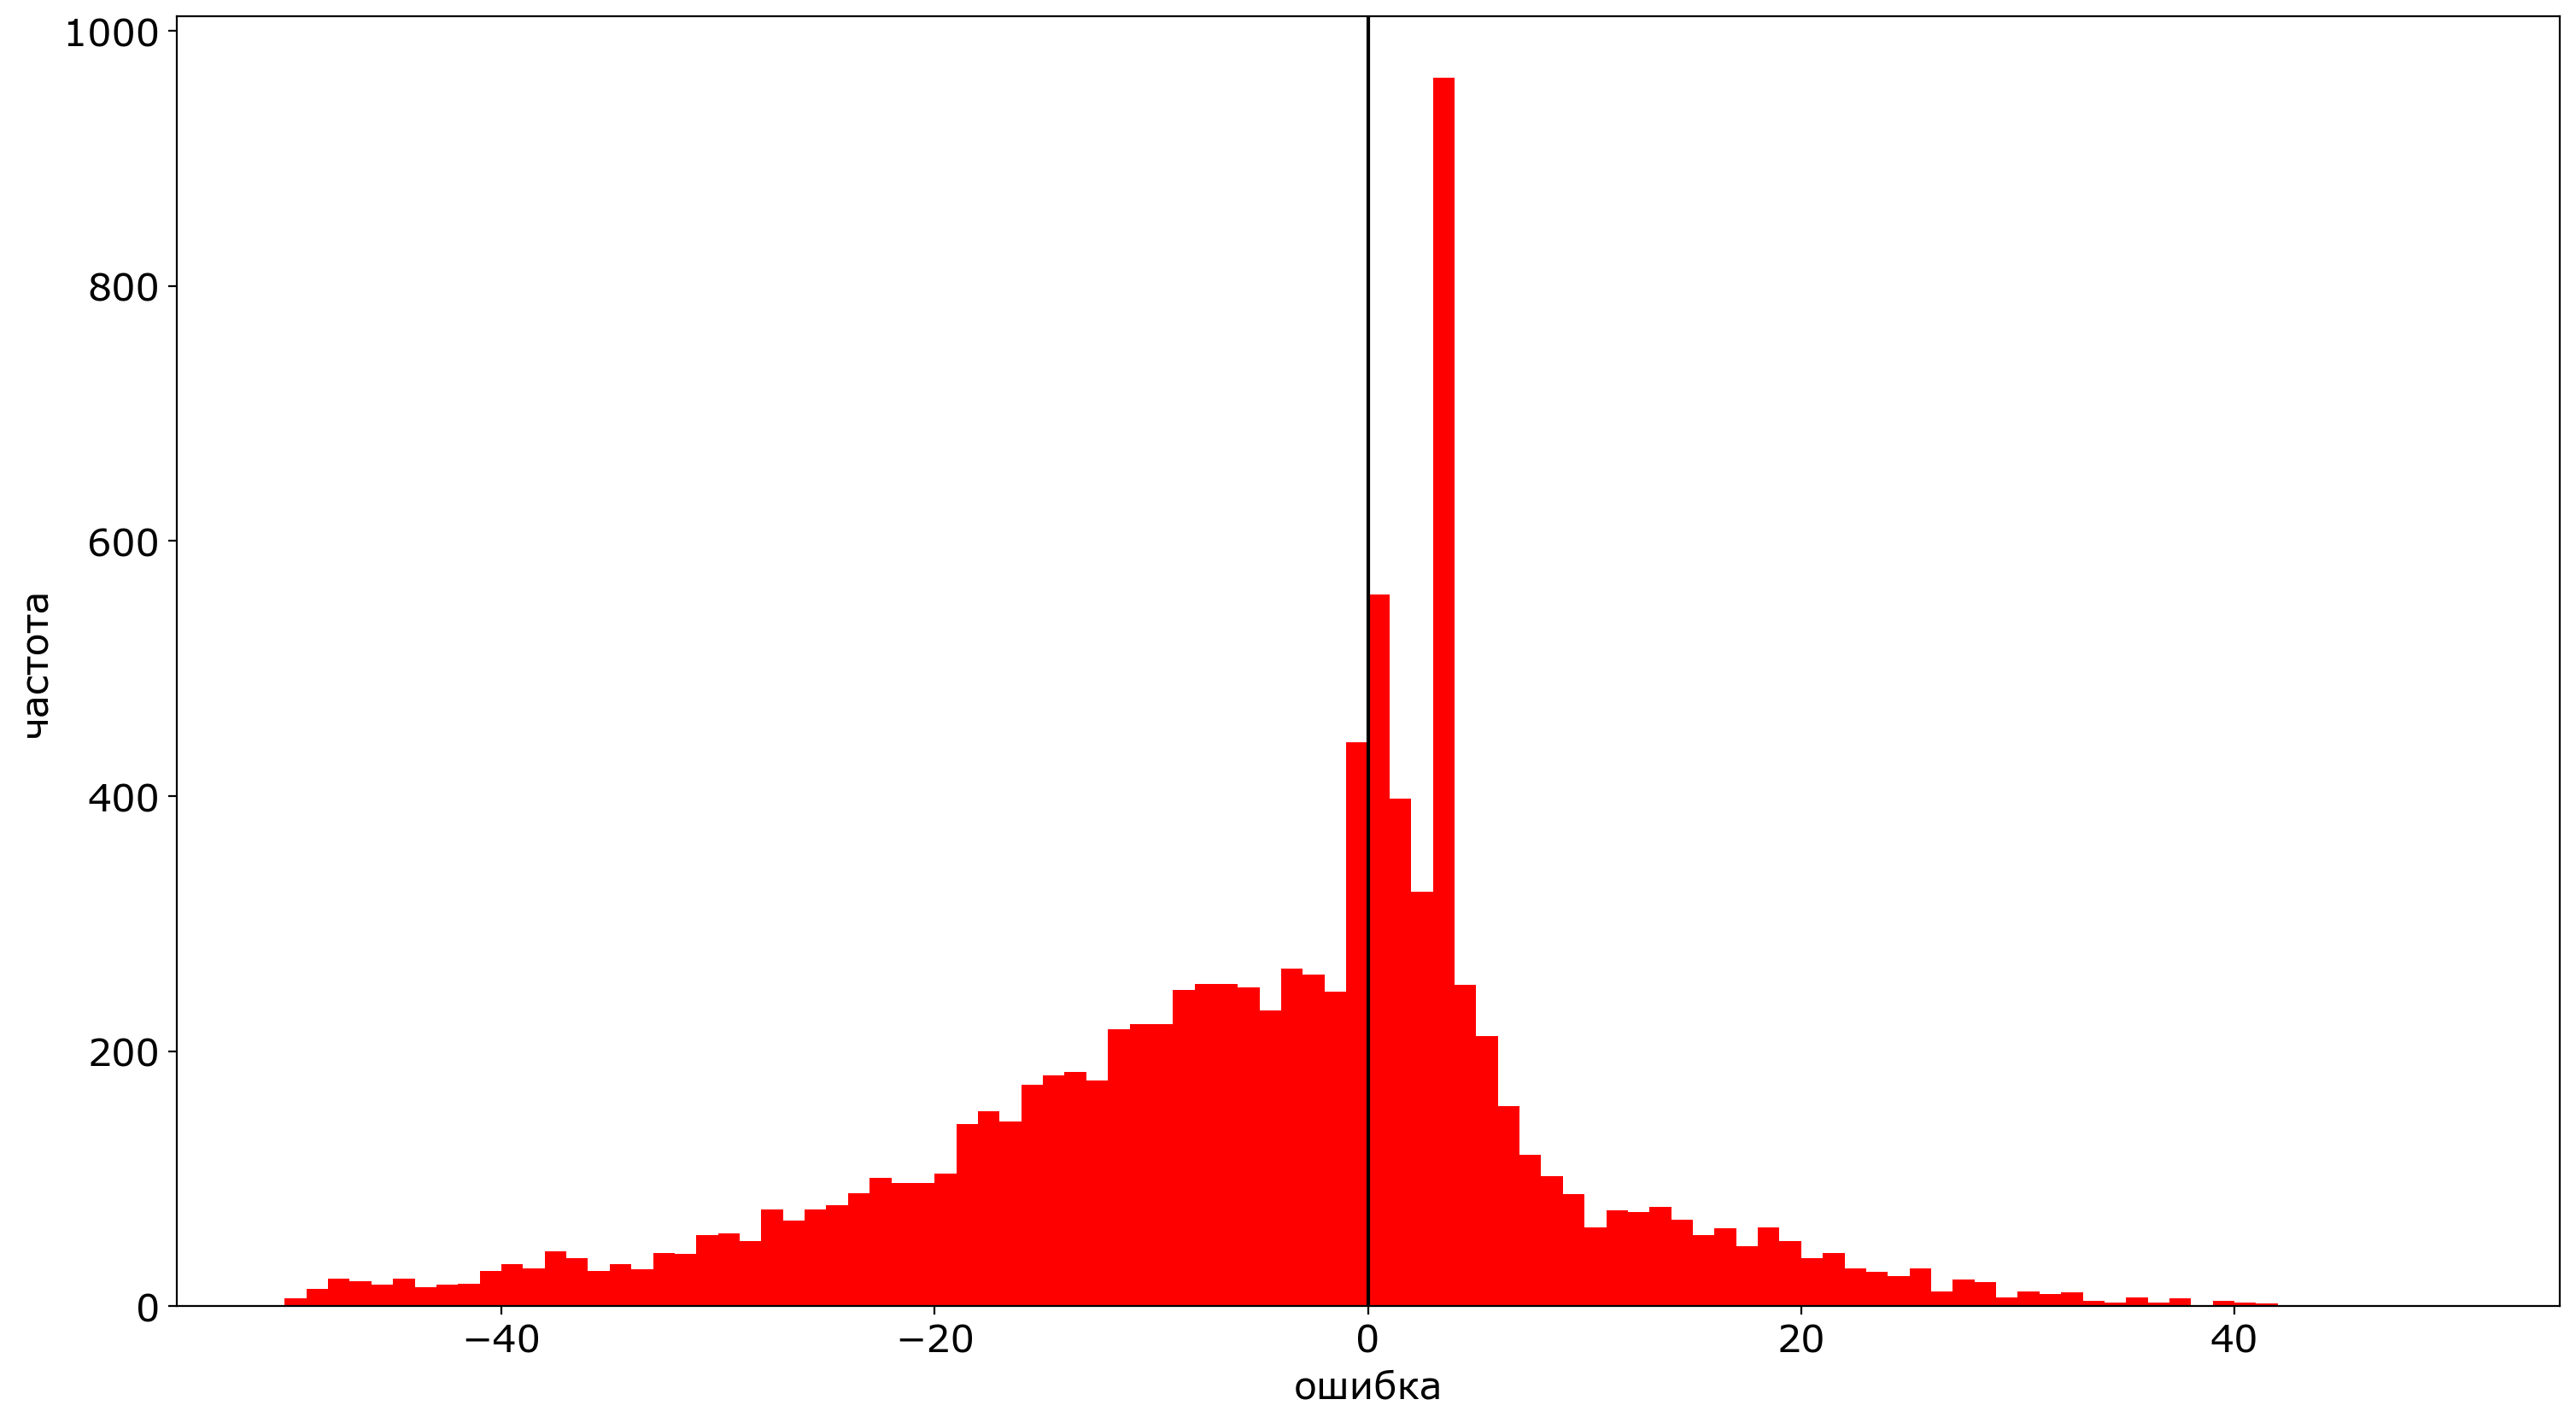

In [22]:
# распределение ошибок сумарного (на item) прогноза 
err_bin = np.linspace(-50, 50, 101)
err_data_item = np.array(err_data_item)
plt.hist(err_data_item, bins=err_bin, color='red')
plt.axvline(0, ymax=15000, color='k')
plt.xlabel(u'ошибка')
plt.ylabel(u'частота')

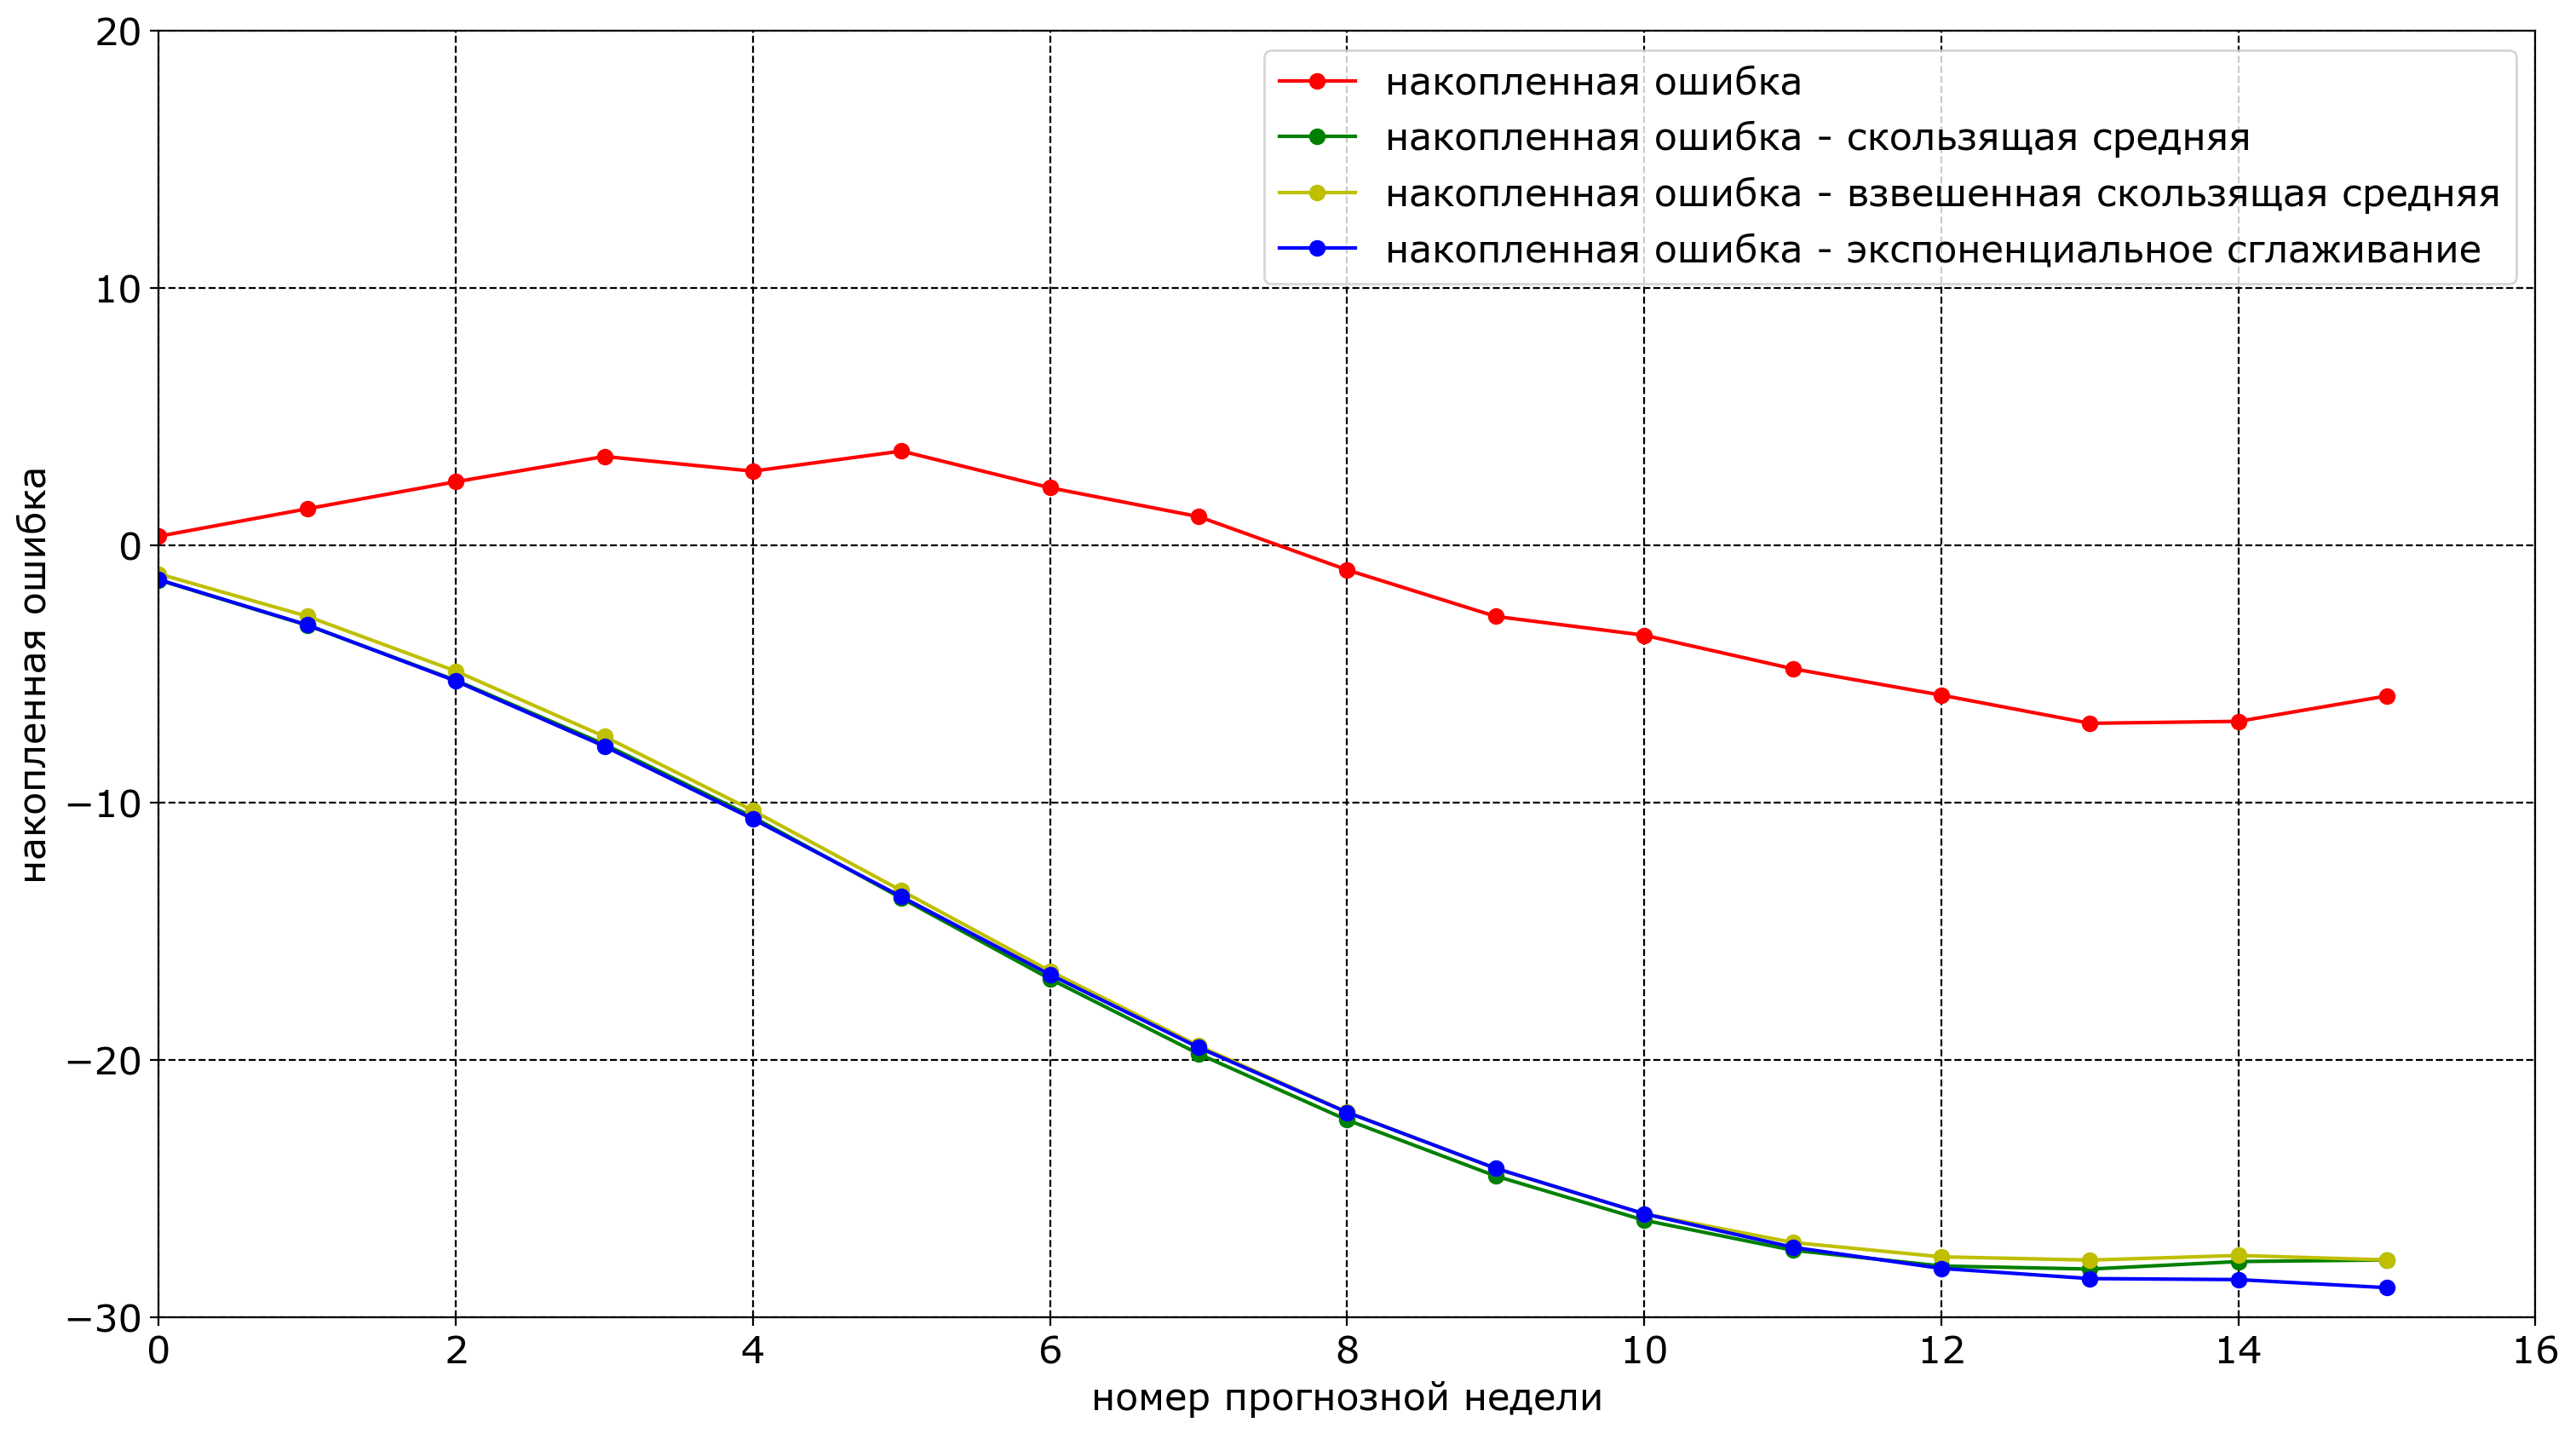

In [23]:
# накапливаемая ошибка сумарного (на item) прогноза
err_data_after = err_data_after.reshape(-1, 16)
err_moving_average = np.array(err_moving_average)
err_moving_average = err_moving_average.reshape(-1, 16)
err_moving_weights_average = np.array(err_moving_weights_average)
err_moving_weights_average = err_moving_weights_average.reshape(-1, 16)
err_ExpSmoth = np.array(err_ExpSmoth)
err_ExpSmoth = err_ExpSmoth.reshape(-1, 16)

cumsum_err = np.cumsum(err_data_after, axis = 1)
cumsum_err = np.mean(cumsum_err, axis = 0)
cumsum_err_ma = np.cumsum(err_moving_average, axis = 1)
cumsum_err_ma = np.mean(cumsum_err_ma, axis = 0)
cumsum_err_mwa = np.cumsum(err_moving_weights_average, axis = 1)
cumsum_err_mwa = np.mean(cumsum_err_mwa, axis = 0)
cumsum_err_ExpSmoth = np.cumsum(err_ExpSmoth, axis = 1)
cumsum_err_ExpSmoth = np.mean(cumsum_err_ExpSmoth, axis = 0)

week = np.arange(16)
plt.plot(week, cumsum_err, '-or')
plt.plot(week, cumsum_err_ma, '-og')
plt.plot(week, cumsum_err_mwa, '-oy')
plt.plot(week, cumsum_err_ExpSmoth, '-ob')

plt.xlabel(u'номер прогнозной недели')
plt.ylabel(u'накопленная ошибка')
plt.grid(True, axis='y', color='black',  linestyle='dashed')
plt.grid(True, axis='x', color='black',  linestyle='dashed')
plt.xlim(0, len(week))
# minimum = cumsum_err.min() if cumsum_err.min() < cumsum_err_abs.min() else cumsum_err_abs.min()
plt.ylim(-30, 20)
lab1 = u'накопленная ошибка - нейронная сеть'
lab2 = u'накопленная ошибка - скользящая средняя'
lab3 = u'накопленная ошибка - взвешенная скользящая средняя'
lab4 = u'накопленная ошибка - экспоненциальное сглаживание'
plt.legend((lab1, lab2, lab3, lab4), frameon=True, loc='best')

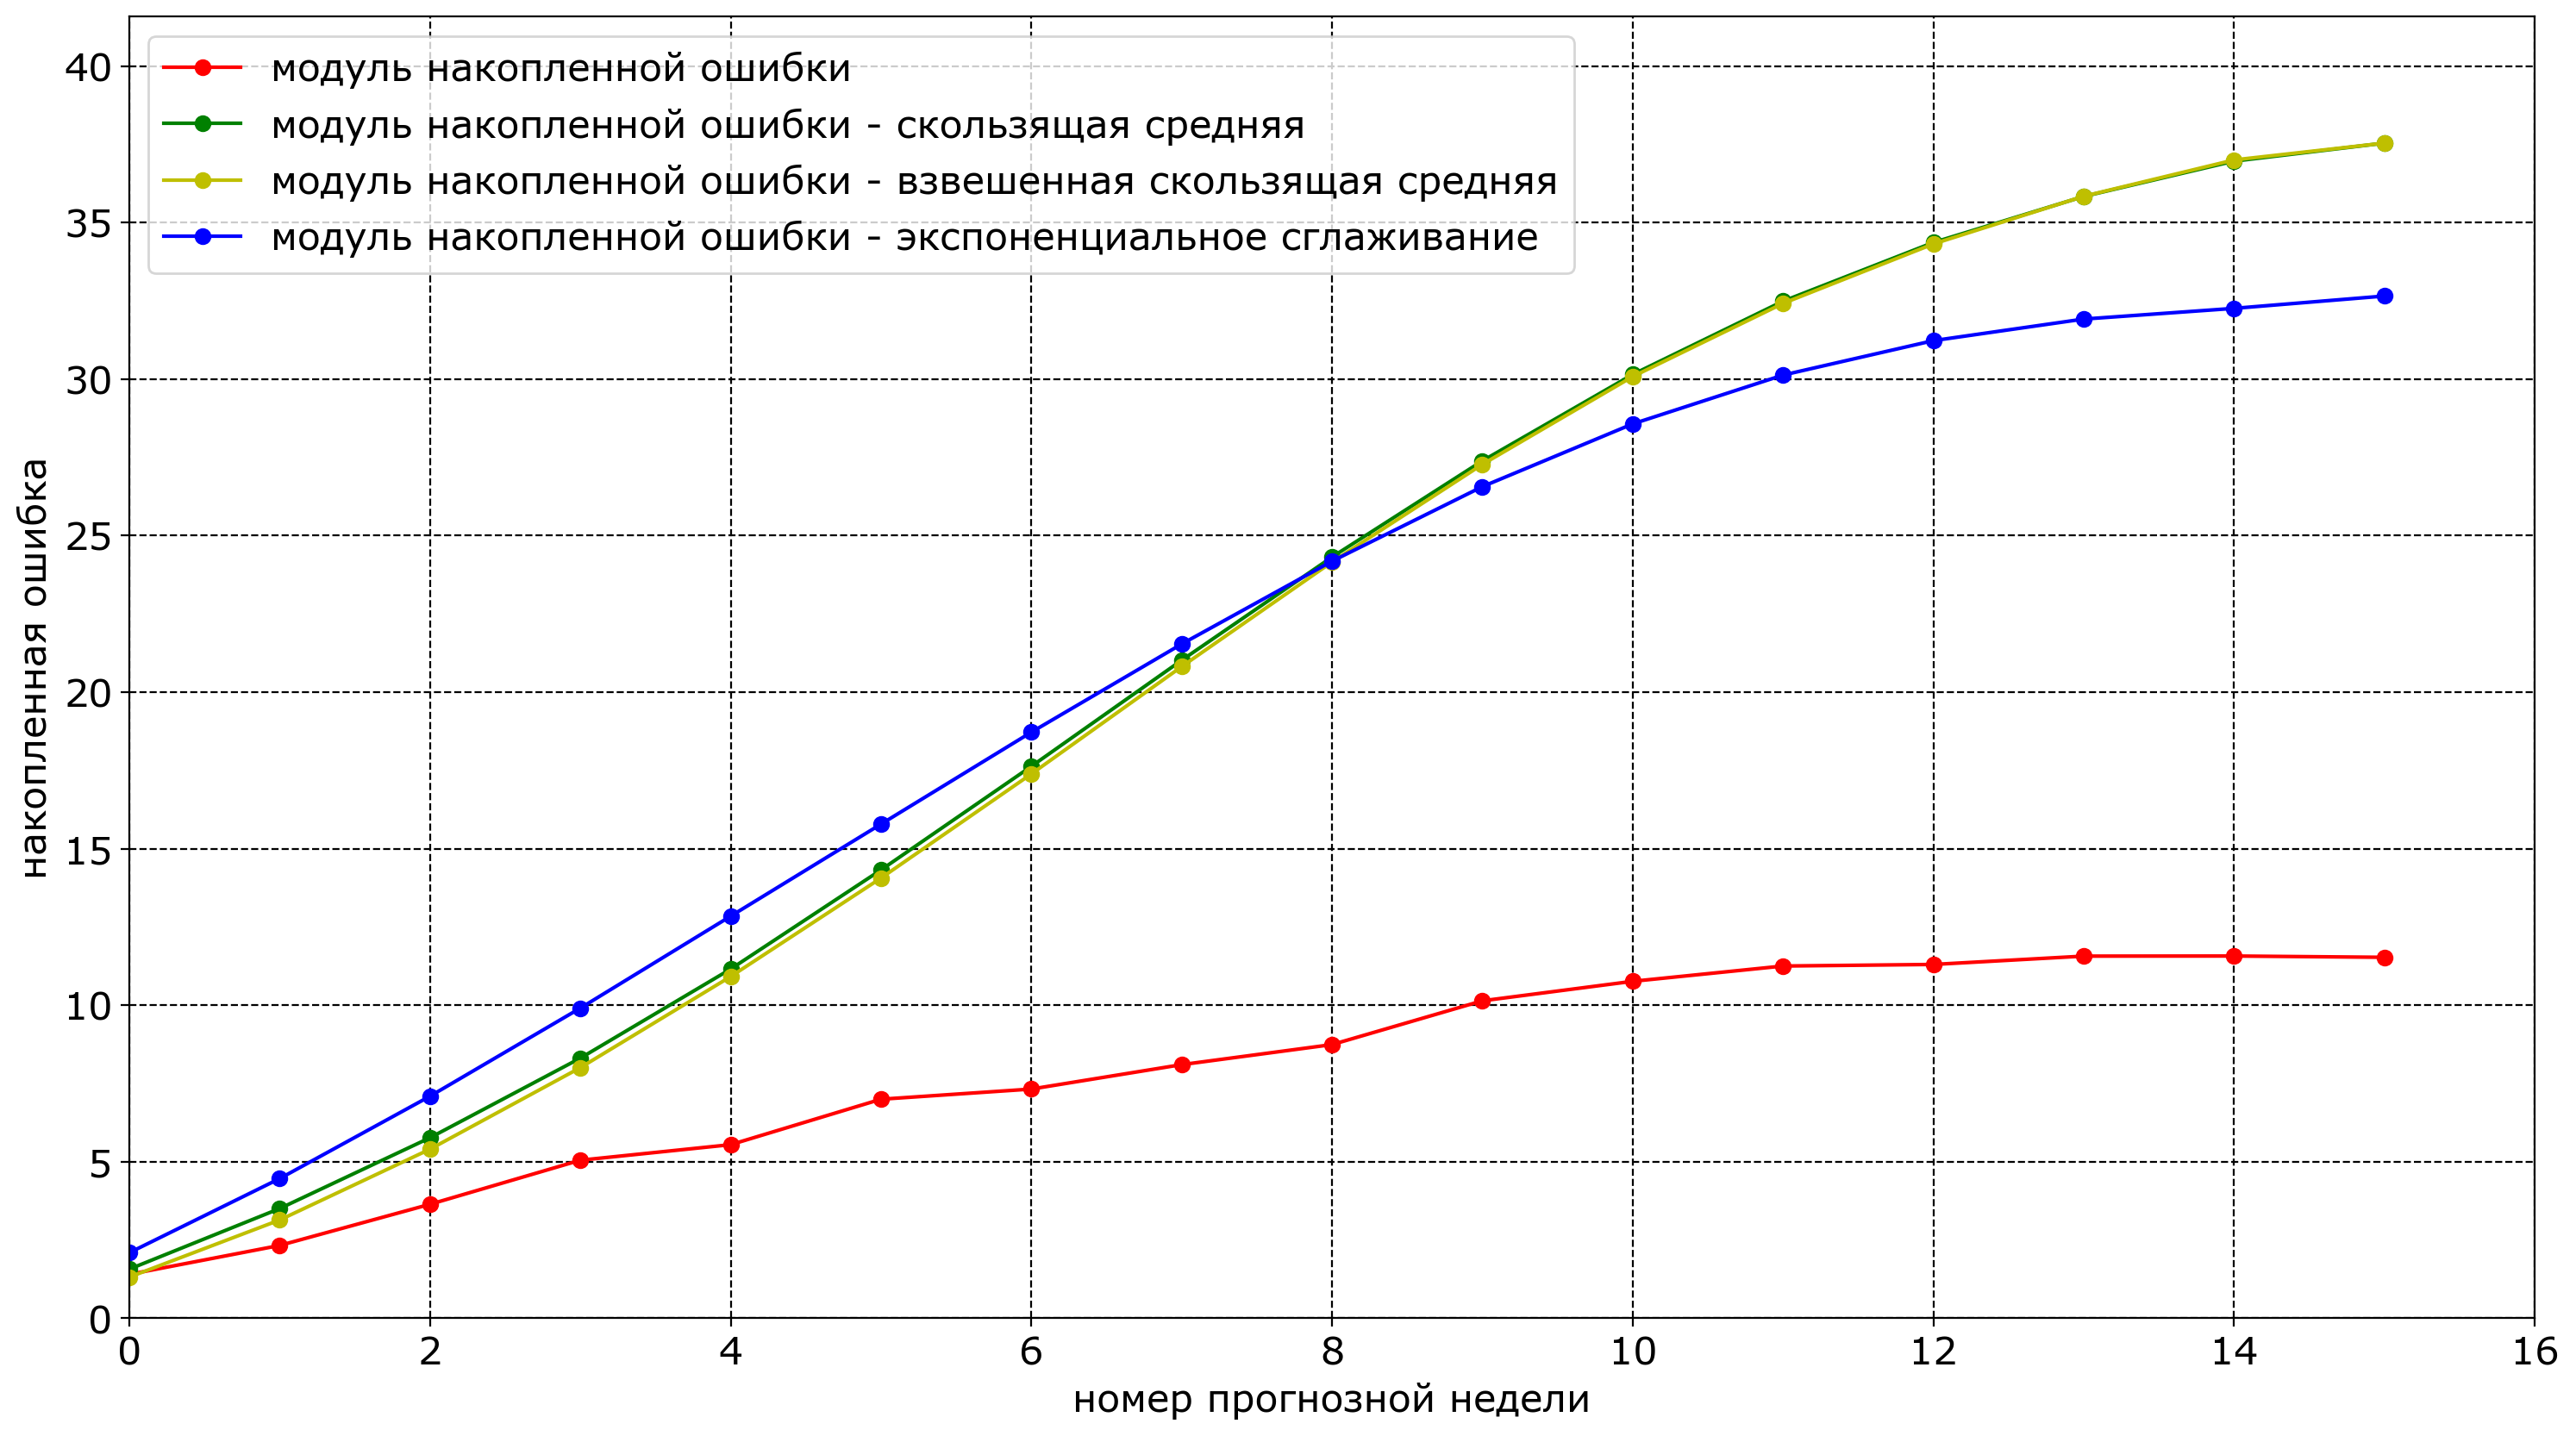

In [24]:
# накапливаемая по модулю ошибка сумарного (на item) прогноза
cumsum_err_abs = np.abs(np.cumsum(err_data_after, axis = 1))
cumsum_err_abs = np.mean(cumsum_err_abs, axis = 0)
cumsum_err_abs_ma = np.abs(np.cumsum(err_moving_average, axis = 1))
cumsum_err_abs_ma = np.mean(cumsum_err_abs_ma, axis = 0)
cumsum_err_abs_mwa = np.abs(np.cumsum(err_moving_weights_average, axis = 1))
cumsum_err_abs_mwa = np.mean(cumsum_err_abs_mwa, axis = 0)
cumsum_err_abs_ExpSmoth = np.abs(np.cumsum(err_ExpSmoth, axis = 1))
cumsum_err_abs_ExpSmoth = np.mean(cumsum_err_abs_ExpSmoth, axis = 0)

week = np.arange(16)
plt.plot(week, cumsum_err_abs, '-or')
plt.plot(week, cumsum_err_abs_ma, '-og')
plt.plot(week, cumsum_err_abs_mwa, '-oy')
plt.plot(week, cumsum_err_abs_ExpSmoth, '-ob')
plt.xlabel(u'номер прогнозной недели')
plt.ylabel(u'накопленная ошибка')
plt.grid(True, axis='y', color='black',  linestyle='dashed')
plt.grid(True, axis='x', color='black',  linestyle='dashed')
plt.xlim(0, len(week))
minimum = cumsum_err.min() if cumsum_err.min() < cumsum_err_abs.min() else cumsum_err_abs.min()
plt.ylim(0, cumsum_err_abs.max() + 30)
lab1 = u'модуль накопленной ошибки - нейронная сеть'
lab2 = u'модуль накопленной ошибки - скользящая средняя'
lab3 = u'модуль накопленной ошибки - взвешенная скользящая средняя'
lab4 = u'модуль накопленной ошибки - экспоненциальное сглаживание'
plt.legend((lab1, lab2, lab3, lab4), frameon=True, loc='best')